In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
from IPython.display import HTML 
HTML('''<script>code_show=true;function code_toggle()
{if (code_show){$('div.input').hide();} 
else{$('div.input').show();}code_show = !code_show}$( document ).ready(code_toggle);
</script><em>The raw code in this jupyter notebook is hidden by default for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</,!a></em>.''')

In [44]:
import sys
sys.path.insert(0, "/home/max/auger/soft/")
import myPlots
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 12)
plt.rcParams.update({'font.size': 20})
from scipy import constants
from scipy.integrate import simps
import warnings
warnings.filterwarnings("ignore")
import itertools as it

- Set save folder for data and figures.

In [2]:
saveFolder='/home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/'

# Antenna pattern part
The class <i>getAntennaPatternQuantities</i> reads the Offline XML file with the Antenna pattern. Further, it allows you to transform the antenna pattern to azimuth convention -180$^\circ$,180$^\circ$ (With East at +90$^\circ$ and West at -90$^\circ$) and from zenith to altitude. This convention is what is internal used by healpy. Also, you can interpolate the antenna pattern. See the examples. <br>
***
!!! Note that the NS antenna pattern in Offline is align to NS sensitivity. During the run Offline properly rotates the antenna pattern.
See RModels_RD.xml and check the part with $<$OrientationAzimuth$>$.
That is why the convention transformation in the class <i>getAntennaPatternQuantities</i> is different for the EW and NS orientation.

In [3]:
from collections import OrderedDict
import os
from lxml import etree as ET
from io import StringIO
from scipy.interpolate import interp1d

class getAntennaPatternQuantities():
    def __init__(self,antennaPath):
        self._frequencyXML, phiXML, thetaXML, MeanTransferXML, self._theta_ampXML, self._theta_phaseXML,\
        self._phi_ampXML, self._phi_phaseXML = self._read_rp(antennaPath)
        self._phi = list(OrderedDict.fromkeys(phiXML))
        self._theta = list(OrderedDict.fromkeys(thetaXML))
        self._templateDF = self._DFtemplateCreator(self._theta,self._phi,yName='phi')
    def _DFtemplateCreator(self,xs,ys,yName=None):
        colList = [str(x) for x in xs]
        nan_init = np.empty((len(xs),len(ys),))
        nan_init[:]=np.nan
        templateDF = pd.DataFrame(nan_init.T, columns = colList)
        templateDF.insert(0,yName,ys)
        templateDF = templateDF.set_index(yName)
        return templateDF
    def _interpolate(self,df,newAxisValues, axis,kind='linear',
        copy=True, bounds_error=None, fill_value=np.nan, assume_sorted=False):
        if axis == 0:
            InterpFunc = interp1d(df.index.values.astype(float),df.values,kind=kind,axis=0,
            copy=copy, bounds_error=bounds_error, fill_value=fill_value, assume_sorted=assume_sorted)
            templateDF = self._DFtemplateCreator(df.columns.values.astype(float),newAxisValues, yName='phi')
        elif axis == -1:
            InterpFunc = interp1d(df.columns.values.astype(float),df.values,kind=kind,axis=-1,
            copy=copy, bounds_error=bounds_error, fill_value=fill_value, assume_sorted=assume_sorted)
            templateDF = self._DFtemplateCreator(newAxisValues,df.index.values.astype(float), yName='phi')
        newValues = InterpFunc(newAxisValues)
        templateDF.iloc[:,:] = newValues
        return templateDF
    def get(self, frequency=45, quantity='', newPhi=None, newTheta=None,changeConvention=False,orientation=False,
        kind='linear',copy=True, bounds_error=None, fill_value=np.nan, assume_sorted=False):
        #print('Getting quantity: '+quantity+' at frequency: '+str(frequency))
        findex = np.where(self._frequencyXML==frequency)[0][0]
        temporaryDF = self._templateDF.copy(deep=True)
        if quantity != 'absHeight':
            exec('temporaryDF.iloc[:,:] = self._'+quantity+'XML[findex].reshape(len(self._phi),len(self._theta))')
        elif quantity == 'absHeight':
            absHeight = np.sqrt( (1/2)* (self._theta_ampXML[findex].reshape(len(self._phi),len(self._theta))**2 + 
            self._phi_ampXML[findex].reshape(len(self._phi),len(self._theta))**2)   )
            temporaryDF.iloc[:,:] = absHeight
        if changeConvention == True:
            temporaryDF = self._changeAzimuthDefinitionAndZenith2Altitude(temporaryDF,orientation=orientation)
        # if interpolate
        if newPhi is not None:
            temporaryDF = self._interpolate(temporaryDF, newPhi, axis=0, kind=kind,
            copy=copy, bounds_error=bounds_error, fill_value=fill_value, assume_sorted=assume_sorted)
        if newTheta is not None:
            temporaryDF = self._interpolate(temporaryDF, newTheta, axis=-1, kind=kind,
            copy=copy, bounds_error=bounds_error, fill_value=fill_value, assume_sorted=assume_sorted)
        return temporaryDF
    def _changeAzimuthDefinitionAndZenith2Altitude(self, df,orientation=False):
        #def changeAzimuthDefinitionAndZenith2Altitude(temporaryDF):
        # drop last coll since it is just copy of the first row to make things periodical
        df = df.drop(index=360.0)
        # change the azimuth order from counterclockwise to clockwise by -1 and rotate it by 90 deg to align North to 0
        newIndex = np.asarray(df.index)
        if orientation == 'EW':
            newIndex=-(newIndex-90)
        elif orientation == 'NS':
            newIndex=-(newIndex-180)
        else:
            print('Set orientation of the antenna!')
        # fix values outside the -180 to 180 interval
        newIndex[np.where(newIndex<-180)] = newIndex[np.where(newIndex< -180)]+360
        # set new index and sort by it
        df=df.set_index(newIndex)
        df=df.sort_index()
        # find which periodical row is missing and add it
        try:
            lastRow = df.loc[-180.0]
            lastRow.name=180.0
        except:
            lastRow = df.loc[180.0]
            lastRow.name=-180.0
        df=df.append(lastRow)
        df=df.sort_index()
        # now change zenith to altitude
        cols=df.columns.tolist()
        df=df[cols[::-1]]
        df.columns=cols
        return df
    def getPhiAndThetaGrid(self):
        return np.meshgrid(self._phi, self._theta)
    def _read_rp(self, path): # credits to KIT for this funcion If the original author find this, send me your name :) !!!
        def get_component(root, comp):
            component = []
            for x in root.findall(comp):
                component.append(string_to_float_array(x.text))
            return np.array(component)
        def string_to_float_array(string, det=" "):# credits to KIT for this funcion
            return np.array([float(x) for x in string.split(det) if x.strip()])
        fopen = open(path, "r")
        fstring = fopen.read()
        # to create proper root
        fstring = "<rp>" + fstring + "</rp>"
        # get parser and tree
        parser = ET.XMLParser(remove_blank_text=True, remove_comments=True)
        tree = ET.parse(StringIO(fstring), parser)
        # get root object
        rp_root = tree.getroot()
        frequency = string_to_float_array(rp_root.find("frequency").text)
        phi = string_to_float_array(rp_root.find("phi").text)
        theta = string_to_float_array(rp_root.find("theta").text)
        MeanTransfer = string_to_float_array(rp_root.find("MeanTransfer").text)
        theta_amp = get_component(rp_root, "EAHTheta_amp")
        theta_phase = get_component(rp_root, "EAHTheta_phase")
        phi_amp = get_component(rp_root, "EAHPhi_amp")
        phi_phase = get_component(rp_root, "EAHPhi_phase")
        for x in [theta_phase, phi_amp, phi_phase]:
            if theta_amp.shape != x.shape:
                sys.exit("Mismatch component")
        if len(frequency) != len(MeanTransfer):
            sys.exit("Mismatch MeanTransfer")
        if len(frequency) != theta_amp.shape[0] or len(phi) != theta_amp.shape[1] or len(theta) != theta_amp.shape[1]:
            print(len(frequency), len(phi), len(theta), theta_amp.shape)
            sys.exit("Mismatch directions")
        return frequency, phi, theta, MeanTransfer, theta_amp, theta_phase, phi_amp, phi_phase

In [4]:
# interative plots on
%matplotlib notebook
import mpld3
mpld3.enable_notebook()

In [5]:
# interactive plots off
%matplotlib inline

In [6]:
# set path to the antenna pattern XML files
antennaPathEW = '/home/max/auger/soft/offline/src/Framework/RDetector/AntennaModels/SALLA/SALLA_RD_NEC2_with-WCD-SSD_EW.xml'
antennaPathNS = '/home/max/auger/soft/offline/src/Framework/RDetector/AntennaModels/SALLA/SALLA_RD_NEC2_with-WCD-SSD_NS.xml'

In [7]:
antennaEW = getAntennaPatternQuantities(antennaPathEW)
antennaNS = getAntennaPatternQuantities(antennaPathNS)

# Examples

cmap.T:  256
tmins:  5.957178257653379e-13  tmax:  2.275922210609798  Tstep:  9
cbarTicks:  [5.95717826e-13 2.84490276e-01 5.68980553e-01 8.53470829e-01
 1.13796111e+00 1.42245138e+00 1.70694166e+00 1.99143193e+00
 2.27592221e+00]
Creation of the directory failed (already exists?)
Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/EW_phi_amp_45Mhz


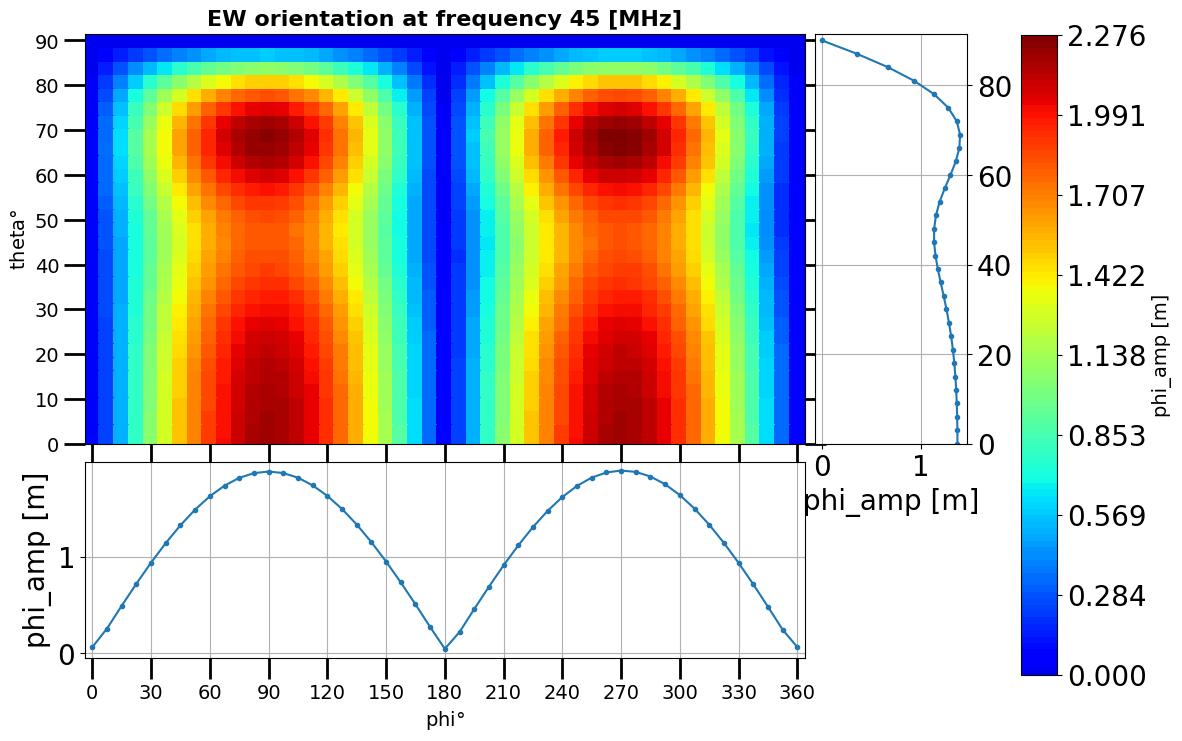

cmap.T:  256
tmins:  5.428794415618585e-13  tmax:  2.1381560698956927  Tstep:  9
cbarTicks:  [5.42879442e-13 2.67269509e-01 5.34539017e-01 8.01808526e-01
 1.06907803e+00 1.33634754e+00 1.60361705e+00 1.87088656e+00
 2.13815607e+00]
Creation of the directory failed (already exists?)
Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/NS_phi_amp_45Mhz


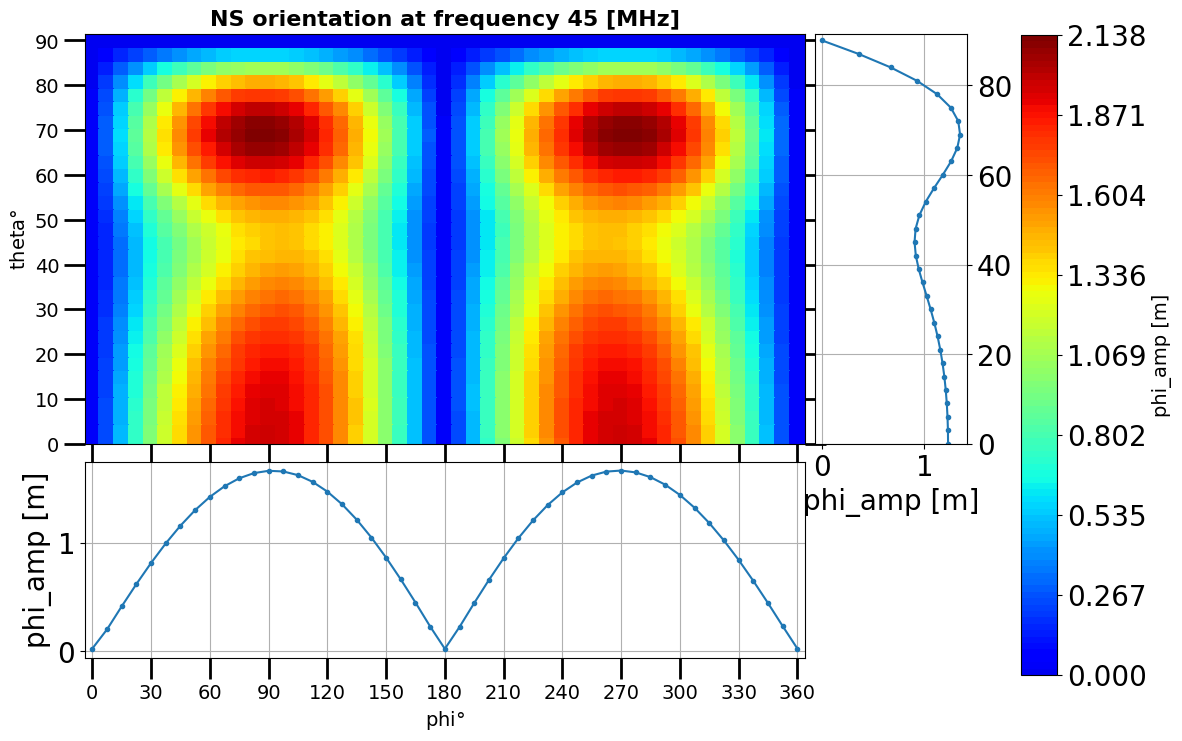

In [102]:
# example,plot antenna pattern quantity for frequency f 

# select frequency
frequency=45

# choose quantity
quantity = 'phi_amp'
# quantity = 'theta_amp'
# quantity = 'absHeight'

# select EW orientation
orientation = 'EW'
antenna=antennaEW
Amp = antenna.get(quantity=quantity,frequency=frequency)

close=False
# save=False
save=saveFolder+orientation+"_"+quantity+'_'+str(frequency)+'Mhz'

P, T = np.meshgrid(Amp.index.values.astype(float),Amp.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, Amp.values.T,slices=True, ymax=91.5, xMajorLocator=30,yMajorLocator=10,figureWidth=12,figureHeight=8,
                    xlabel='phi$\degree$',ylabel='theta$\degree$',cbarLabel=quantity+' [m]',
                    mainTitle=orientation+" orientation at frequency "+str(frequency)+' [MHz]',
                    save=save,close=close)
    
# select NS orientation
orientation = 'NS'
antenna=antennaNS
Amp = antenna.get(quantity=quantity,frequency=frequency)
save=False
save=saveFolder+orientation+"_"+quantity+'_'+str(frequency)+'Mhz'

P, T = np.meshgrid(Amp.index.values.astype(float),Amp.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, Amp.values.T,slices=True, ymax=91.5, xMajorLocator=30,yMajorLocator=10,figureWidth=12,figureHeight=8,
                    xlabel='phi$\degree$',ylabel='theta$\degree$',cbarLabel=quantity+' [m]',
                    mainTitle=orientation+" orientation at frequency "+str(frequency)+' [MHz]',
                    save=save,close=close)

cmap.T:  256
tmins:  5.957178257653379e-13  tmax:  2.2785828950003246  Tstep:  9
cbarTicks:  [5.95717826e-13 2.84822862e-01 5.69645724e-01 8.54468586e-01
 1.13929145e+00 1.42411431e+00 1.70893717e+00 1.99376003e+00
 2.27858290e+00]
Creation of the directory failed (already exists?)
Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/EW_phi_amp_45Mhz_thetaInterp_cubic


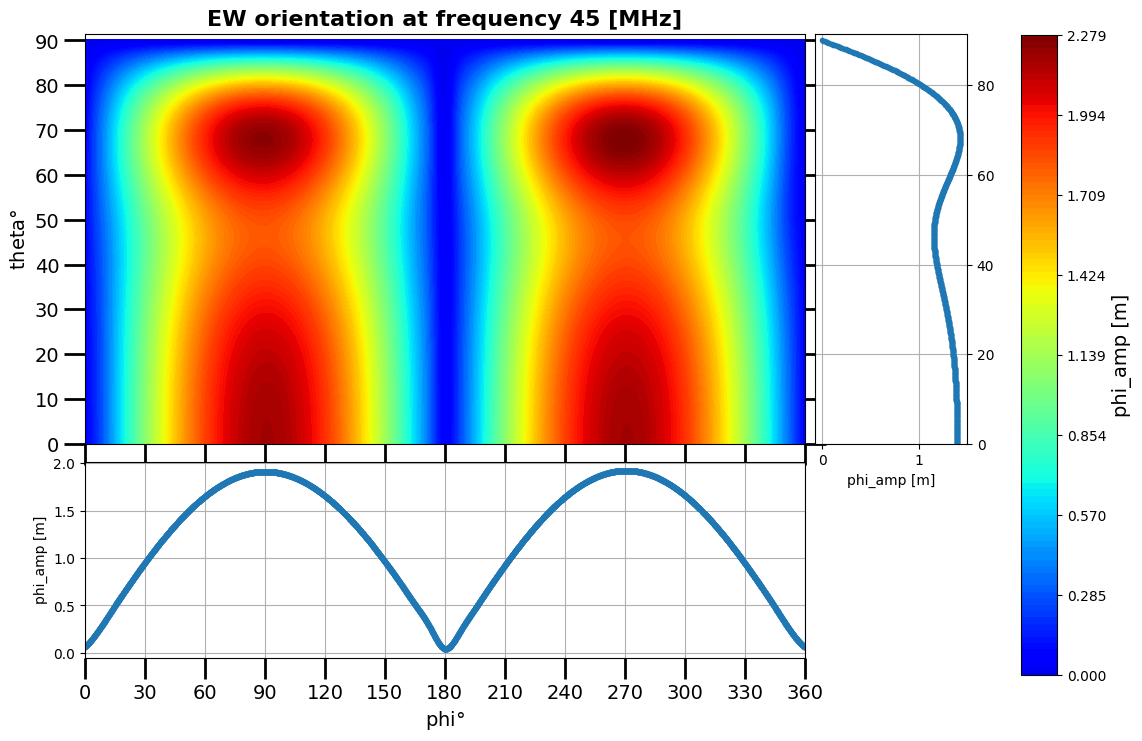

In [11]:
# example,plot antenna pattern quantity for frequency f 
# and interpolated phi and theta coordinates
incTheta = 0.1
incPhi = 0.1
newTheta = np.arange(0,90+incTheta,incTheta)
newPhi= np.arange(0,360+incPhi,incPhi)

# select frequency
frequency=45

# choose quantity
quantity = 'phi_amp'
# quantity = 'theta_amp'
# quantity = 'absHeight'

# select EW orientation
orientation = 'EW'
antenna=antennaEW

# select NS orientation
# orientation = 'NS'
# antenna=antennaNS

close=False
# save=False
save=saveFolder+orientation+"_"+quantity+'_'+str(frequency)+'Mhz'+'_thetaInterp_cubic'

# kind = linear, cubic etc. see scipy interp1d for options
Amp = antenna.get(quantity=quantity,frequency=frequency,newTheta=newTheta,newPhi=newPhi,kind='cubic',changeConvention=False,orientation='EW')

P, T = np.meshgrid(Amp.index.values.astype(float),Amp.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, Amp.values.T,slices=True, ymax=91.5, xMajorLocator=30,yMajorLocator=10,figureWidth=12,figureHeight=8,
                    xlabel='phi$\degree$',ylabel='theta$\degree$',cbarLabel=quantity+' [m]',
                    mainTitle=orientation+" orientation at frequency "+str(frequency)+' [MHz]',
                    save=save, close=close)

cmap.T:  256
tmins:  3.6454906805153474e-11  tmax:  1.6113411151012333  Tstep:  9
cbarTicks:  [3.64549068e-11 2.01417639e-01 4.02835279e-01 6.04252918e-01
 8.05670558e-01 1.00708820e+00 1.20850584e+00 1.40992348e+00
 1.61134112e+00]
Creation of the directory failed (already exists?)


/home/max/auger/soft/galactic_calibration/sky_maps/myPlots.py:1377: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/EW_absHeight_45Mhz


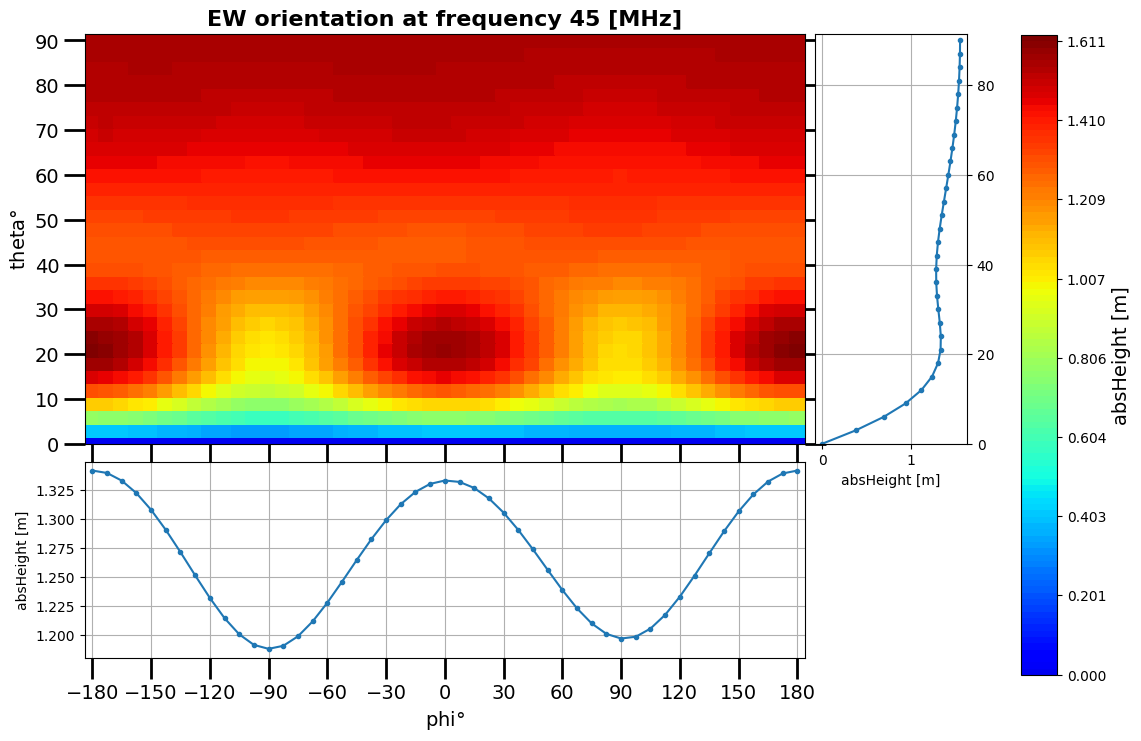

In [92]:
# example,plot antenna pattern quantity for frequency f 
# and change Offline convention to -180 and 180 azimuth with North at 0 and East at 90 degs, West at -90 degs (healpy internal standard)
# and zenith to altitude
# select frequency
frequency=45

# choose quantity
# quantity = 'phi_amp'
# quantity = 'theta_amp'
quantity = 'absHeight'

# select EW orientation
orientation = 'EW'
antenna=antennaEW

# select NS orientation
# orientation = 'NS'
# antenna=antennaNS

close=False
# save=False
save=saveFolder+orientation+"_"+quantity+'_'+str(frequency)+'Mhz'

# changeConvention=True,orientation='EW', EW and NS has to be treated differently since both are in Offline align to North
Amp = antenna.get(quantity=quantity,frequency=frequency,changeConvention=True,orientation='EW')


P, T = np.meshgrid(Amp.index.values.astype(float),Amp.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, Amp.values.T,slices=True, ymax=91.5, xMajorLocator=30,yMajorLocator=10,figureWidth=12,figureHeight=8,
                    xlabel='phi$\degree$',ylabel='theta$\degree$',cbarLabel=quantity+' [m]',
                    mainTitle=orientation+" orientation at frequency "+str(frequency)+' [MHz]',
                    save=save,close=close)

***
***
<font size="4">- This is the most usefull for the real work. We need to change the Offline convention to healpy convention with properly rotated NS antenna. Moreover, the antenna is interpolated to custom spacing. </font>

cmap.T:  256
tmins:  3.6446405913364005e-11  tmax:  1.6131864259431856  Tstep:  9
cbarTicks:  [3.64464059e-11 2.01648303e-01 4.03296607e-01 6.04944910e-01
 8.06593213e-01 1.00824152e+00 1.20988982e+00 1.41153812e+00
 1.61318643e+00]
Creation of the directory failed (already exists?)
Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/EW_absHeight_45Mhz_thetaInterp_cubic


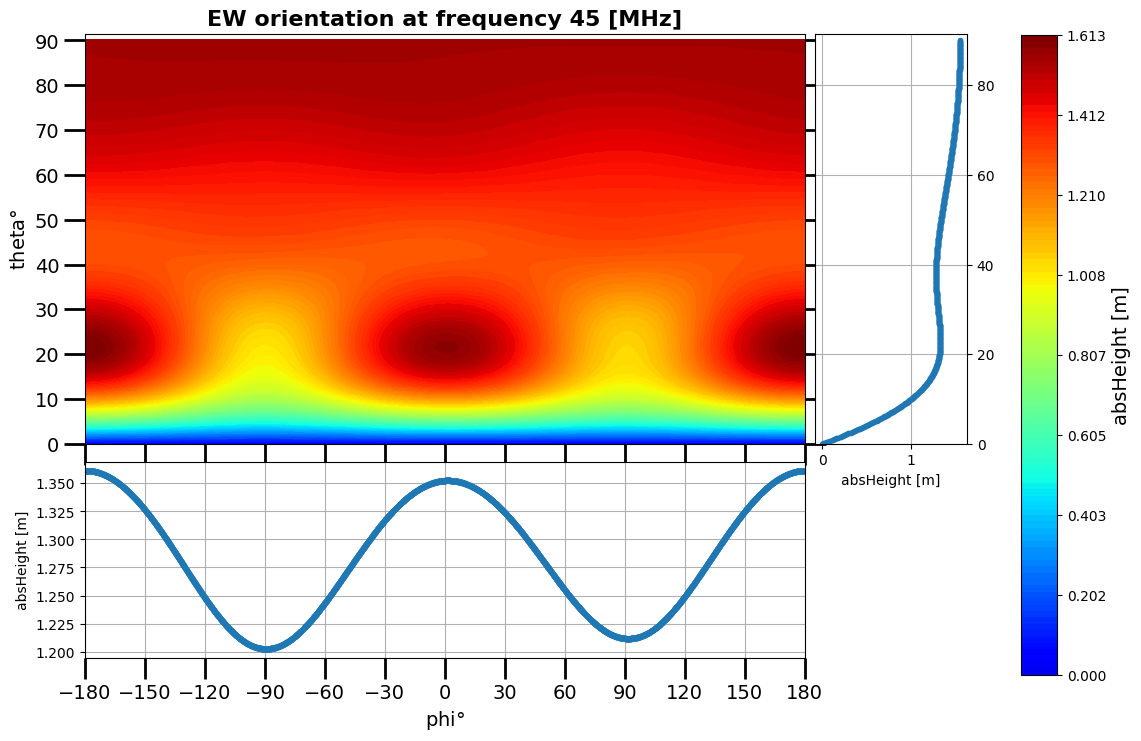

cmap.T:  256
tmins:  3.450431072343851e-11  tmax:  1.5268544229343366  Tstep:  9
cbarTicks:  [3.45043107e-11 1.90856803e-01 3.81713606e-01 5.72570409e-01
 7.63427211e-01 9.54284014e-01 1.14514082e+00 1.33599762e+00
 1.52685442e+00]
Creation of the directory failed (already exists?)
Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/NS_absHeight_45Mhz_thetaInterp_cubic


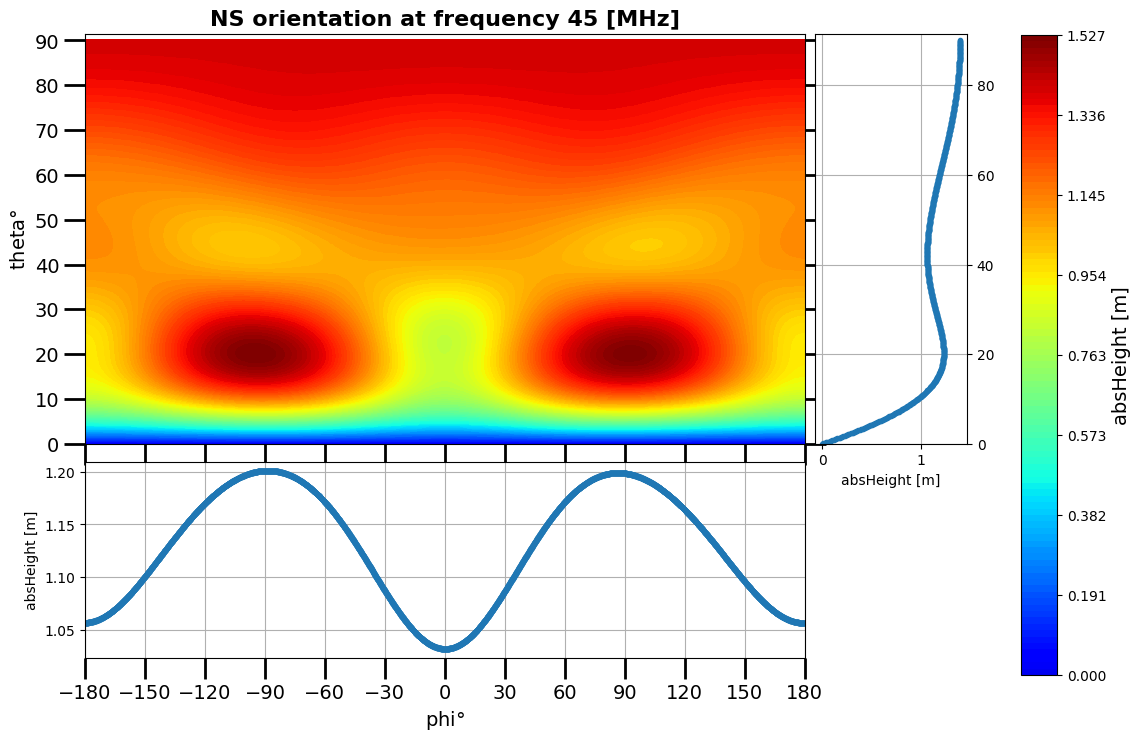

In [26]:
# example,plot antenna pattern quantity for frequency f 
# and change Offline convention to -180 and 180 azimuth with North at 0 and East at 90 degs, West at -90 degs (healpy internal standard)
# and zenith to altitude
# and also interpolated
# and also absolute antenna height

incTheta = 0.1
incPhi = 0.1
newTheta = np.arange(0,90+incTheta,incTheta)
newPhi= np.arange(-180,180+incPhi,incPhi)

# select frequency
frequency=45

# choose quantity
# quantity = 'phi_amp'
# quantity = 'theta_amp'
quantity = 'absHeight'

# select EW orientation
orientation = 'EW'
antenna=antennaEW

close=False
# save=False
save=saveFolder+orientation+"_"+quantity+'_'+str(frequency)+'Mhz'+'_thetaInterp_cubic'

# changeConvention=True,orientation='EW', EW and NS has to be treated differently since both are in Offline align to North
Amp = antenna.get(quantity=quantity,frequency=frequency,changeConvention=True,orientation=orientation,newTheta=newTheta,newPhi=newPhi,kind='cubic')

P, T = np.meshgrid(Amp.index.values.astype(float),Amp.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, Amp.values.T,slices=True, ymax=91.5, xMajorLocator=30,yMajorLocator=10,figureWidth=12,figureHeight=8,
                    xlabel='phi$\degree$',ylabel='theta$\degree$',cbarLabel=quantity+' [m]',
                    mainTitle=orientation+" orientation at frequency "+str(frequency)+' [MHz]',
                    save=save,close=close)

# select NS orientation
orientation = 'NS'
antenna=antennaNS

# save=False
save=saveFolder+orientation+"_"+quantity+'_'+str(frequency)+'Mhz'+'_thetaInterp_cubic'

Amp = antenna.get(quantity=quantity,frequency=frequency,changeConvention=True,orientation=orientation,newTheta=newTheta,newPhi=newPhi,kind='cubic')

P, T = np.meshgrid(Amp.index.values.astype(float),Amp.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, Amp.values.T,slices=True, ymax=91.5, xMajorLocator=30,yMajorLocator=10,figureWidth=12,figureHeight=8,
                    xlabel='phi$\degree$',ylabel='theta$\degree$',cbarLabel=quantity+' [m]',
                    mainTitle=orientation+" orientation at frequency "+str(frequency)+' [MHz]',
                    save=save,close=close)

# Radio sky map simulation part

In [9]:
# healpy as the manipulation tool
import healpy as hp
# the upgraded newvisufunc is not yet in the official release
# current it is a pull request https://github.com/healpy/healpy/pull/648
from healpy import newvisufunc

In [10]:
# import pyGDSM module
sys.path.append("/workdata/LFSS")
from pygdsm import GlobalSkyModel2016, GlobalSkyModel, LowFrequencySkyModel

Import Polisensky's LFmap as a class  (you need to run the script LFmap_healpyFitsConvertorAndGenerator.py inside the LFmap software folder to generate and convert the fits format to healpy fits format).

In [11]:
# import Polisensky's LFmap as a class  (you need to first generate the fits maps with Polisensky's software 
# and then run the conversion script to convert the fits format to healpy fits format)
class LFmap():
    def __init__(self, path):
        self._path=path
    def generate(self,frequency):
        return hp.read_map(self._path+"LFmap_"+str(frequency)+"_healpy.fits",verbose=True)

In [12]:
# for Polisensky's LFmap, these are by default generated in Celestial coordinated
g_LFmap = LFmap("/home/max/auger/soft/LFmap_1.0/healpyFits/")
# for lf map from pygdsem
g_LFSS = LowFrequencySkyModel(freq_unit='MHz')

# Examples
for more examples check the notebook dedicated for this (skyMapExamples)

In [13]:
# generate maps at 45 MHz
map_LFSS = np.log10(g_LFSS.generate(45.0))
map_LFSS_title = "LFSS"
map_LFmap = np.log10(g_LFmap.generate(45.0))
map_LFmap_title = "LFmap"

## -  Maps in Galactic coordinates

mollweide
mollweide


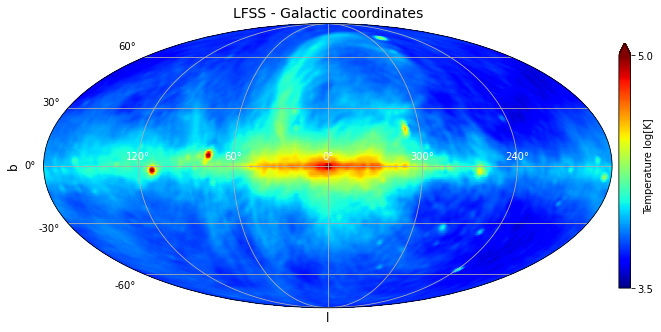

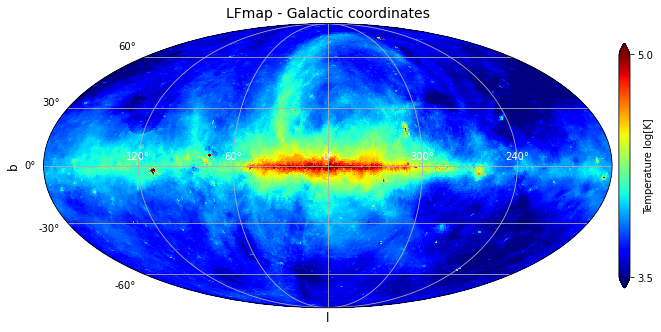

In [14]:
# mollweide projections
newvisufunc.projview(map_LFSS, coord=['G'],graticule=True, graticule_labels=True,
                    unit='Temperature log[K]',xlabel='l',ylabel='b',
                    cb_orientation='vertical',min=3.5,max=5,latitude_grid_spacing=30,
                    projection_type="mollweide",title=map_LFSS_title+" - Galactic coordinates",lcolor='white')

newvisufunc.projview(map_LFmap, coord=['C','G'],graticule=True, graticule_labels=True,
                    unit='Temperature log[K]',xlabel='l',ylabel='b',
                    cb_orientation='vertical',min=3.5,max=5,latitude_grid_spacing=30,
                    projection_type="mollweide",title=map_LFmap_title+" - Galactic coordinates",lcolor='white')

## -  Transformation to Local coordinates system

In [15]:
# rotate the maps to PAO local coordinates at the some particular LST time
# PAO altitude is -35.206667 degs
LSTtime=18
altitude = -35.206667

cart
cart


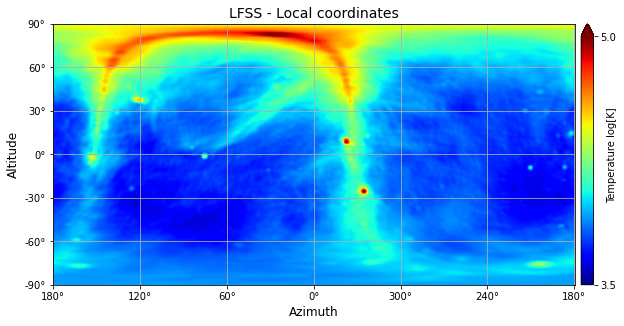

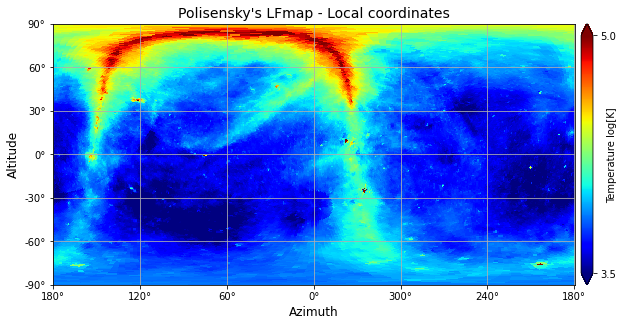

In [16]:
# plot the trasnformed maps
# Local coordinates at LST time "LSTtime" at altitude "altitude"
rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
newvisufunc.projview(map_LFSS,rot=rotAngles, coord=['G','C'],graticule=True, graticule_labels=True,
                    unit='Temperature log[K]',xlabel='Azimuth',ylabel='Altitude',
                    cb_orientation='vertical',min=3.5,max=5,latitude_grid_spacing=30,
                    projection_type="cart",title='LFSS - Local coordinates',lcolor='white')

newvisufunc.projview(map_LFmap, rot=rotAngles, coord=['C'],graticule=True, graticule_labels=True,
                    unit='Temperature log[K]',xlabel='Azimuth',ylabel='Altitude',
                    cb_orientation='vertical',min=3.5,max=5,latitude_grid_spacing=30,
                    projection_type="cart",title="Polisensky's LFmap - Local coordinates",lcolor='white')
#The default is to measure azimuth East from North
# 0 is north 90 is east 180 is souht, 270 is west

## - Data dump and DataFrame creation

In [17]:
# Just an example how to dump data from these maps
# Always check the dump data by plotting them (for example with myPlots.plot3d() function)

# return only data
# [longitude,  latitude, grid_map]
# longitude,  latitude are 1D arrays to convert them to 2D arrays for the plot use np.meshgrid(longitude,  latitude)
# longtitude goes from -pi to pi (-180 to 180 in degs)
# latitude goes from -pi/2 to pi/2 (-90 to 90 in degs)
# generate maps at 45 MHz
# do not log this here!
map_LFSS = g_LFSS.generate(45.0)
map_LFSS_title = "LFSS"
map_LFmap = g_LFmap.generate(45.0)
map_LFmap_title = "LFmap"

rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
longitude_LFSS,  latitude_LFSS, grid_map_LFSS = newvisufunc.projview(map_LFSS, rot=rotAngles, coord=['G','C'],
                                                      return_only_data=True)
longitude_LFmap,  latitude_LFmap, grid_map_LFmap = newvisufunc.projview(map_LFmap, rot=rotAngles, coord=['C'],
                                                      return_only_data=True)
print(longitude_LFmap.shape)
print(latitude_LFmap.shape)
print(grid_map_LFmap.shape)

(1000,)
(500,)
(500, 1000)


In [18]:
# this function helps to convert the data dump from newvisufunc.projview() to DF
def convert2SkyDF(data_dump,full=False):
    def DFtemplateCreator(xs,ys,yName=None):
        colList = [str(x) for x in xs]
        nan_init = np.empty((len(xs),len(ys),))
        nan_init[:]=np.nan
        templateDF = pd.DataFrame(nan_init.T, columns = colList)
        templateDF.insert(0,yName,ys)
        templateDF = templateDF.set_index(yName)
        return templateDF
    longitude,latitude,grid_map = data_dump
    latitudeDeg = np.rad2deg(latitude)
    longitudeDeg = np.rad2deg(longitude)
    skyMapDF = DFtemplateCreator(latitudeDeg,longitudeDeg,yName=None)
    skyMapDF.iloc[:,:] = grid_map.T
    if full is False:
        skyMapDF = skyMapDF.iloc[:,np.where(skyMapDF.columns.astype(float) >=0)[0].tolist()]
    skyMapDF=skyMapDF.sort_index()
    return skyMapDF

In [19]:
# for map from LFmap, these are by default generated in Celestial coordinated
model = {"LFmap": LFmap("/home/max/auger/soft/LFmap_1.0/healpyFits/"), "LFSM": LowFrequencySkyModel(freq_unit='MHz'), "GSM": GlobalSkyModel(freq_unit='MHz'), "GSM16": GlobalSkyModel2016(freq_unit='MHz')}
model_title = {"LFmap": "LFmap", "LFSM": "LFSM", "GSM": "GSM2008", "GSM16": "GSM2016"}
g_model_coord = {"LFmap": ['C','G'], "LFSM": ['G'], "GSM": ['G'], "GSM16": ['G']}
c_model_coord = {"LFmap": ['C'], "LFSM": ['G','C'], "GSM": ['G','C'], "GSM16": ['G','C']}
model_scale = {"LFmap": 256, "LFSM": 16, "GSM": 4, "GSM16": 1}

#choose sky models from: LFmap, LFSM, GSM, GSM16
key1 = "LFmap"
key2 = "GSM"

g_1 = model[key1]
g_2 = model[key2]
g_coord_1 = g_model_coord[key1]
g_coord_2 = g_model_coord[key2]
c_coord_1 = c_model_coord[key1]
c_coord_2 = c_model_coord[key2]
model_scale_1 = model_scale[key1]
model_scale_2 = model_scale[key2]

In [20]:
# generate sky maps
frequency = 30.0
map_1 = g_1.generate(frequency)
map_1_title = model_title[key1]
map_2 = g_2.generate(frequency)
map_2_title = model_title[key2]
# dump maps in Galactic coordinate system
dumpG_1 = newvisufunc.projview(map_1,coord=g_coord_1, return_only_data=True)
dumpG_2 = newvisufunc.projview(map_2,coord=g_coord_2, return_only_data=True)
# then convert the data dump to DataFrame
# set full=True to have full Y axis
GskyMapDF_1=convert2SkyDF(dumpG_1,full=True)
GskyMapDF_2=convert2SkyDF(dumpG_2,full=True)

cmap.T:  256
tmins:  3.5  tmax:  5  Tstep:  9
cbarTicks:  [3.5    3.6875 3.875  4.0625 4.25   4.4375 4.625  4.8125 5.    ]
Creation of the directory failed (already exists?)
Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/GskyMapDF_LFmap_30_0


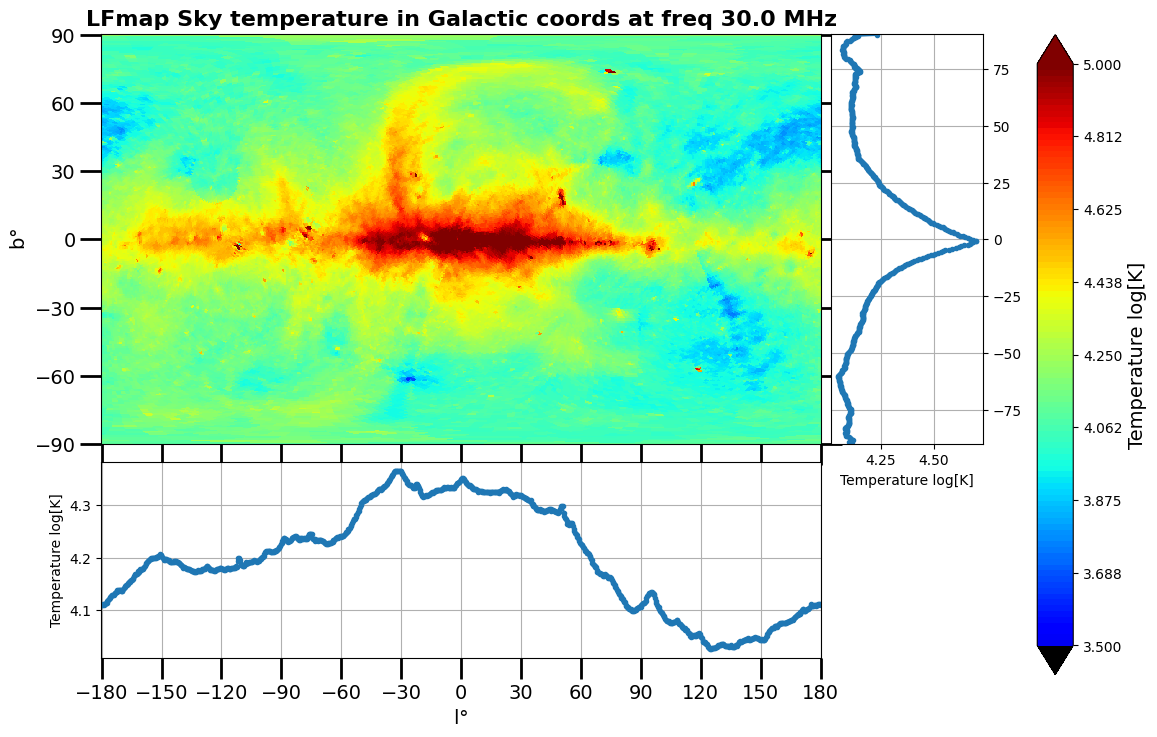

cmap.T:  256
tmins:  3.5  tmax:  5  Tstep:  9
cbarTicks:  [3.5    3.6875 3.875  4.0625 4.25   4.4375 4.625  4.8125 5.    ]
Creation of the directory failed (already exists?)
Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/GskyMapDF_GSM2008_30_0


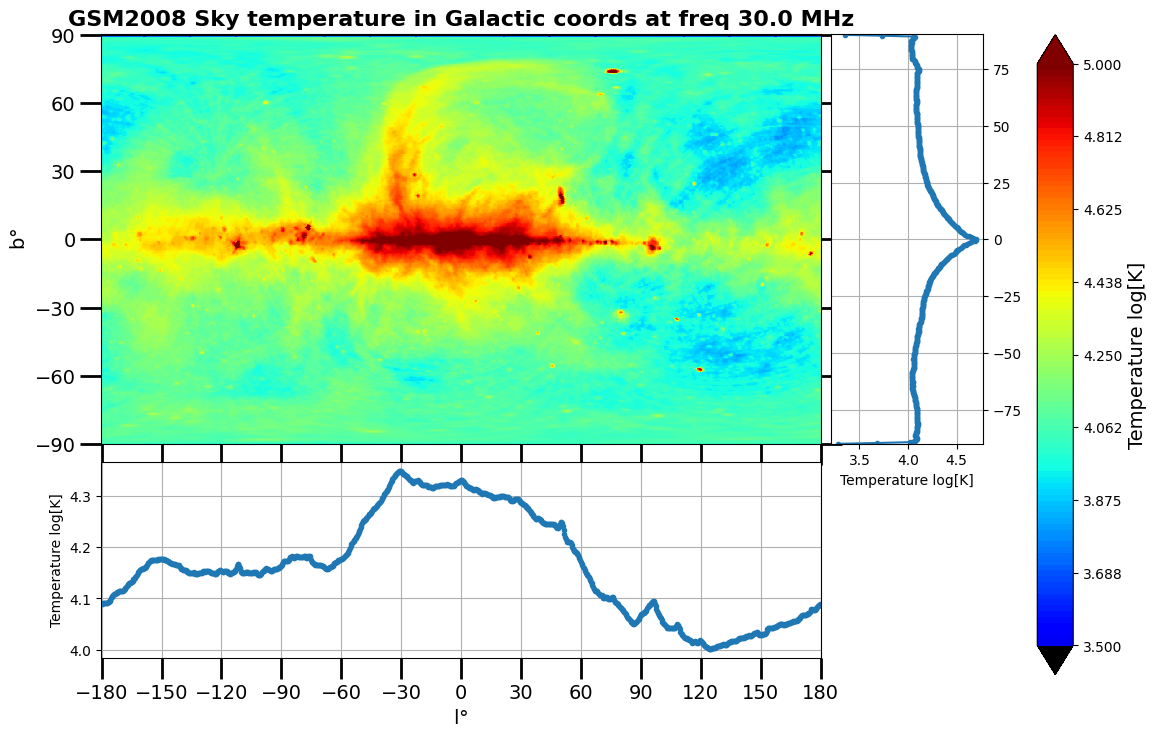

cmap.T:  256
tmins:  0  tmax:  2  Tstep:  9
cbarTicks:  [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/Ratio_GskyMapDF_LFmap-GskyMapDF_GSM2008_30_0


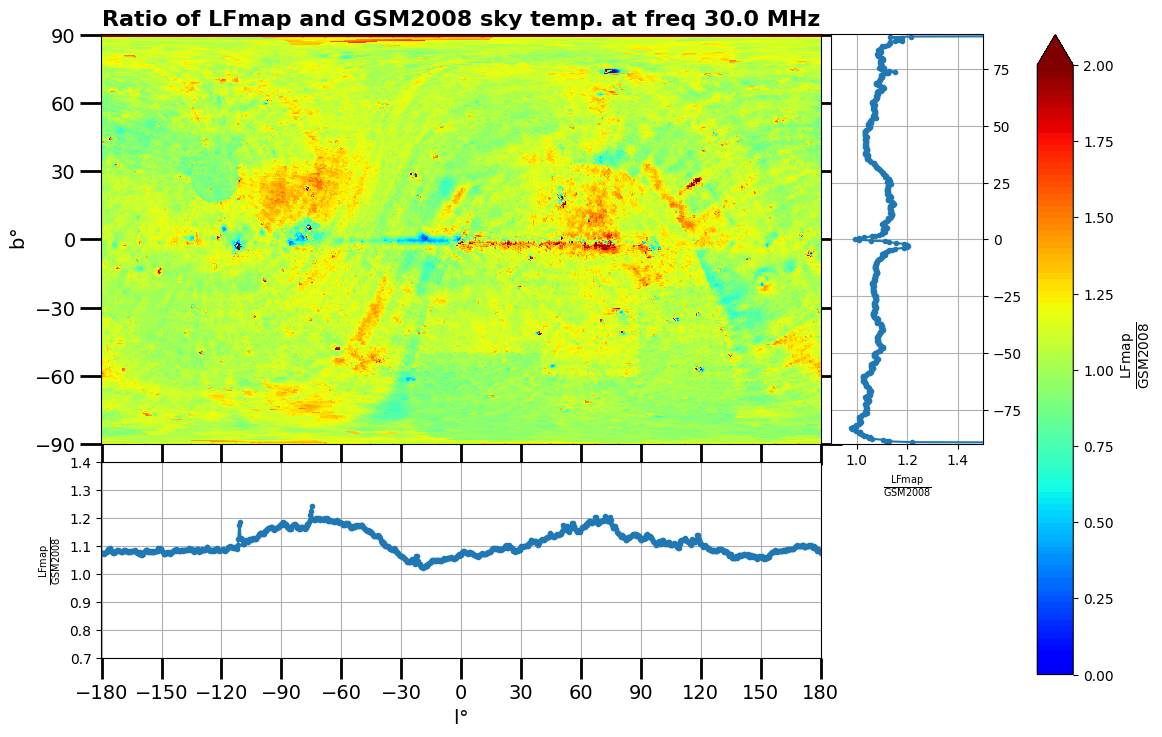

cmap.T:  256
tmins:  -945688.050479419  tmax:  1155861.8839966347  Tstep:  9
cbarTicks:  [-945688.05047942 -682994.30866991 -420300.56686041 -157606.8250509
  105086.91675861  367780.65856811  630474.40037762  893168.14218713
 1155861.88399663]
Creation of the directory failed (already exists?)
Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/nonAbs_Difference_GskyMapDF_LFmap-GskyMapDF_GSM2008_30_0


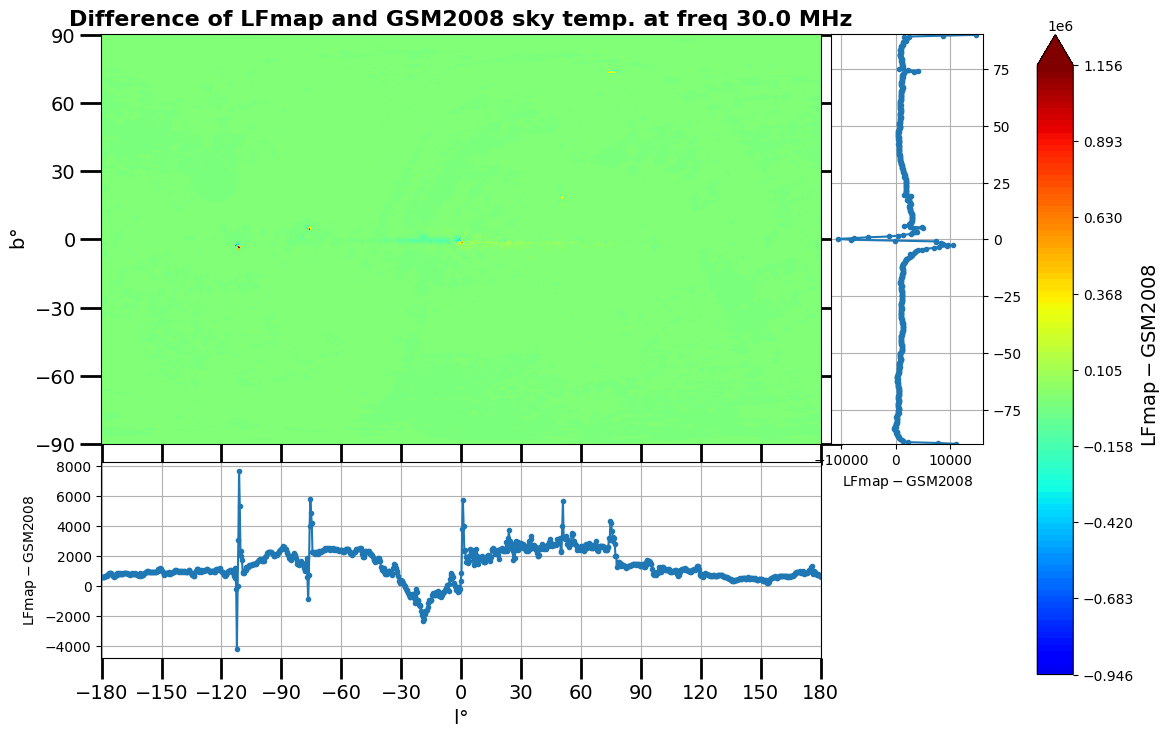

In [21]:
P, T = np.meshgrid(GskyMapDF_1.index.values.astype(float),GskyMapDF_1.columns.values.astype(float))

save=False
save1=saveFolder+"GskyMapDF_"+map_1_title+'_'+str(frequency).replace('.','_')
save2=saveFolder+"GskyMapDF_"+map_2_title+'_'+str(frequency).replace('.','_')
save3=saveFolder+"Ratio_GskyMapDF_"+map_1_title+"-GskyMapDF_"+map_2_title+"_"+str(frequency).replace('.','_')
save4=saveFolder+"nonAbs_Difference_GskyMapDF_"+map_1_title+"-GskyMapDF_"+map_2_title+'_'+str(frequency).replace('.','_')

# log here!
myPlots.plot3dnewV3(P, T, np.log10(GskyMapDF_1.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=30,figureWidth=12,figureHeight=8,
                    xlabel='l$\degree$',ylabel='b$\degree$',cbarLabel='Temperature log[K]',
                    mainTitle=map_1_title+" Sky temperature in Galactic coords at freq "+str(frequency)+' MHz',Cmin=3.5,Cmax=5,extend='both',
                    save=save1,close=close)

P, T = np.meshgrid(GskyMapDF_2.index.values.astype(float),GskyMapDF_2.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, np.log10(GskyMapDF_2.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=30,figureWidth=12,figureHeight=8,
                    xlabel='l$\degree$',ylabel='b$\degree$',cbarLabel='Temperature log[K]',
                    mainTitle=map_2_title+" Sky temperature in Galactic coords at freq "+str(frequency)+' MHz',Cmin=3.5,Cmax=5,extend='both',
                    save=save2,close=close)

ratio=GskyMapDF_1.values.T/GskyMapDF_2.values.T
P, T = np.meshgrid(GskyMapDF_1.index.values.astype(float),GskyMapDF_1.columns.values.astype(float))
myPlots.plot3dnewV4(P, T, ratio,
                    slices=True, ymax=90.5, Ax_ylim=(0.7,1.4), Ay_xlim=(0.9,1.5), xMajorLocator=30,yMajorLocator=30,figureWidth=12,figureHeight=8,
                    xlabel='l$\degree$',ylabel='b$\degree$',cbarLabel=r'$\frac{\mathrm{%s}}{\mathrm{%s}}$'%(map_1_title, map_2_title),
                    mainTitle="Ratio of "+map_1_title+" and "+map_2_title+" sky temp. at freq "+str(frequency)+' MHz',Cmin=0,Cmax=2,extend='max',
                    save=save3,close=close)

difference=GskyMapDF_1.values.T-GskyMapDF_2.values.T
P, T = np.meshgrid(GskyMapDF_1.index.values.astype(float),GskyMapDF_1.columns.values.astype(float))
myPlots.plot3dnewV3(P, T, difference,
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=30,figureWidth=12,figureHeight=8,
                    xlabel='l$\degree$',ylabel='b$\degree$',cbarLabel=r'${\mathrm{%s}}-{\mathrm{%s}}$'%(map_1_title, map_2_title),
                    mainTitle="Difference of "+map_1_title+" and "+map_2_title+" sky temp. at freq "+str(frequency)+' MHz',extend='max',
                    save=save4,close=close)

## - Compare the LFSS map with the Polisensky's LFmap at Local Coordinates

In [22]:
# rotate the maps to PAO local coordinates at the some particular LST time
# PAO altitude is -35.206667 degs
LSTtime=18
altitude = -35.206667

In [27]:
# first generate the data dump
rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
dump_1 = newvisufunc.projview(map_1,rot=rotAngles, coord=c_coord_1,
                                                      return_only_data=True,xsize=newPhi.size)
dump_2 = newvisufunc.projview(map_2,rot=rotAngles, coord=c_coord_2,
                                                      return_only_data=True,xsize=newPhi.size)
# then convert the data dump to DataFrame
LskyMapDF_1=convert2SkyDF(dump_1,full=False)
LskyMapDF_2=convert2SkyDF(dump_2,full=False)

cmap.T:  256
tmins:  3.5  tmax:  5  Tstep:  9
cbarTicks:  [3.5    3.6875 3.875  4.0625 4.25   4.4375 4.625  4.8125 5.    ]
Creation of the directory failed (already exists?)
Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/LskyMapDF_LFmap


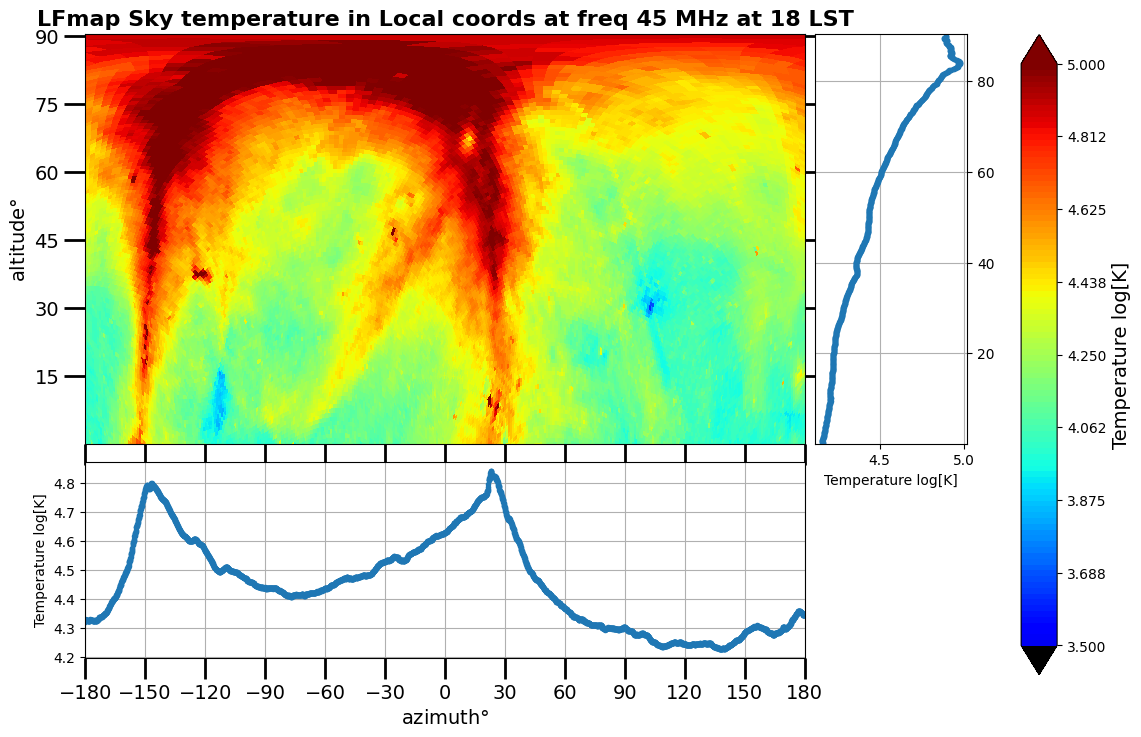

cmap.T:  256
tmins:  3.5  tmax:  5  Tstep:  9
cbarTicks:  [3.5    3.6875 3.875  4.0625 4.25   4.4375 4.625  4.8125 5.    ]
Creation of the directory failed (already exists?)
Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/LskyMapDF_GSM2008


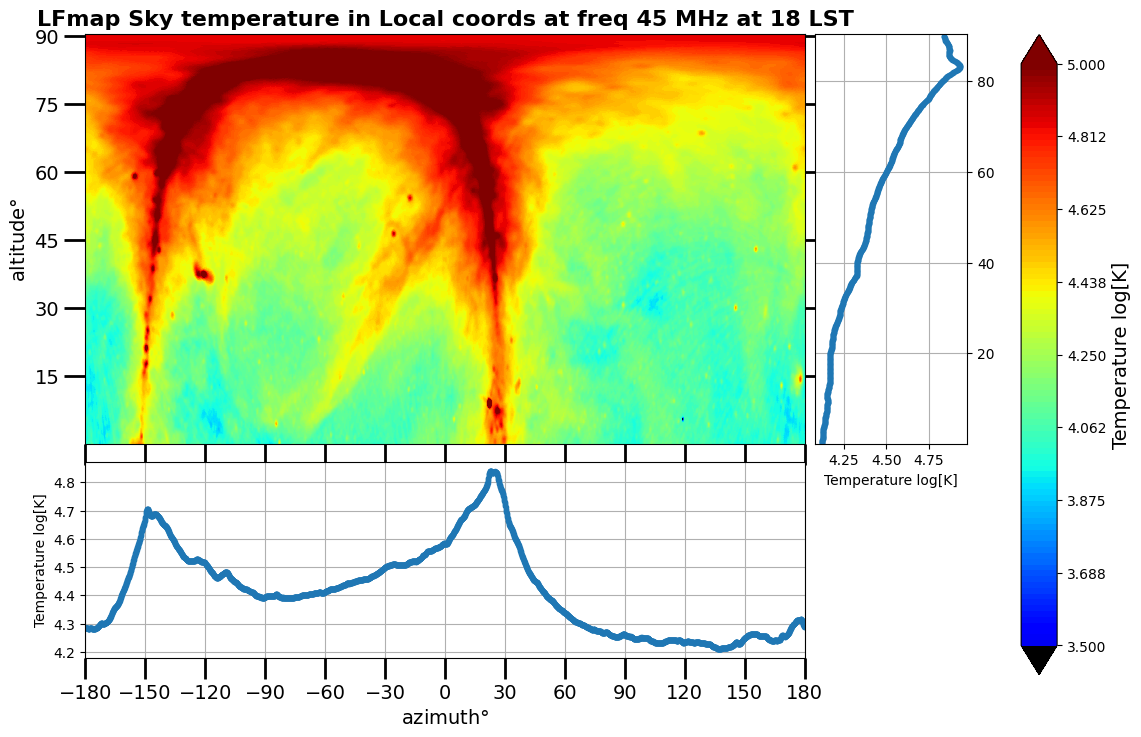

cmap.T:  256
tmins:  0  tmax:  2  Tstep:  9
cbarTicks:  [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
Creation of the directory failed (already exists?)
Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/Ratio_LskyMapDF_LFmap-LskyMapDF_GSM2008


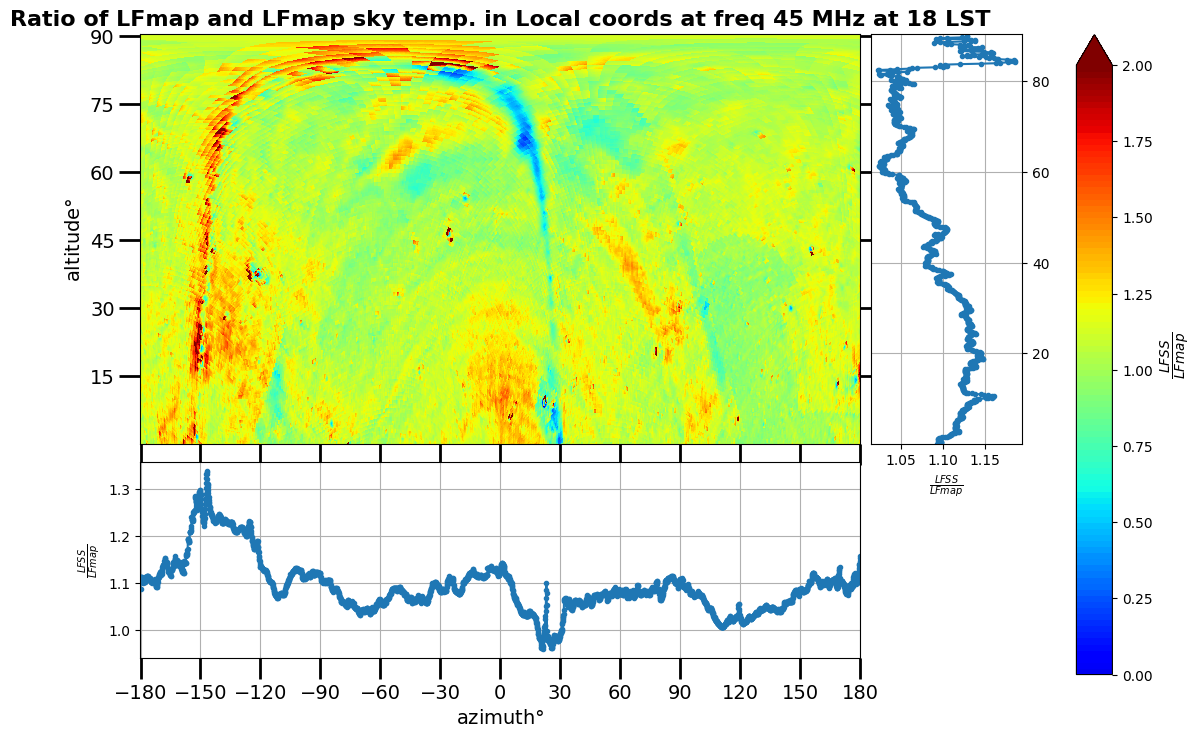

In [28]:
P, T = np.meshgrid(LskyMapDF_1.index.values.astype(float),LskyMapDF_1.columns.values.astype(float))

save=False
save1=saveFolder+"LskyMapDF_"+map_1_title
save2=saveFolder+"LskyMapDF_"+map_2_title
save3=saveFolder+"Ratio_LskyMapDF_"+map_1_title+"-LskyMapDF_"+map_2_title

# log here!
myPlots.plot3dnewV3(P, T, np.log10(LskyMapDF_1.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15,figureWidth=12,figureHeight=8,
                    xlabel='azimuth$\degree$',ylabel='altitude$\degree$',cbarLabel='Temperature log[K]',extend='both',
                    mainTitle=map_1_title+" Sky temperature in Local coords at freq "+str(frequency)+' MHz at '+str(LSTtime)+" LST",Cmin=3.5,Cmax=5,
                    save=save1,close=close)

myPlots.plot3dnewV3(P, T, np.log10(LskyMapDF_2.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15,figureWidth=12,figureHeight=8,
                    xlabel='azimuth$\degree$',ylabel='altitude$\degree$',cbarLabel='Temperature log[K]',extend='both',
                    mainTitle=map_1_title+" Sky temperature in Local coords at freq "+str(frequency)+' MHz at '+str(LSTtime)+" LST",Cmin=3.5,Cmax=5,
                    save=save2,close=close)

ratio=LskyMapDF_1.values.T/LskyMapDF_2.values.T
myPlots.plot3dnewV3(P, T, ratio,
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15,figureWidth=12,figureHeight=8,
                    xlabel='azimuth$\degree$',ylabel='altitude$\degree$',cbarLabel=r'$\frac{LFSS}{LFmap}$',
                    mainTitle="Ratio of "+map_1_title+" and "+map_1_title+" sky temp. in Local coords at freq "+str(frequency)+' MHz at '+str(LSTtime)+" LST"
                    ,Cmin=0,Cmax=2,extend='max', save=save3,close=close)

In [35]:
# integrate the folded sky map over the angles
def integrateOverAngles(foldedAntennaSkyMap):
    p = np.deg2rad(foldedAntennaSkyMap.index.values.astype(float))
    t = np.deg2rad(foldedAntennaSkyMap.columns.values.astype(float))
    T, P = np.meshgrid(t, p)
    angePrefactor=np.cos(T[:,::-1])
    #angePrefactor=1
    integratedOverAngles=simps(simps(foldedAntennaSkyMap*angePrefactor,t),p)
    return integratedOverAngles

In [106]:
# rotate them to Local coordinates at some particular LST time
LSTtime = 18
altitude = -35.206667
# generate sky maps
frequency_range = np.linspace(30.0,80.0,6)
average_T_G, average_T_L = {},{}

for model_key in model:
    g = model[model_key]
    map_title = model_title[model_key]
    T_G_temp,T_L_temp = [],[]
    for freq in frequency_range:
        map = g.generate(freq)
        # first generate the data dump
        dumpG = newvisufunc.projview(map,coord=g_model_coord[model_key], return_only_data=True)

        # then convert the data dump to DataFrame
        # set full=True to have full Y axis
        GskyMapDF=convert2SkyDF(dumpG,full=True)
        print(model_key, freq)
        T_G_temp.append(integrateOverAngles(GskyMapDF)/integrateOverAngles(GskyMapDF/GskyMapDF))
        T_hour = []
        for hour in np.arange(0,24):
            rotAngles=[(180+(hour*15))%360,-(altitude-90)]
            dump = newvisufunc.projview(map,rot=rotAngles, coord=c_model_coord[model_key], return_only_data=True,xsize=newPhi.size)
            LskyMapDF=convert2SkyDF(dump,full=False)
            T_hour.append(integrateOverAngles(LskyMapDF)/integrateOverAngles(LskyMapDF/LskyMapDF))
        T_L_temp.append(np.mean(T_hour))
    average_T_G[model_key] = np.array(T_G_temp)
    average_T_L[model_key] = np.array(T_L_temp)

LFmap 30.0
LFmap 40.0
LFmap 50.0
LFmap 60.0
LFmap 70.0
LFmap 80.0
LFSM 30.0
LFSM 40.0
LFSM 50.0
LFSM 60.0
LFSM 70.0
LFSM 80.0
GSM 30.0
GSM 40.0
GSM 50.0
GSM 60.0
GSM 70.0
GSM 80.0
GSM16 30.0
GSM16 40.0
GSM16 50.0
GSM16 60.0
GSM16 70.0
GSM16 80.0


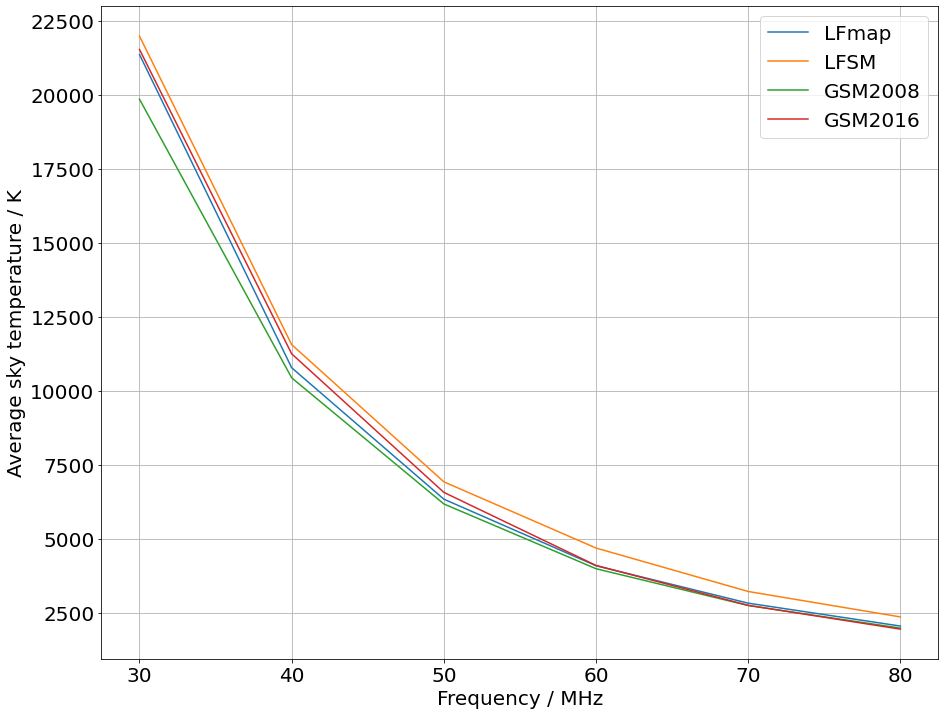

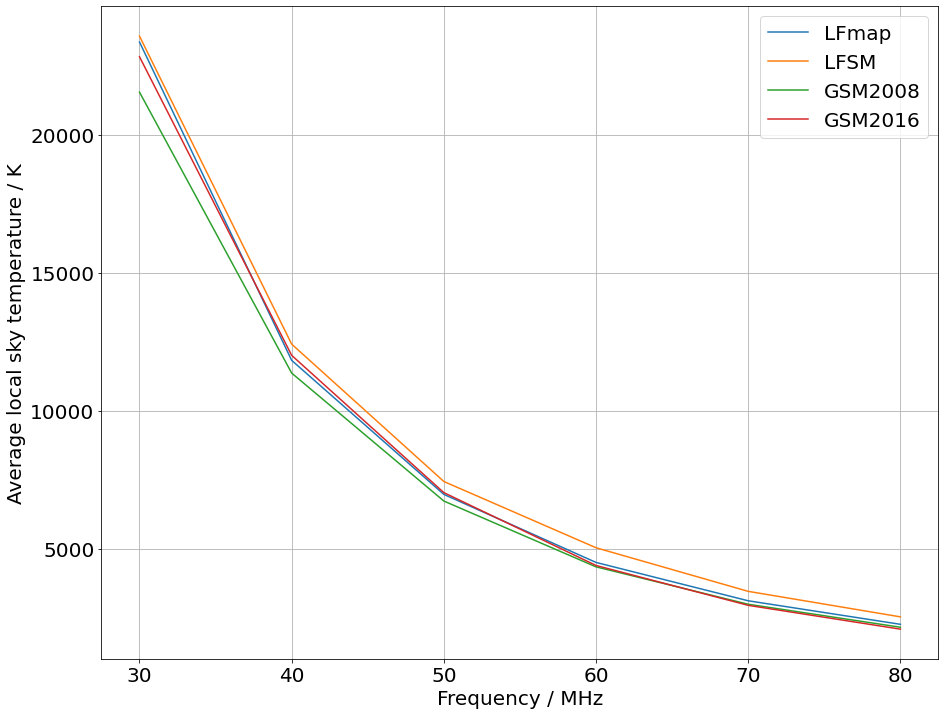

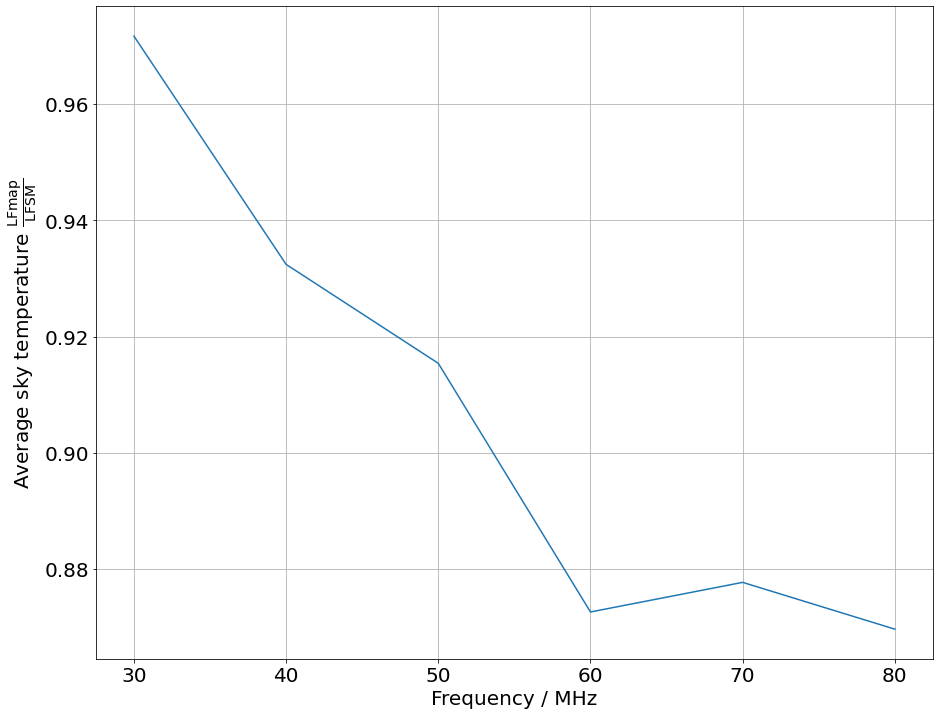

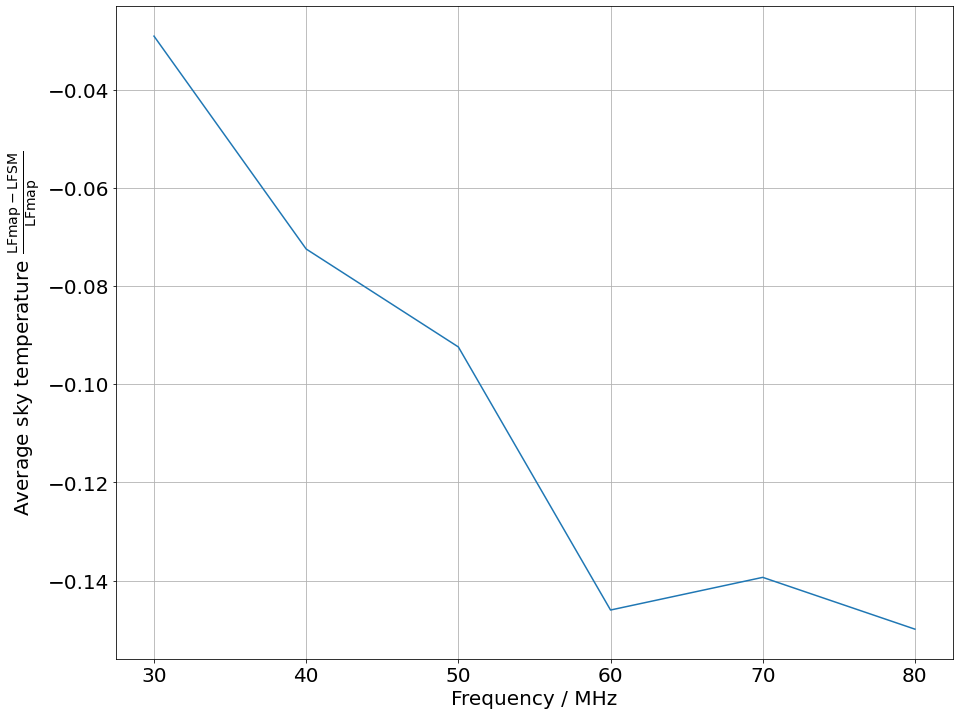

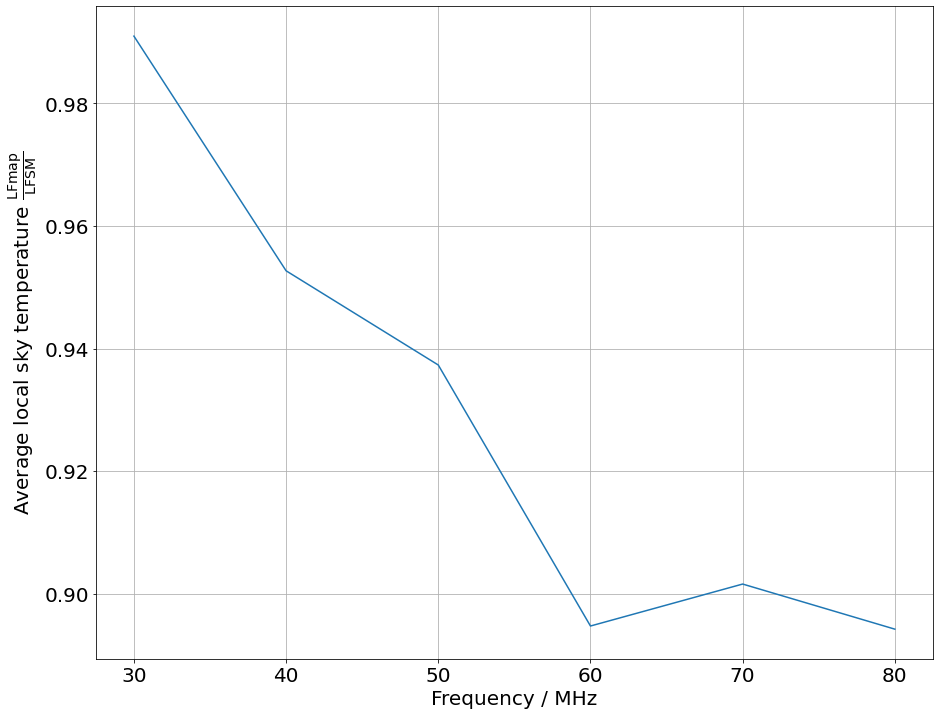

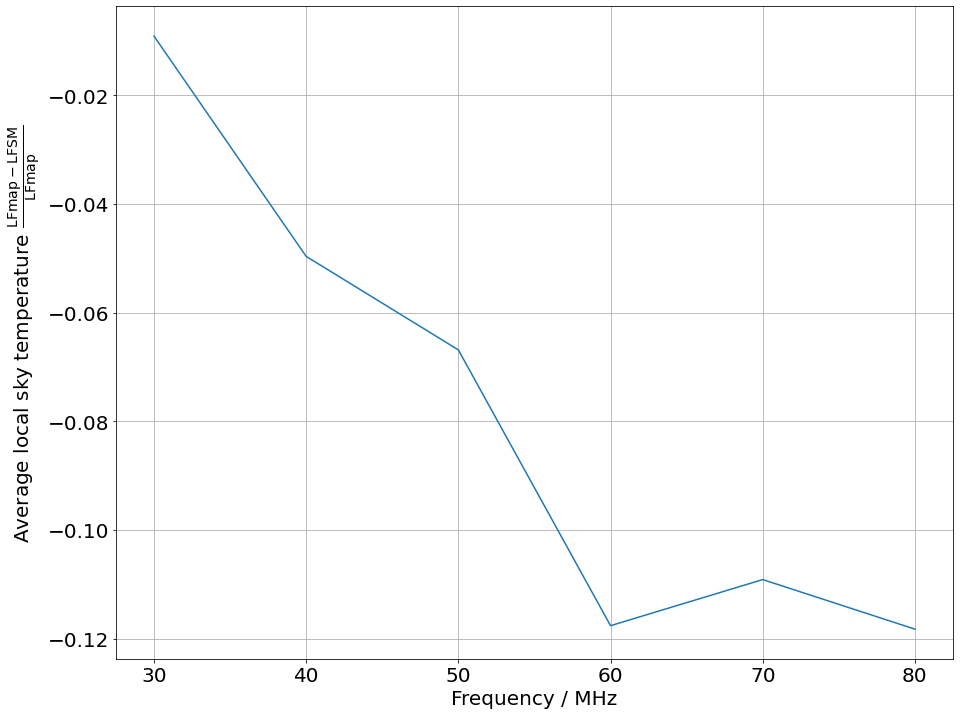

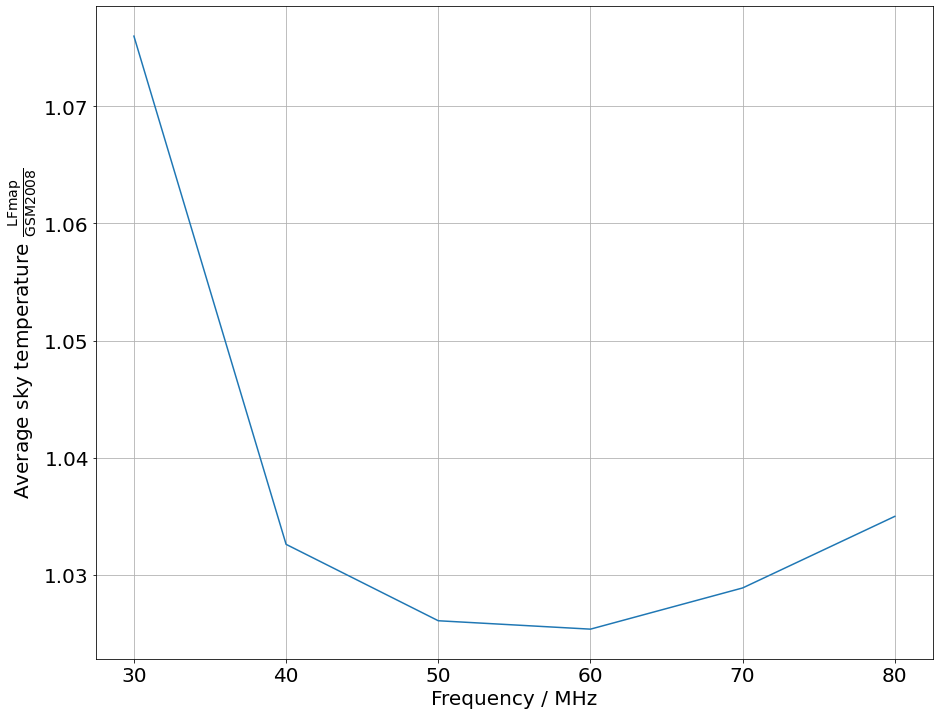

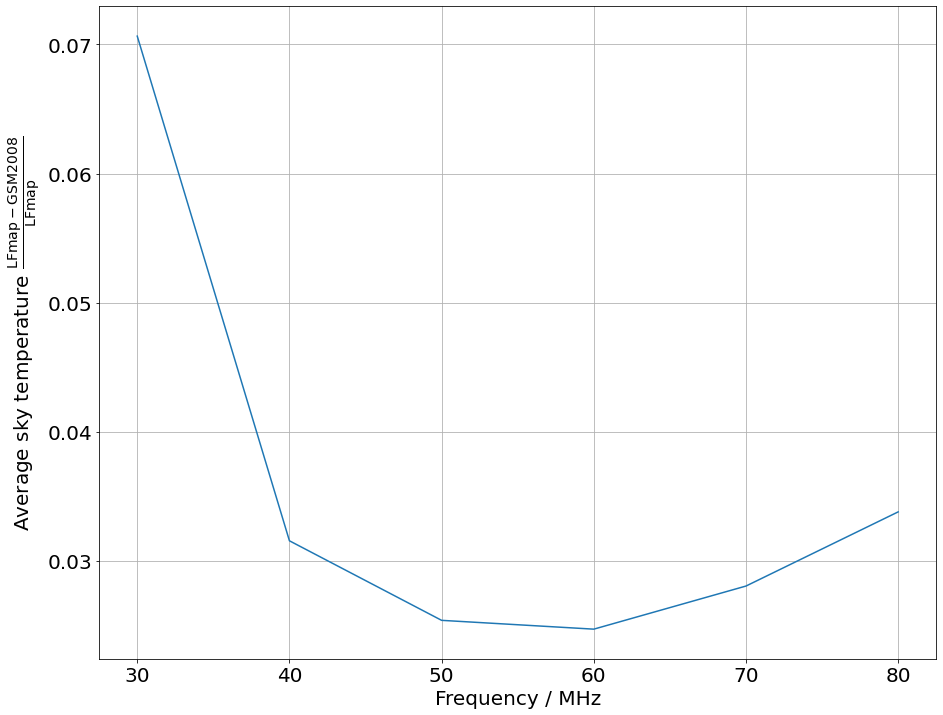

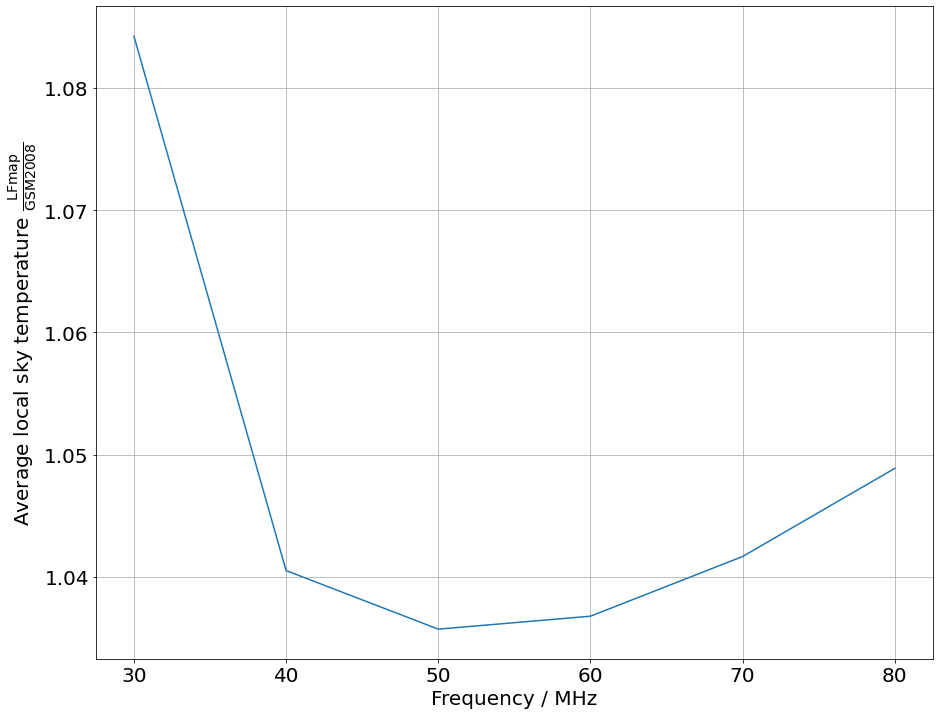

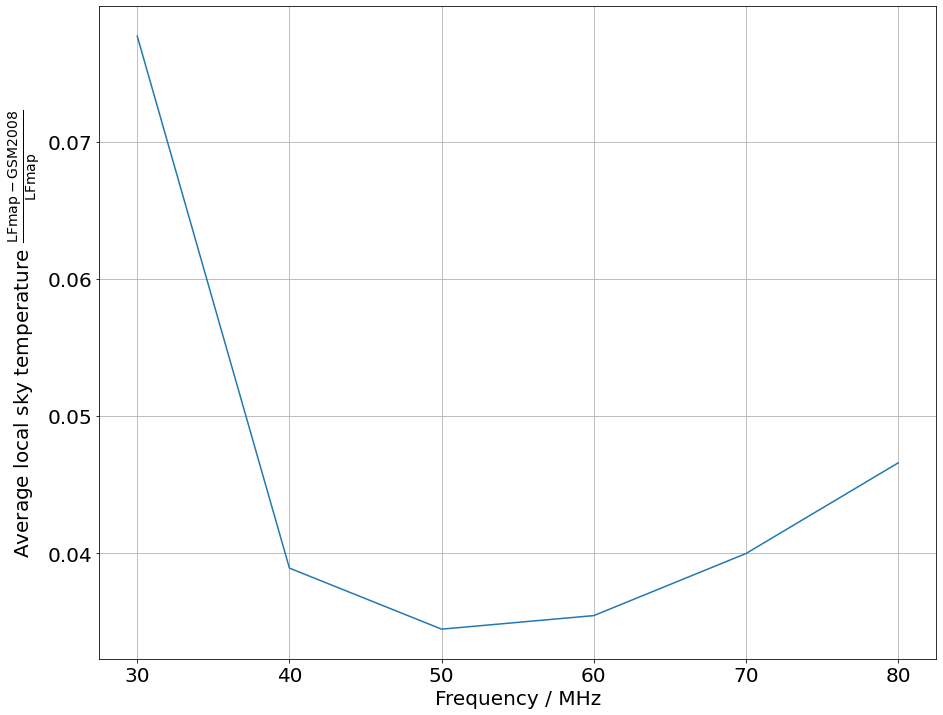

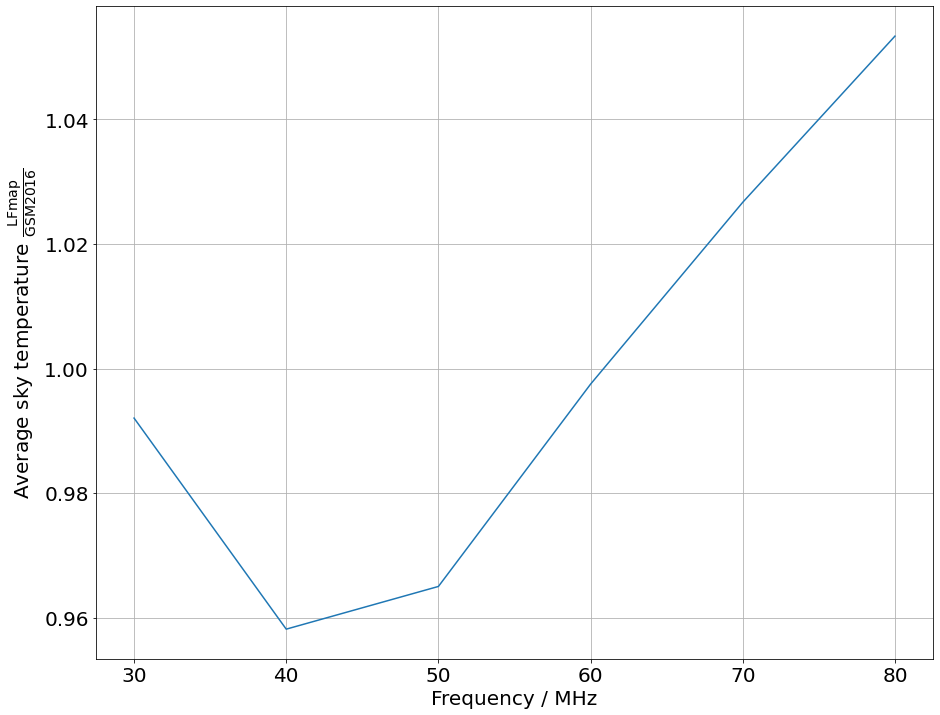

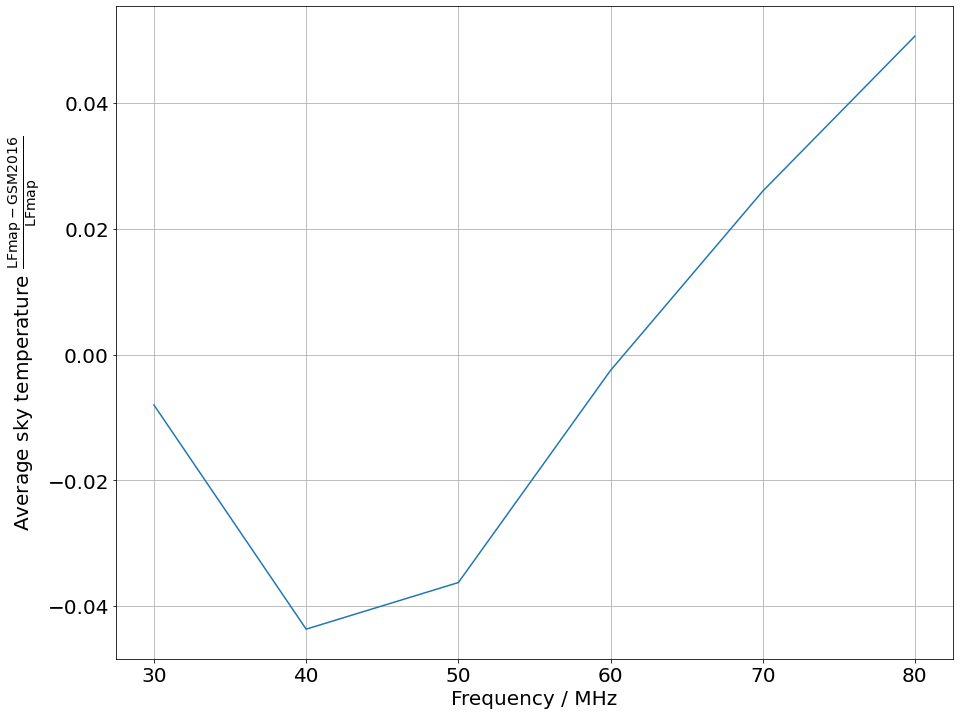

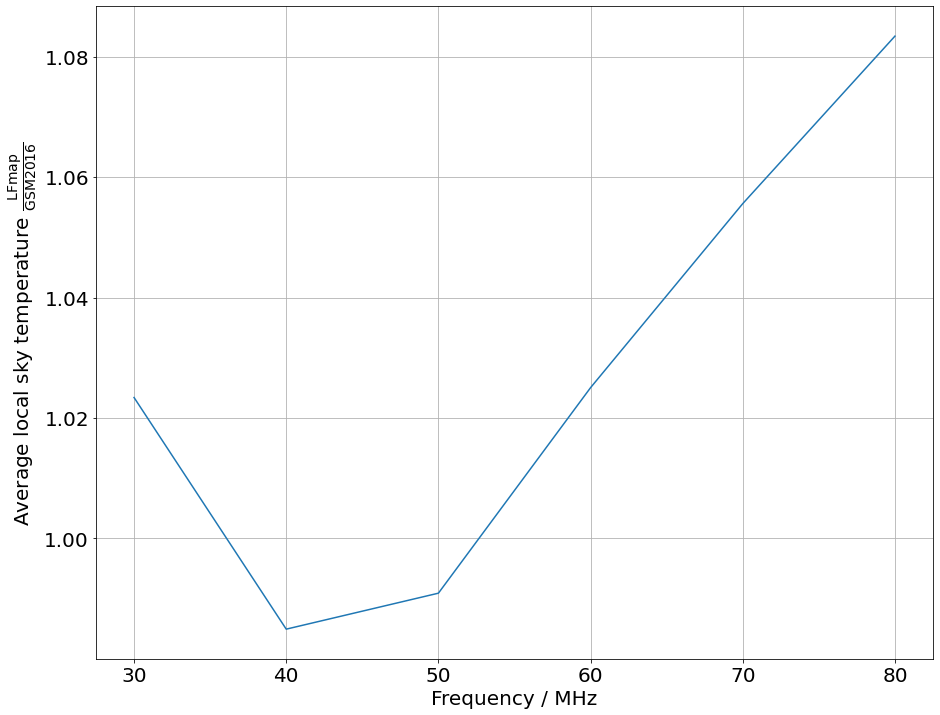

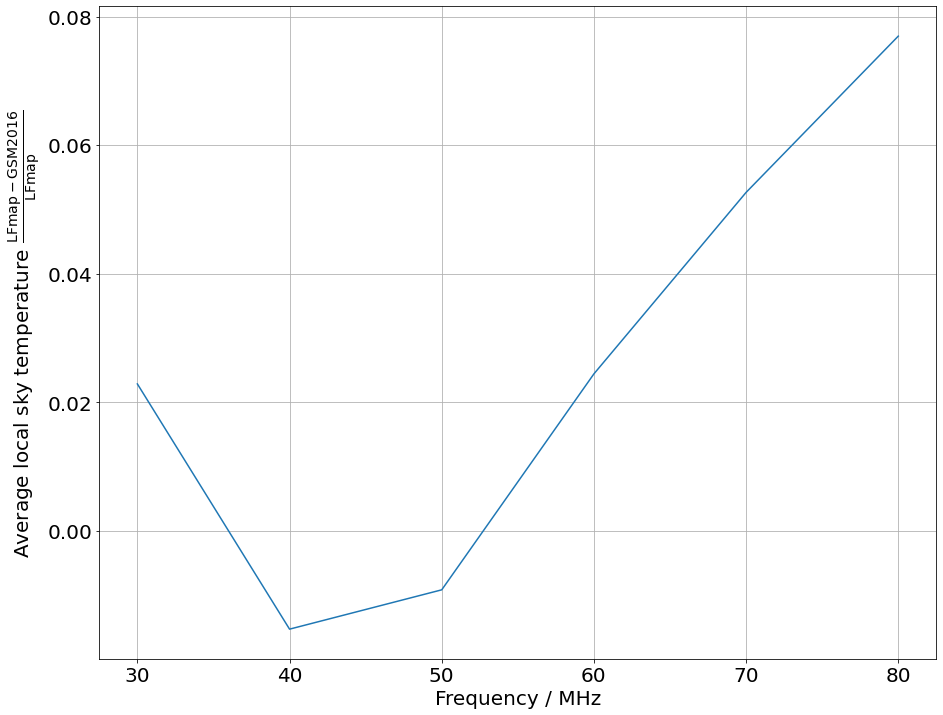

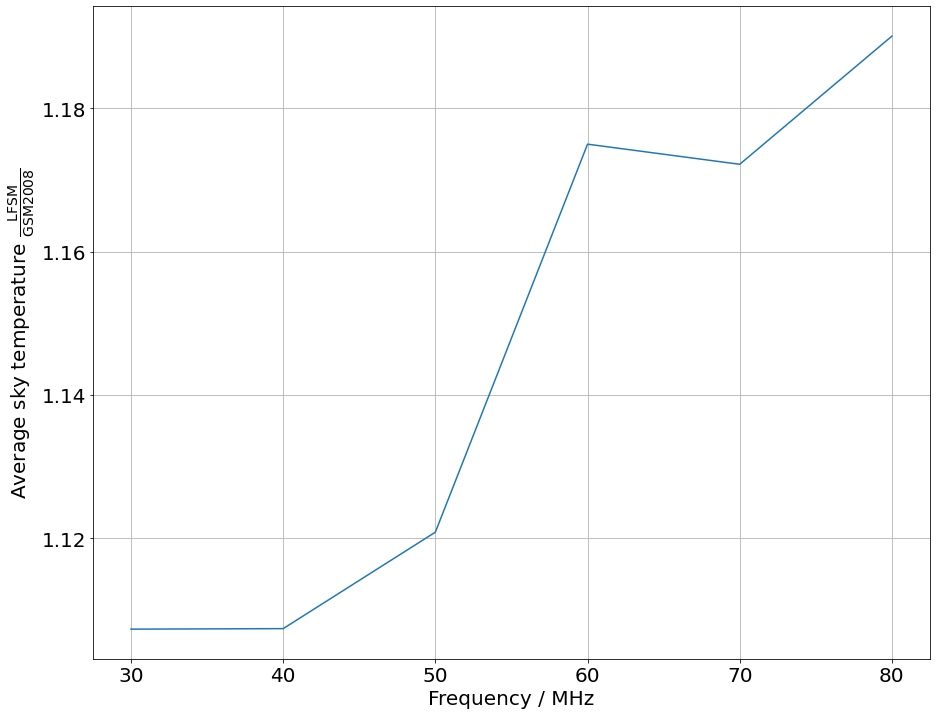

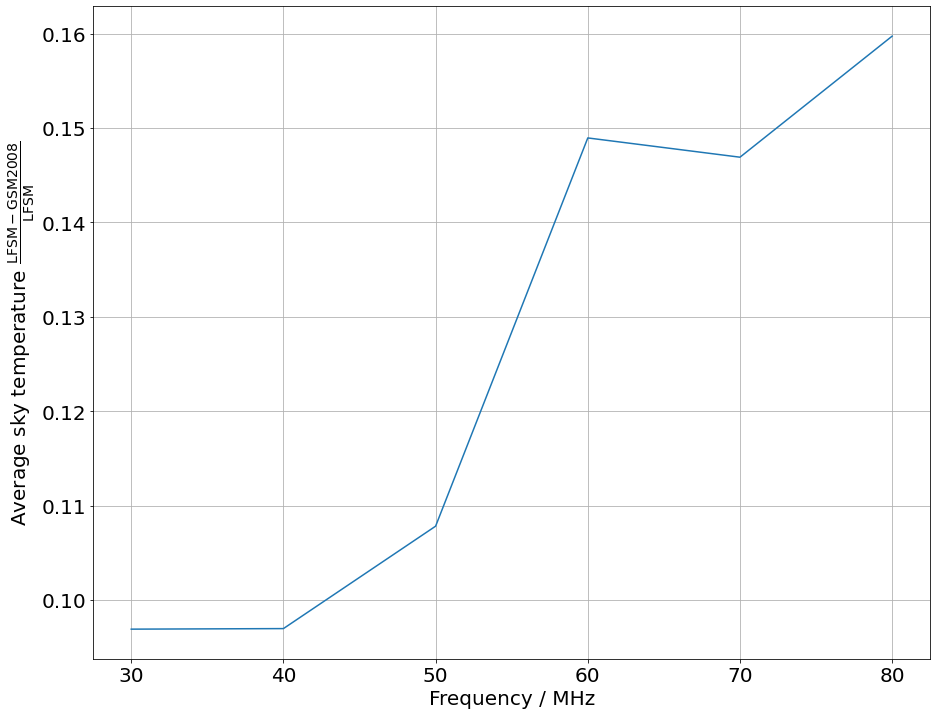

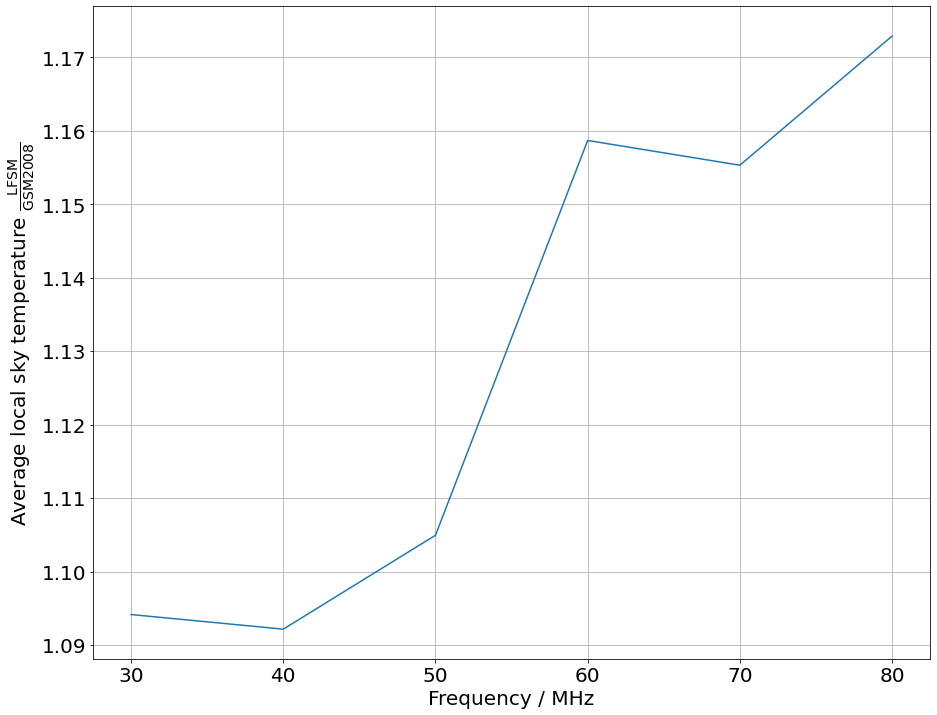

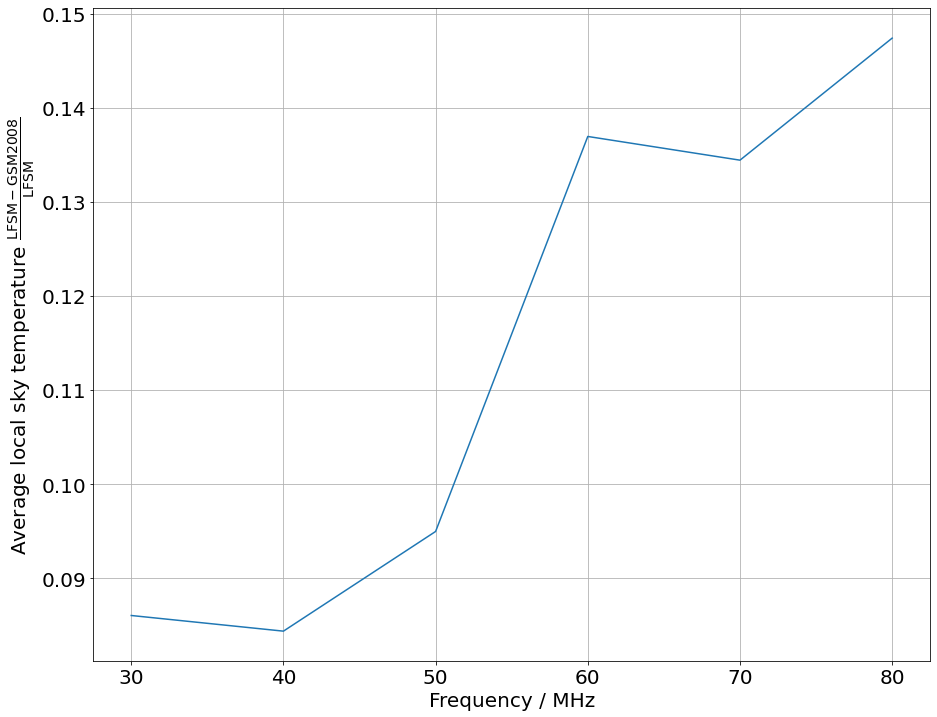

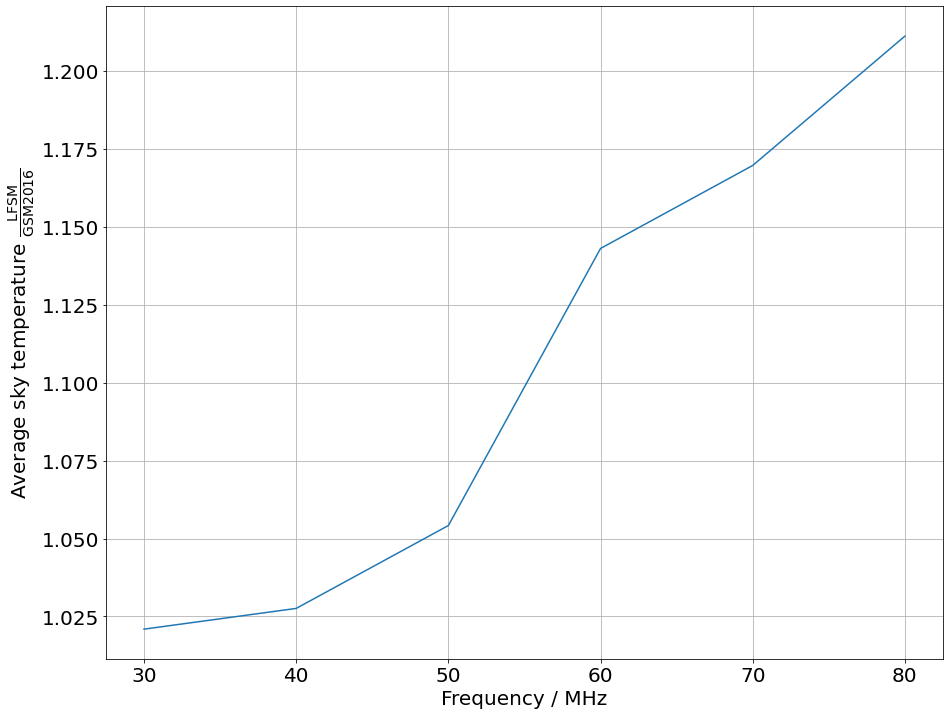

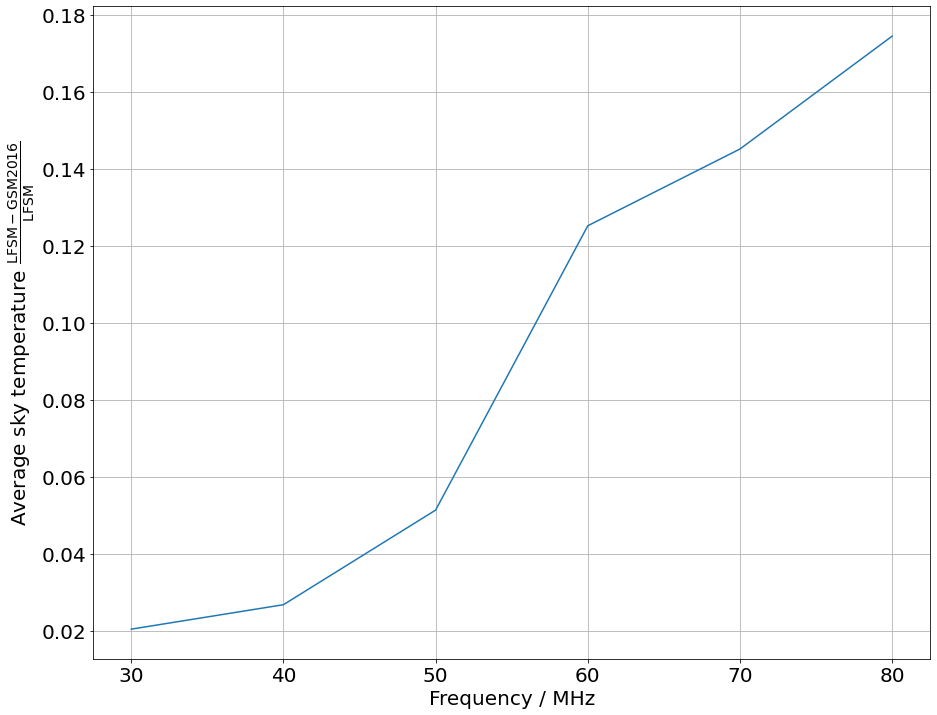

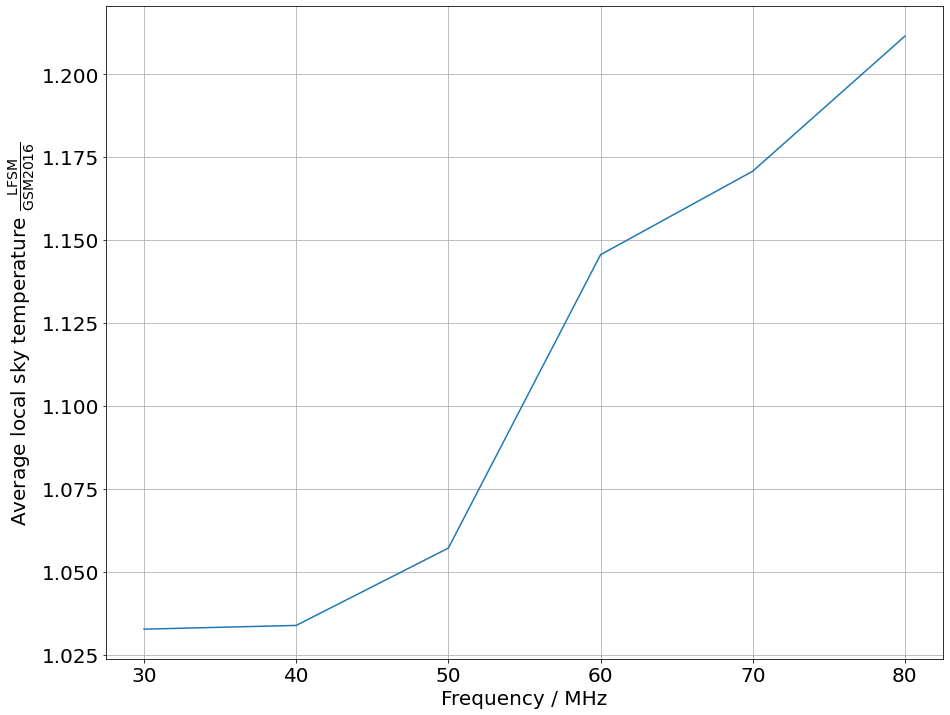

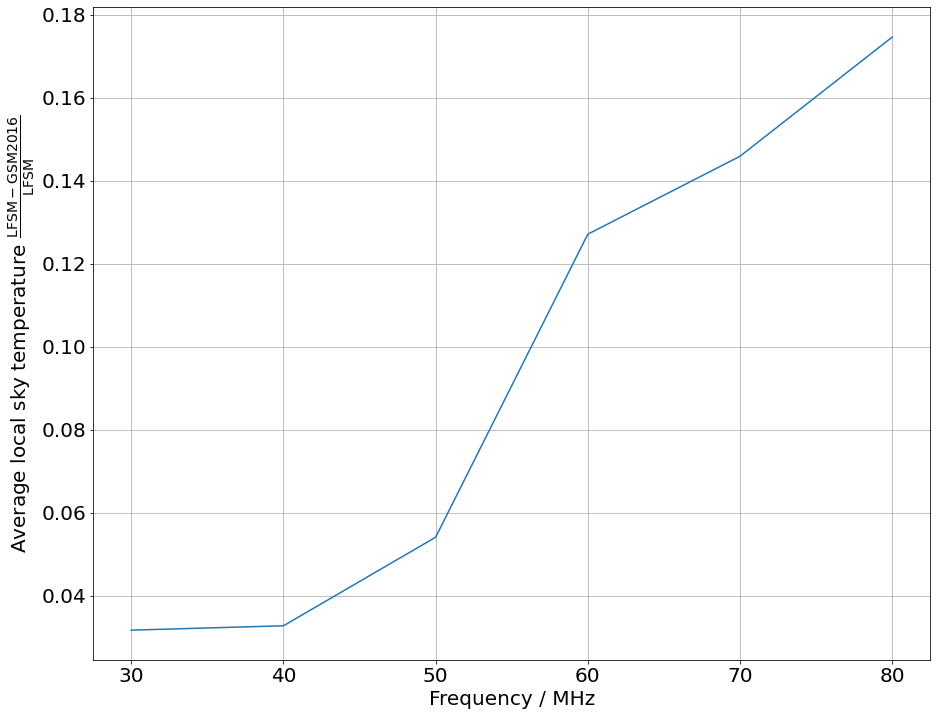

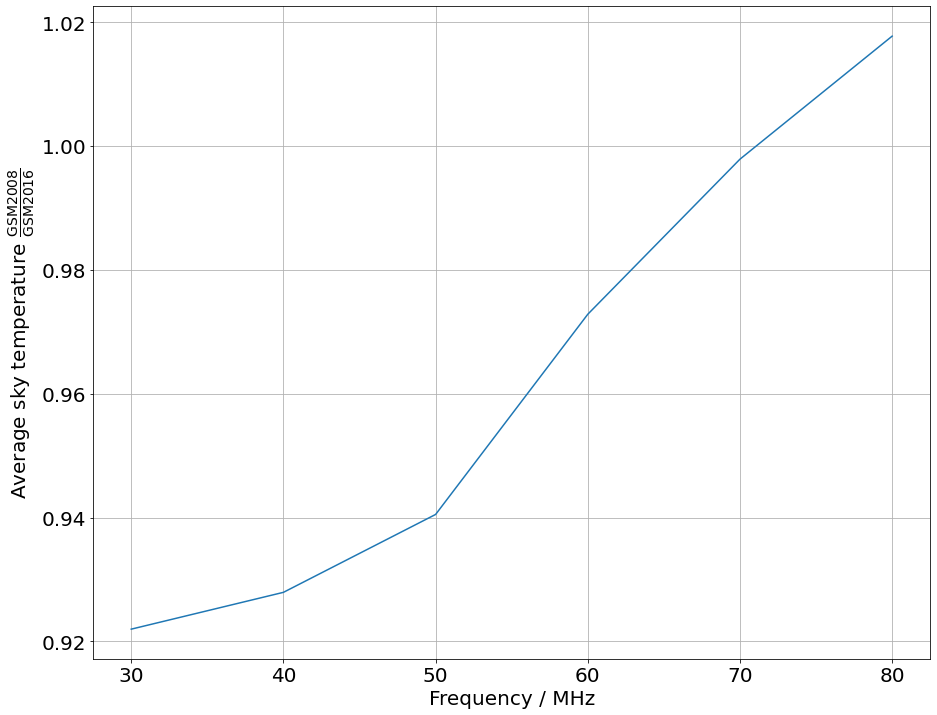

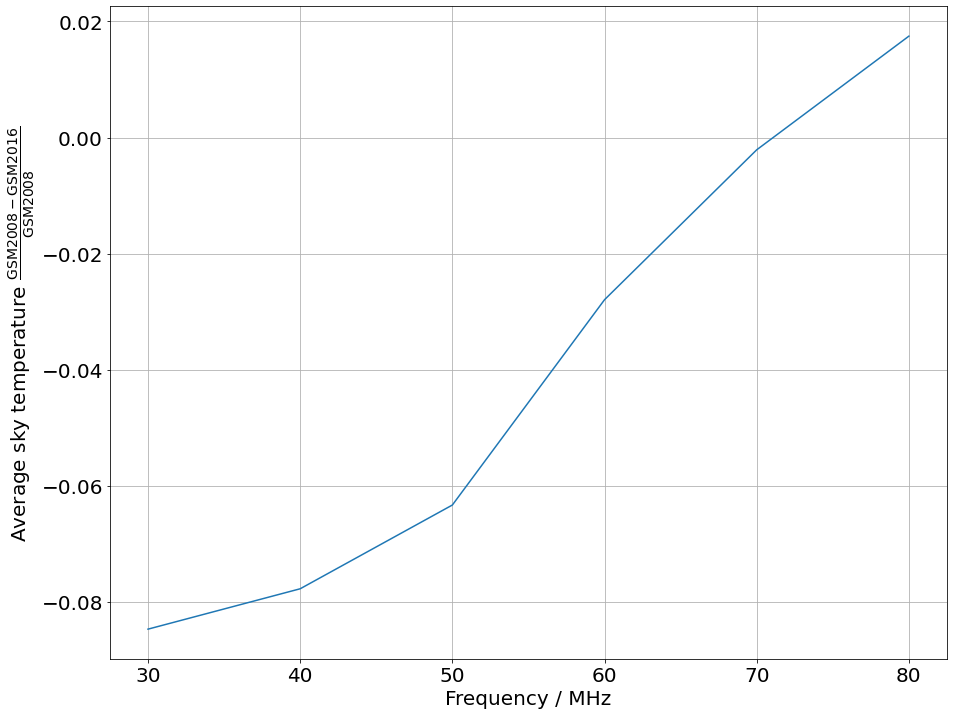

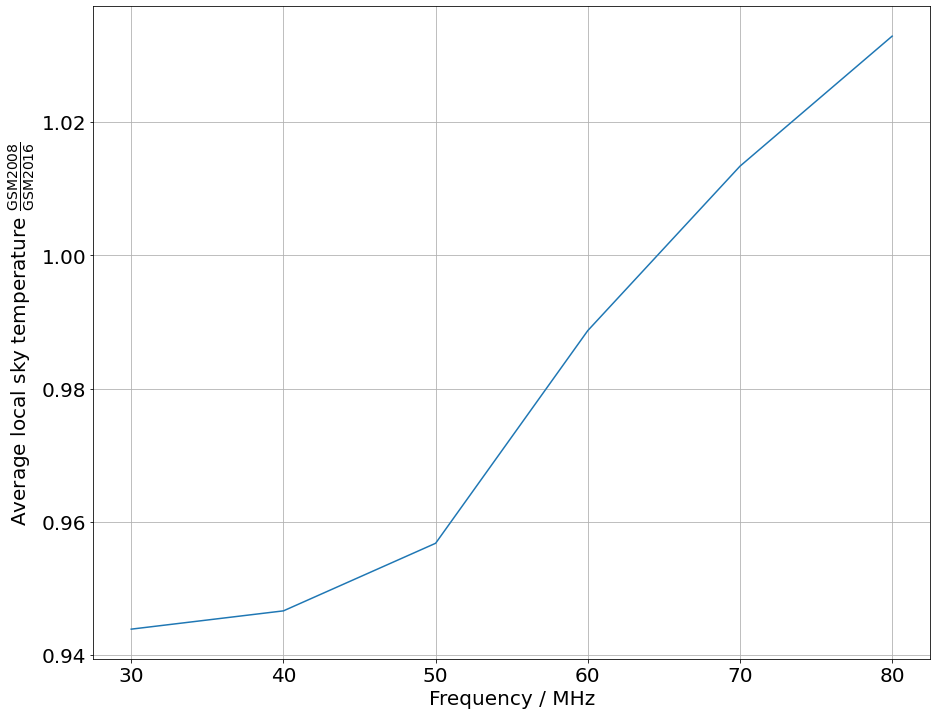

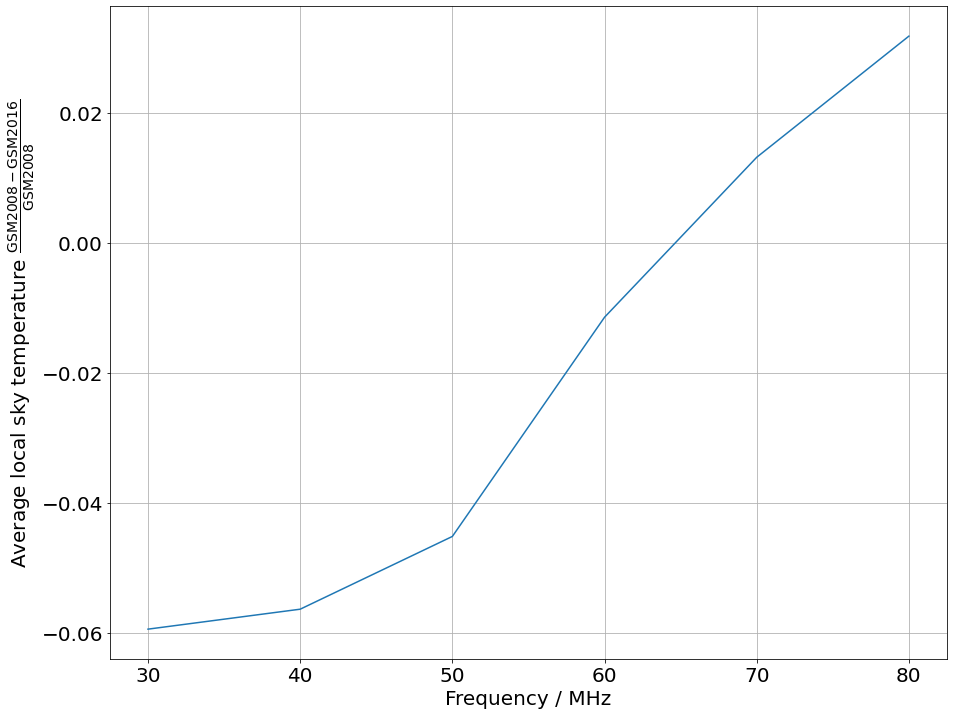

In [107]:
#Plot average sky temperature
plt.figure()
for model_key in model:
    plt.plot(frequency_range,average_T_G[model_key],label=model_title[model_key])
plt.xlabel('Frequency / MHz')
plt.ylabel('Average sky temperature / K')
plt.legend()
plt.grid(True)
plt.savefig(saveFolder+'AverageSkyTemperature/All_models.png', facecolor='white', bbox_inches='tight')
plt.show()

#Plot average local sky temperature
plt.figure()
for model_key in model:
    plt.plot(frequency_range,average_T_L[model_key],label=model_title[model_key])
plt.xlabel('Frequency / MHz')
plt.ylabel('Average local sky temperature / K')
plt.legend()
plt.grid(True)
plt.savefig(saveFolder+'AverageSkyTemperature/All_models_local.png', facecolor='white', bbox_inches='tight')
plt.show()

for (m_1,m_2) in it.combinations(model,2):
    #Plot ratio of average sky temperature for two models
    plt.figure()
    plt.plot(frequency_range,average_T_G[m_1]/average_T_G[m_2])
    plt.xlabel('Frequency / MHz')
    plt.ylabel(r'Average sky temperature $\frac{\mathrm{%s}}{\mathrm{%s}}$'%(model_title[m_1],model_title[m_2]))
    plt.grid(True)
    plt.savefig(saveFolder+'AverageSkyTemperature/Ratio_model_'+model_title[m_1]+'_'+model_title[m_2]+'.png', facecolor='white', bbox_inches='tight')
    plt.show()
    
    #Plot difference of average sky temperature for two models
    plt.figure()
    plt.plot(frequency_range,(average_T_G[m_1]-average_T_G[m_2])/average_T_G[m_1])
    plt.xlabel('Frequency / MHz')
    plt.ylabel(r'Average sky temperature $\frac{\mathrm{%s-%s}}{\mathrm{%s}}$'%(model_title[m_1],model_title[m_2],model_title[m_1]))
    plt.grid(True)
    plt.savefig(saveFolder+'AverageSkyTemperature/Difference_model_'+model_title[m_1]+'_'+model_title[m_2]+'.png', facecolor='white', bbox_inches='tight')
    plt.show()
    
    #Plot ratio of average local sky temperature for two models
    plt.figure()
    plt.plot(frequency_range,average_T_L[m_1]/average_T_L[m_2])
    plt.xlabel('Frequency / MHz')
    plt.ylabel(r'Average local sky temperature $\frac{\mathrm{%s}}{\mathrm{%s}}$'%(model_title[m_1],model_title[m_2]))
    plt.grid(True)
    plt.savefig(saveFolder+'AverageSkyTemperature/Ratio_model_'+model_title[m_1]+'_'+model_title[m_2]+'_local.png', facecolor='white', bbox_inches='tight')
    plt.show()
    
    #Plot difference of average local sky temperature for two models
    plt.figure()
    plt.plot(frequency_range,(average_T_L[m_1]-average_T_L[m_2])/average_T_L[m_1])
    plt.xlabel('Frequency / MHz')
    plt.ylabel(r'Average local sky temperature $\frac{\mathrm{%s-%s}}{\mathrm{%s}}$'%(model_title[m_1],model_title[m_2],model_title[m_1]))
    plt.grid(True)
    plt.savefig(saveFolder+'AverageSkyTemperature/Difference_model_'+model_title[m_1]+'_'+model_title[m_2]+'_local.png', facecolor='white', bbox_inches='tight')
    plt.show()    

# Antenna pattern and sky temperature folding part

In [123]:
from scipy import constants
from scipy.integrate import simps

In [124]:
#skyMapDF = skyMapDF_LFSS
def foldSkyWithAntenna(antenna, frequency=None,orientation=None,skyMapDF=None):
    quantity = 'absHeight'
    p = skyMapDF.index.values.astype(float)
    t = skyMapDF.columns.values.astype(float)
    Amp = antenna.get(quantity=quantity,frequency=frequency,newTheta=t,newPhi=p,kind='cubic',changeConvention=True,
                      orientation=orientation)
    foldedAntennaSkyMap = Amp**2*skyMapDF
    return foldedAntennaSkyMap

In [127]:
frequency = 45.0
# first generate maps at some frequeny
map_1 = g_1.generate(frequency)
map_2 = g_2.generate(frequency)
# rotate them to Local coordinates at some particular LST time
LSTtime = 18
altitude = -35.206667

/home/max/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 64
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/max/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/max/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [128]:
# first convert the data dump to DF and then use the folding function
foldedAntennaSkyMap_1 = foldSkyWithAntenna(antenna, frequency=frequency,orientation='EW',skyMapDF=convert2SkyDF(dump_1,full=False))
foldedAntennaSkyMap_2 = foldSkyWithAntenna(antenna, frequency=frequency,orientation='EW',skyMapDF=convert2SkyDF(dump_2,full=False))
orientation='EW'

In [129]:
rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
dump_1 = newvisufunc.projview(map_1,rot=rotAngles, coord=c_coord_1,return_only_data=True,xsize=1439)
dump_2 = newvisufunc.projview(map_2,rot=rotAngles, coord=c_coord_2, return_only_data=True,xsize=1439)

## Plot Example of squared antenna pattern convoluted with sky temperature

cmap.T:  256
tmins:  3.25  tmax:  5.3  Tstep:  9
cbarTicks:  [3.25    3.50625 3.7625  4.01875 4.275   4.53125 4.7875  5.04375 5.3    ]
Creation of the directory failed (already exists?)


/home/max/auger/soft/galactic_calibration/sky_maps/myPlots.py:1377: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/foldedAntennaSkyMap_LFmap_EW_LST_18


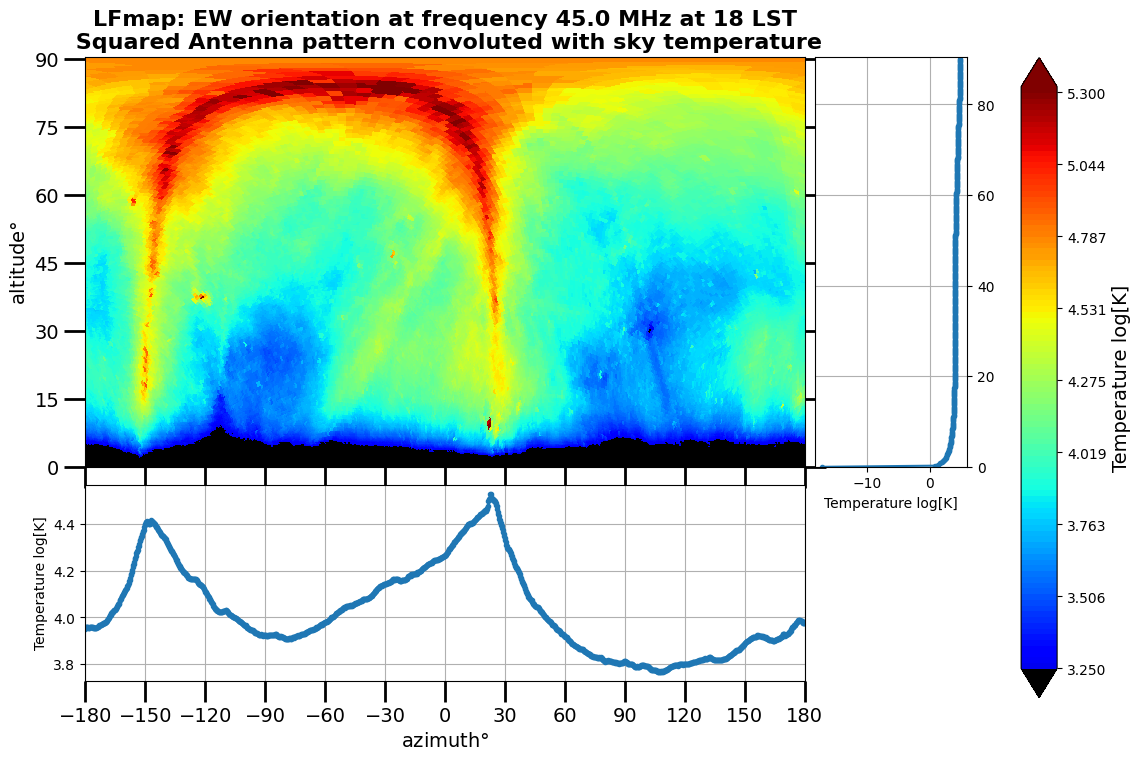

cmap.T:  256
tmins:  3.25  tmax:  5.3  Tstep:  9
cbarTicks:  [3.25    3.50625 3.7625  4.01875 4.275   4.53125 4.7875  5.04375 5.3    ]
Creation of the directory failed (already exists?)


/home/max/auger/soft/galactic_calibration/sky_maps/myPlots.py:1377: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/foldedAntennaSkyMap_LFSM_EW_LST_18


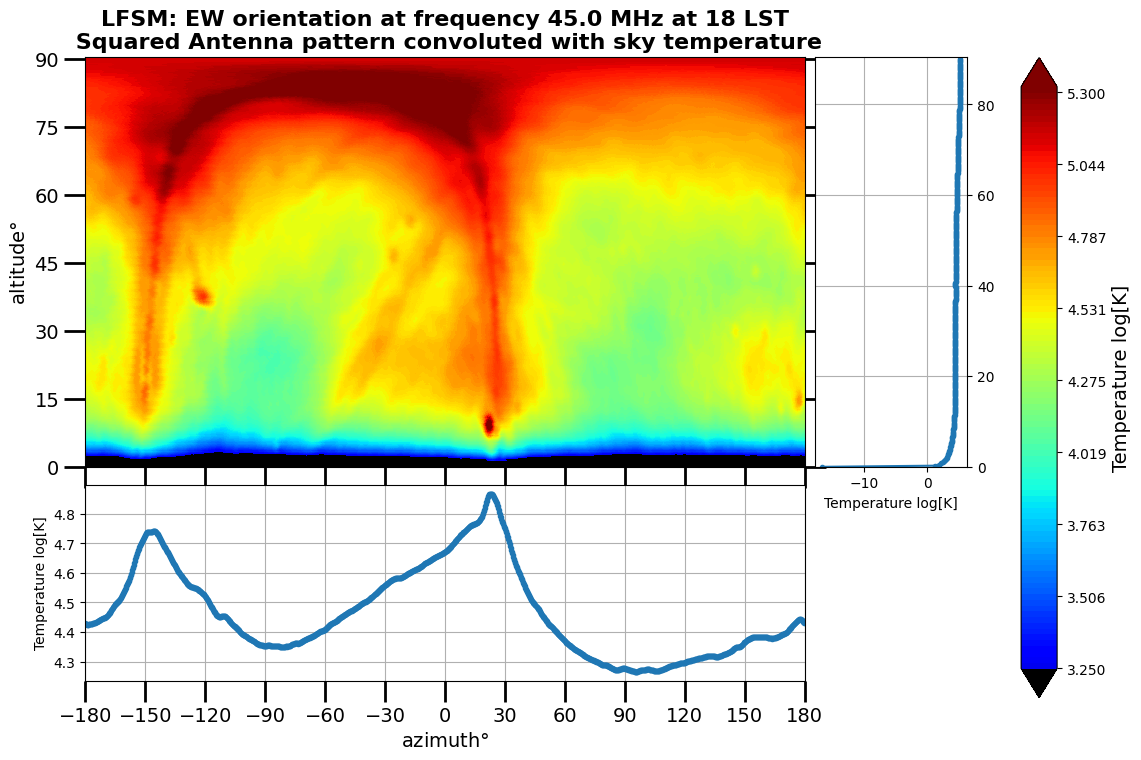

cmap.T:  256
tmins:  0  tmax:  2  Tstep:  9
cbarTicks:  [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
Creation of the directory failed (already exists?)


/home/max/auger/soft/galactic_calibration/sky_maps/myPlots.py:1377: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/Ratio_foldedAntennaSkyMap_LFmap-foldedAntennaSkyMap_LFSM_EW_LST_18


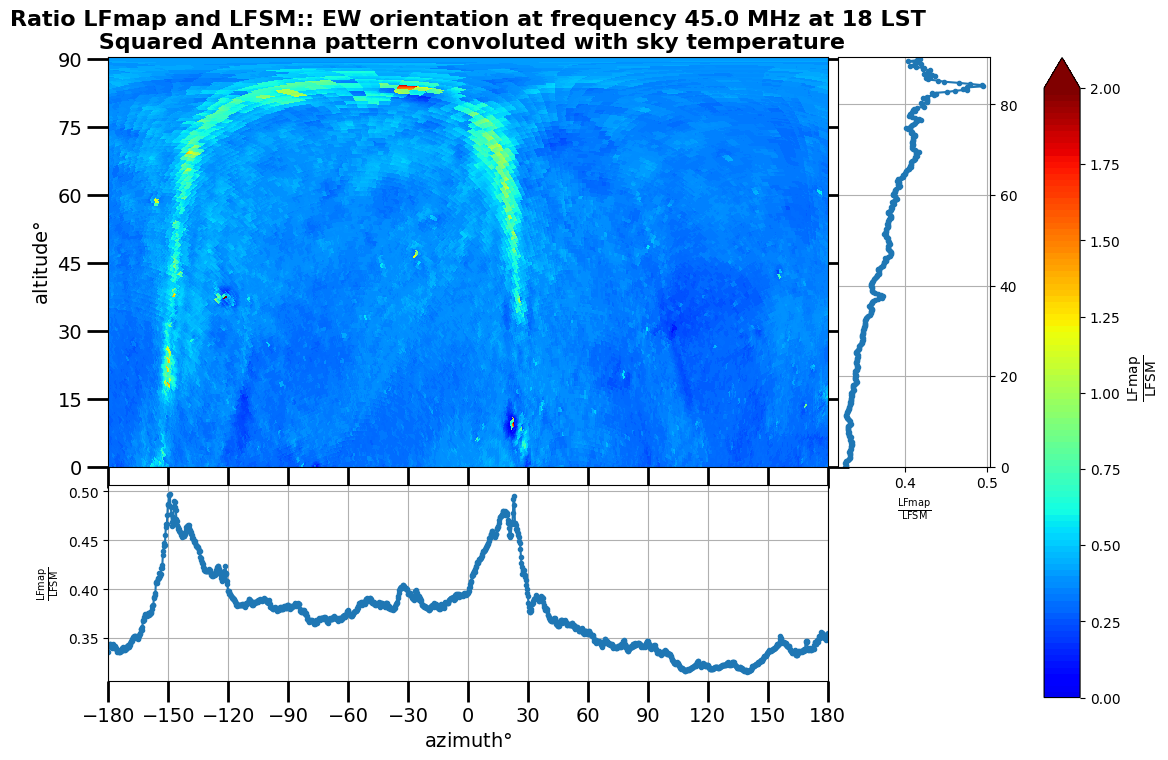

In [110]:
P, T = np.meshgrid(foldedAntennaSkyMap_1.index.values.astype(float),foldedAntennaSkyMap_1.columns.values.astype(float))

save=False
save1=saveFolder+"foldedAntennaSkyMap_"+map_1_title+"_"+orientation+"_LST_"+str(LSTtime)
save2=saveFolder+"foldedAntennaSkyMap_"+map_2_title+"_"+orientation+"_LST_"+str(LSTtime)
save3=saveFolder+"Ratio_foldedAntennaSkyMap_"+map_1_title+"-foldedAntennaSkyMap_"+map_2_title+"_"+orientation+"_LST_"+str(LSTtime)
                                                                                                    
# log here!
myPlots.plot3dnewV3(P, T, np.log10(foldedAntennaSkyMap_1.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15,figureWidth=12,figureHeight=8,
                    xlabel='azimuth$\degree$',ylabel='altitude$\degree$',cbarLabel='Temperature log[K]',extend='both',
                    mainTitle=map_1_title+': '+orientation+" orientation at frequency "+str(frequency)+\
                    ' MHz at '+str(LSTtime)+' LST\n Squared Antenna pattern convoluted with sky temperature',Cmin=3.25, Cmax=5.3,
                    save=save1,close=close)

myPlots.plot3dnewV3(P, T, np.log10(foldedAntennaSkyMap_2.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15,figureWidth=12,figureHeight=8,
                    xlabel='azimuth$\degree$',ylabel='altitude$\degree$',cbarLabel='Temperature log[K]',extend='both',
                    mainTitle=map_2_title+': '+orientation+" orientation at frequency "+str(frequency)+\
                    ' MHz at '+str(LSTtime)+' LST\n Squared Antenna pattern convoluted with sky temperature'
                    ,Cmin=3.25, Cmax=5.3,
                    save=save2,close=close)

ratio=foldedAntennaSkyMap_1.values.T/foldedAntennaSkyMap_2.values.T
myPlots.plot3dnewV3(P, T, ratio,
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15,figureWidth=12,figureHeight=8,
                    xlabel='azimuth$\degree$',ylabel='altitude$\degree$',cbarLabel=r'$\frac{\mathrm{%s}}{\mathrm{%s}}$'%(map_1_title,map_2_title),
                    mainTitle='Ratio '+map_1_title+' and '+map_2_title+':: '+orientation+" orientation at frequency "+str(frequency)+\
                    ' MHz at '+str(LSTtime)+' LST\n Squared Antenna pattern convoluted with sky temperature',
                    Cmin=0,Cmax=2,extend='max', save=save3,close=close)

***
### Now, lets have a look how things looks like at 2:00 LST

In [111]:
LSTtime=2

In [112]:
rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
dump_1 = newvisufunc.projview(map_1,rot=rotAngles, coord=c_coord_1,return_only_data=True,xsize=1439)
dump_2 = newvisufunc.projview(map_2,rot=rotAngles, coord=c_coord_2, return_only_data=True,xsize=1439)

In [113]:
# first convert the data dump to DF and then use the folding function
foldedAntennaSkyMap_1 = foldSkyWithAntenna(antenna, frequency=frequency,orientation='EW',skyMapDF=convert2SkyDF(dump_1,full=False))
foldedAntennaSkyMap_2 = foldSkyWithAntenna(antenna, frequency=frequency,orientation='EW',skyMapDF=convert2SkyDF(dump_2,full=False))
orientation='EW'

cmap.T:  256
tmins:  3.25  tmax:  5.3  Tstep:  9
cbarTicks:  [3.25    3.50625 3.7625  4.01875 4.275   4.53125 4.7875  5.04375 5.3    ]
Creation of the directory failed (already exists?)


/home/max/auger/soft/galactic_calibration/sky_maps/myPlots.py:1377: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/foldedAntennaSkyMap_LFmap_EW_LST_2


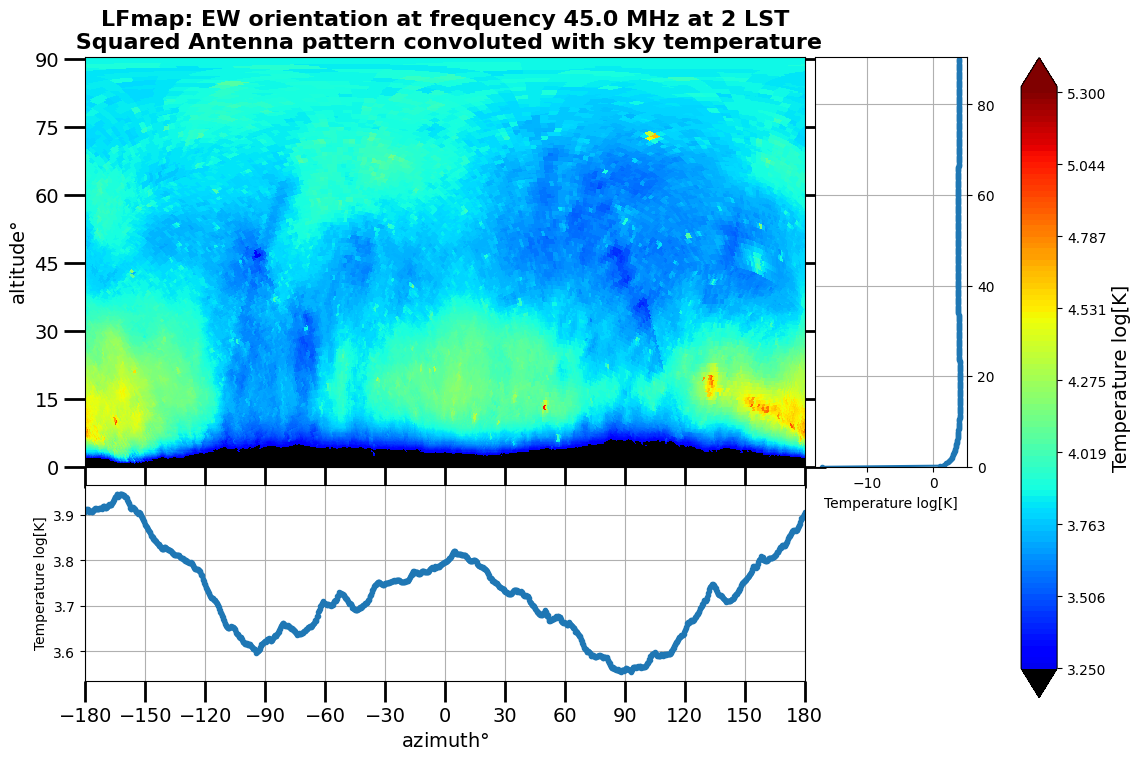

cmap.T:  256
tmins:  3.25  tmax:  5.3  Tstep:  9
cbarTicks:  [3.25    3.50625 3.7625  4.01875 4.275   4.53125 4.7875  5.04375 5.3    ]
Creation of the directory failed (already exists?)


/home/max/auger/soft/galactic_calibration/sky_maps/myPlots.py:1377: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/foldedAntennaSkyMap_LFSM_EW_LST_2


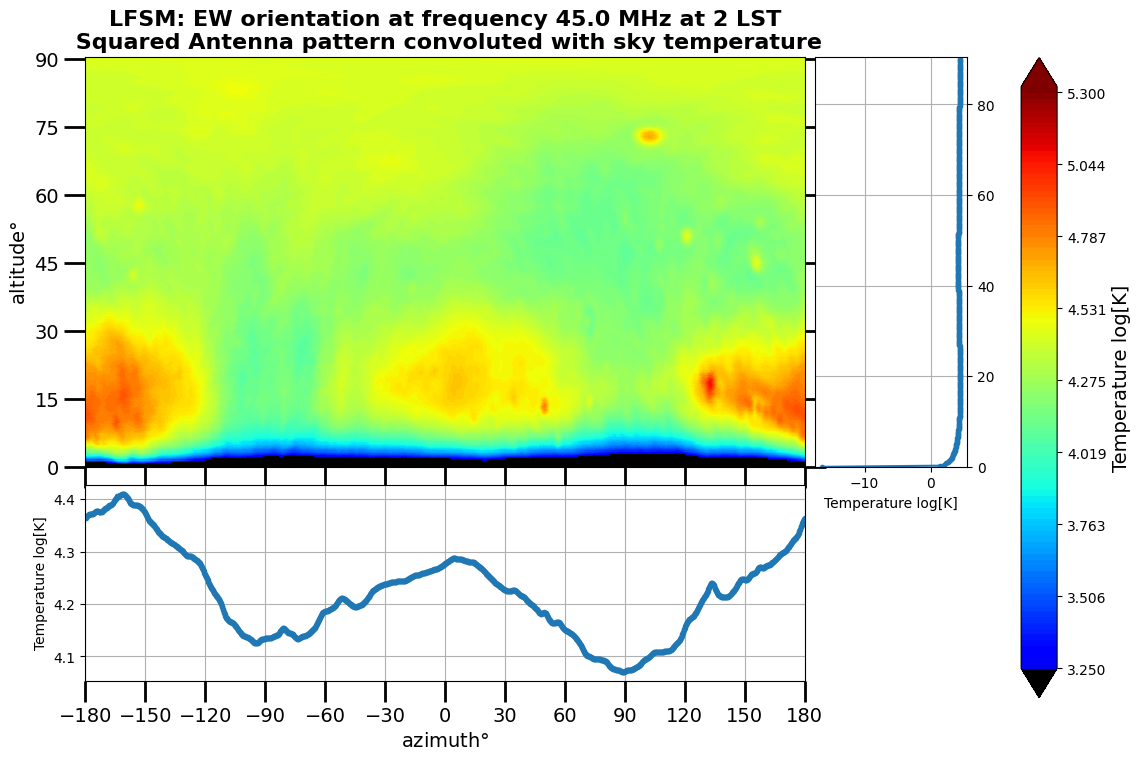

cmap.T:  256
tmins:  0  tmax:  2  Tstep:  9
cbarTicks:  [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
Creation of the directory failed (already exists?)


/home/max/auger/soft/galactic_calibration/sky_maps/myPlots.py:1377: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Figure has been saved to:  /home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/Ratio_foldedAntennaSkyMap_LFmap-foldedAntennaSkyMap_LFSM_EW_LST_2


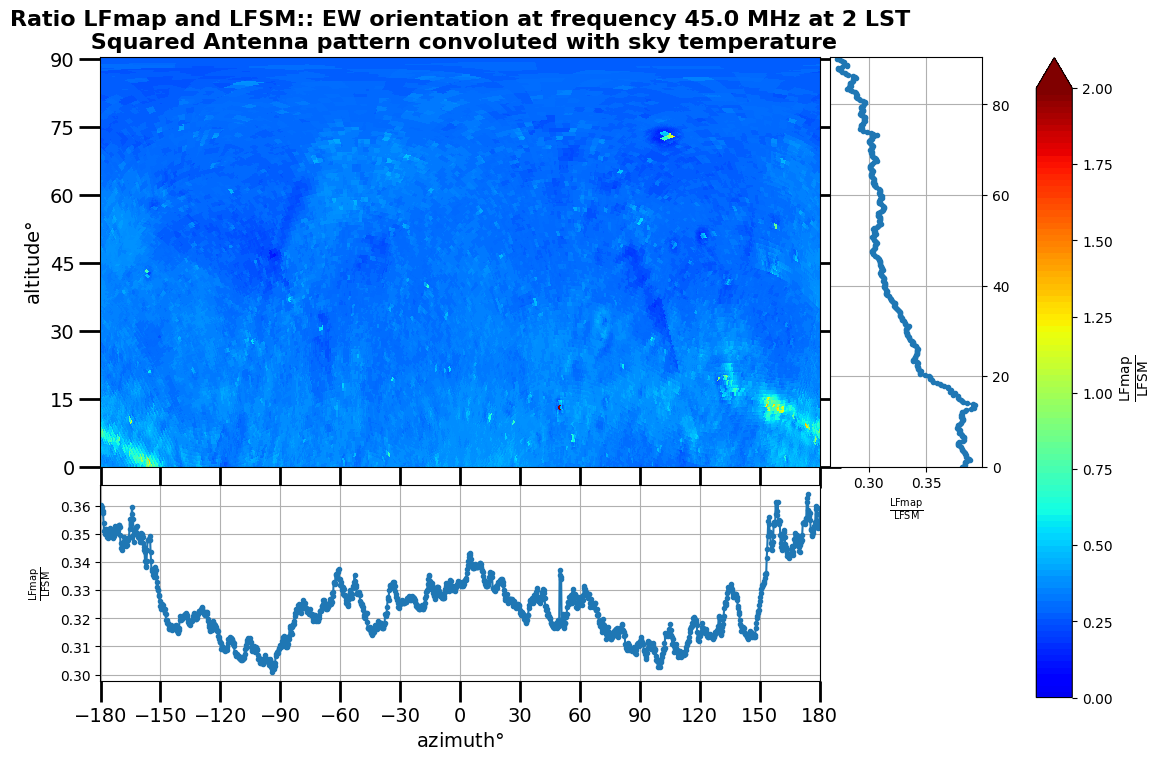

In [114]:
P, T = np.meshgrid(foldedAntennaSkyMap_1.index.values.astype(float),foldedAntennaSkyMap_1.columns.values.astype(float))

save=False
save1=saveFolder+"foldedAntennaSkyMap_"+map_1_title+"_"+orientation+"_LST_"+str(LSTtime)
save2=saveFolder+"foldedAntennaSkyMap_"+map_2_title+"_"+orientation+"_LST_"+str(LSTtime)
save3=saveFolder+"Ratio_foldedAntennaSkyMap_"+map_1_title+"-foldedAntennaSkyMap_"+map_2_title+"_"+orientation+"_LST_"+str(LSTtime)
                                                                                                    
# log here!
myPlots.plot3dnewV3(P, T, np.log10(foldedAntennaSkyMap_1.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15,figureWidth=12,figureHeight=8,
                    xlabel='azimuth$\degree$',ylabel='altitude$\degree$',cbarLabel='Temperature log[K]',extend='both',
                    mainTitle=map_1_title+': '+orientation+" orientation at frequency "+str(frequency)+\
                    ' MHz at '+str(LSTtime)+' LST\n Squared Antenna pattern convoluted with sky temperature',Cmin=3.25, Cmax=5.3,
                    save=save1,close=close)

myPlots.plot3dnewV3(P, T, np.log10(foldedAntennaSkyMap_2.values.T),
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15,figureWidth=12,figureHeight=8,
                    xlabel='azimuth$\degree$',ylabel='altitude$\degree$',cbarLabel='Temperature log[K]',extend='both',
                    mainTitle=map_2_title+': '+orientation+" orientation at frequency "+str(frequency)+\
                    ' MHz at '+str(LSTtime)+' LST\n Squared Antenna pattern convoluted with sky temperature'
                    ,Cmin=3.25, Cmax=5.3,
                    save=save2,close=close)

ratio=foldedAntennaSkyMap_1.values.T/foldedAntennaSkyMap_2.values.T
myPlots.plot3dnewV3(P, T, ratio,
                    slices=True, ymax=90.5, xMajorLocator=30,yMajorLocator=15,figureWidth=12,figureHeight=8,
                    xlabel='azimuth$\degree$',ylabel='altitude$\degree$',cbarLabel=r'$\frac{\mathrm{%s}}{\mathrm{%s}}$'%(map_1_title,map_2_title),
                    mainTitle='Ratio '+map_1_title+' and '+map_2_title+':: '+orientation+" orientation at frequency "+str(frequency)+\
                    ' MHz at '+str(LSTtime)+' LST\n Squared Antenna pattern convoluted with sky temperature',
                    Cmin=0,Cmax=2,extend='max', save=save3,close=close)

## What is really interesting  for us is the integral over the angle

$\int_{\Omega} T_{sky}(t,f,\theta,\phi) |H(f,\theta,\phi)|^{2} d\Omega$

In [115]:
# integrate the folded sky map over the angles
def integrateOverAngles(foldedAntennaSkyMap):
    p = np.deg2rad(foldedAntennaSkyMap.index.values.astype(float))
    t = np.deg2rad(foldedAntennaSkyMap.columns.values.astype(float))
    T, P = np.meshgrid(t, p)
    angePrefactor=np.sin(T[:,::-1])
    integratedOverAngles=simps(simps(foldedAntennaSkyMap*angePrefactor,t),p)
    return integratedOverAngles

In [116]:
LSTtime=2
rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
dump_1 = newvisufunc.projview(map_1,rot=rotAngles, coord=c_coord_1,return_only_data=True,xsize=1439)
dump_2 = newvisufunc.projview(map_2,rot=rotAngles, coord=c_coord_2, return_only_data=True,xsize=1439)
foldedAntennaSkyMap_1 = foldSkyWithAntenna(antenna, frequency=frequency,orientation='EW',skyMapDF=convert2SkyDF(dump_1,full=False))
foldedAntennaSkyMap_2 = foldSkyWithAntenna(antenna, frequency=frequency,orientation='EW',skyMapDF=convert2SkyDF(dump_2,full=False))

In [48]:
angle_integrated_1 = integrateOverAngles(foldedAntennaSkyMap_1)
angle_integrated_2 = integrateOverAngles(foldedAntennaSkyMap_2)
print(angle_integrated_1)
print(angle_integrated_2)
print('Ratio: ',angle_integrated_1/angle_integrated_2)

55346.2247028183
47564.56273851213
Ratio:  1.163602091899512


In [117]:
LSTtime=18
rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
dump_1 = newvisufunc.projview(map_1,rot=rotAngles, coord=c_coord_1,return_only_data=True,xsize=1439)
dump_2 = newvisufunc.projview(map_2,rot=rotAngles, coord=c_coord_2, return_only_data=True,xsize=1439)
foldedAntennaSkyMap_1 = foldSkyWithAntenna(antenna, frequency=frequency,orientation='EW',skyMapDF=convert2SkyDF(dump_1,full=False))
foldedAntennaSkyMap_2 = foldSkyWithAntenna(antenna, frequency=frequency,orientation='EW',skyMapDF=convert2SkyDF(dump_2,full=False))

In [118]:
angle_integrated_1 = integrateOverAngles(foldedAntennaSkyMap_1)
angle_integrated_2 = integrateOverAngles(foldedAntennaSkyMap_2)
print(angle_integrated_1)
print(angle_integrated_2)
print('Ratio: ',angle_integrated_1/angle_integrated_2)

88085.58290535898
219964.1370030815
Ratio:  0.40045429271102034


## Power spectral density calculation
## Power calculation, AKA galactic curve calculation

The equation for the Sky Power emmision is: <br>
$ P_{sky}(t,f) = \frac{k_{b}}{c^{2}} \int_{f} f^{2} \int_{\Omega} T_{sky}(t,f,\theta,\phi) \frac{|H(f,\theta,\phi)|^{2}Z_{0}}{R_{r}} df d\Omega $ <br>
where <br>
$ <|H(f,\theta,\phi)|^{2}> = \frac{1}{2}(|J_{\theta}|^2+|J_{\phi}|^2|) $ <br>
The power spectrum density is therefore: <br>
$ \mathscr{P}_{sky}(t,f) = \frac{k_{b}}{c^{2}} f^{2} \int_{\Omega} T_{sky}(t,f,\theta,\phi) \frac{|H(f,\theta,\phi)|^{2}Z_{0}}{R_{r}} d\Omega $ <br>
Then:
$ P_{sky}(t,f) = \int_{f} \mathscr{P}_{sky}(t,f) df$ 
  

In [51]:
# this function helps to convert the data dump from newvisufunc.projview() to DF
def convert2SkyDF(data_dump,full=False):
    def DFtemplateCreator(xs,ys,yName=None):
        colList = [str(x) for x in xs]
        nan_init = np.empty((len(xs),len(ys),))
        nan_init[:]=np.nan
        templateDF = pd.DataFrame(nan_init.T, columns = colList)
        templateDF.insert(0,yName,ys)
        templateDF = templateDF.set_index(yName)
        return templateDF
    longitude,latitude,grid_map = data_dump
    latitudeDeg = np.rad2deg(latitude)
    longitudeDeg = np.rad2deg(longitude)
    skyMapDF = DFtemplateCreator(latitudeDeg,longitudeDeg,yName=None)
    skyMapDF.iloc[:,:] = grid_map.T
    if full is False:
        skyMapDF = skyMapDF.iloc[:,np.where(skyMapDF.columns.astype(float) >=0)[0].tolist()]
    skyMapDF=skyMapDF.sort_index()
    return skyMapDF

def DFtemplateCreator(xs,ys,yName=None):
    colList = [str(x) for x in xs]
    nan_init = np.empty((len(xs),len(ys),))
    nan_init[:]=np.nan
    templateDF = pd.DataFrame(nan_init.T, columns = colList)
    templateDF.insert(0,yName,ys)
    templateDF = templateDF.set_index(yName)
    return templateDF

def simulateGalacticModulationCurve(antennaClass=None, skyMapClass=None, startFrequency=30.0,endFrequency=80.0,frequencySpacing=2.0,
                                    startLST=0,endLST=24,LSTspacing=2, LFSS=None,
                                    orientation=None,returnOnlyIntegratedAngle=False, impedanceFile=None):
    Z0 = constants.physical_constants["characteristic impedance of vacuum"][0]
    frequencies = np.arange(startFrequency,endFrequency+frequencySpacing,frequencySpacing)
    LSTtimes = np.arange(startLST,endLST+LSTspacing,LSTspacing)
    if impedanceFile is not None:
        impedanceData = np.loadtxt(impedanceFile)
        impedanceFunction = interp1d(impedanceData[0],impedanceData[1])
    else:
        print('No impedance file! Impedance set to 1')
    if antennaClass == None:
        print('Pass the antenna class please.')
        return None
    if skyMapClass == None:
        print('Pass the sky map class please.')
        return None
    if orientation == None:
        print('Orientation? EW or NS?')
        return None
    altitude = -35.206667
    inc = 0.1
    if LFSS == True:
        coord = ['G','C']
    elif LFSS== False:
        coord = ['C']
    else:
        print('LFSS map, True or False?')
        return None
    angle_integratedList=[]
    powerSpectrumDensityList=[]
    constantFactor = (2*constants.k/constants.c**2)*Z0
    for LSTtime in tqdm(LSTtimes):
        angle_integratedList_at_freq_F=[]
        powerSpectrumDensityList_at_freq_F=[]
        for frequency in frequencies:
            if impedanceFile is not None:
                freqDepPrefactor = ((frequency*1e+6)**2)/impedanceFunction(frequency)
            else:
                freqDepPrefactor = (frequency*1e+6)**2
            #print('I AM AT FREQUENCY: '+str(frequency)+' Mhz.')
            skyMap = skyMapClass.generate(frequency)
            rotAngles=[(180+(LSTtime*15))%360,-(altitude-90)]
            # xsize=1439 will give angle spacing of 0.25 degrees
            dump = newvisufunc.projview(skyMap,rot=rotAngles, coord=coord, return_only_data=True,xsize=1439)
            foldedAntennaSkyMap = foldSkyWithAntenna(antennaClass, frequency=frequency,orientation=orientation,skyMapDF=convert2SkyDF(dump,full=False))
            angle_integrated = integrateOverAngles(foldedAntennaSkyMap)
            angle_integratedList_at_freq_F.append(angle_integrated)
            # power spectrum density
            powerSpectrumDensity = constantFactor*freqDepPrefactor*angle_integrated
            powerSpectrumDensityList_at_freq_F.append(powerSpectrumDensity)
        angle_integratedList.append(np.asarray(angle_integratedList_at_freq_F))
        powerSpectrumDensityList.append(np.asarray(powerSpectrumDensityList_at_freq_F))
    if returnOnlyIntegratedAngle == True:
        angle_integratedDF = DFtemplateCreator(frequencies,LSTtimes,yName=None)
        angle_integratedDF.iloc[:,:] = np.asarray(angle_integratedList)
        return angle_integratedDF
    else:
        powerSpectrumDensityDF = DFtemplateCreator(frequencies,LSTtimes,yName=None)
        powerSpectrumDensityDF.iloc[:,:]= np.asarray(powerSpectrumDensityList)
        return powerSpectrumDensityDF

#skyMapDF = skyMapDF_LFSS
def foldSkyWithAntenna(antenna, frequency=None,orientation=None,skyMapDF=None):
    quantity = 'absHeight'
    p = skyMapDF.index.values.astype(float)
    t = skyMapDF.columns.values.astype(float)
    Amp = antenna.get(quantity=quantity,frequency=frequency,newTheta=t,newPhi=p,kind='linear',changeConvention=True,
                      orientation=orientation)
    foldedAntennaSkyMap = Amp**2*skyMapDF
    return foldedAntennaSkyMap

# integrate the folded sky map over the angles
def integrateOverAngles(foldedAntennaSkyMap):
    p = np.deg2rad(foldedAntennaSkyMap.index.values.astype(float))
    t = np.deg2rad(foldedAntennaSkyMap.columns.values.astype(float))
    T, P = np.meshgrid(t, p)
    angePrefactor=np.sin(T[:,::-1])
    integratedOverAngles=simps(simps(foldedAntennaSkyMap*angePrefactor,t),p)
    return integratedOverAngles

Ideally you should simulate as small time deltas as possible and than binned them approprietly.
For example, if the measured data are binned to 1 hour bins, calculating the simulated data at one hour steps might gave you a 30 minutes time offset. Better is to simulate 15minutes steps and binned them to 1 hour. This is more representative then.

In [52]:
# time binning
def DFtimeBinning(DF,timeBinWidth=1):
    new=[]
    newTimes=[]
    rowNumer, _ = DF.shape
    tstart=float(DF.index.values[0])
    tstep=float(DF.index.values[1])-float(DF.index.values[0])
    tWidth = int(timeBinWidth/tstep + 1) # how many cols have to be integrated to have the wanted frequency binning, the +1 is because the last  element is excluded
    totalNumberOfNewTimeRows=int((rowNumer-1)/(tWidth-1))
    for i in range(0,totalNumberOfNewTimeRows,1):
        newTimes.append(i*timeBinWidth)
        new.append(DF.iloc[i:i+tWidth,:].mean(axis=0))
    new = np.asarray(new)
    newTimes=np.asarray(newTimes)
    newDF = DFtemplateCreator(DF.columns.values,newTimes)
    newDF.iloc[:,:] = np.asarray(new)
    return newDF

In [53]:
saveFolder='/home/max/auger/soft/galactic_calibration/sky_maps/results/skySimulation/'

In [55]:
impedanceFile_EW = '/home/tomas/opt/Offline-install/apps/RdGalacticDatasetMakerProject/'+"/RdGalacticDatasetMaker/EW_impedance4c.txt"
impedanceFile_NS = '/home/tomas/opt/Offline-install/apps/RdGalacticDatasetMakerProject/'+"/RdGalacticDatasetMaker/NS_impedance4c.txt"

# antenna patter class
antennaEW = getAntennaPatternQuantities(antennaPathEW)
antennaNS = getAntennaPatternQuantities(antennaPathNS)
# for Polisensky's LFmap, these are by default generated in Celestial coordinated
g_LFmap = LFmap("/home/max/auger/soft/LFmap_1.0/healpyFits/")
# for lf map from pygdsem
g_LFSS = LowFrequencySkyModel(freq_unit='MHz')

In [56]:
# LFSS EW
startFrequency=30.0
endFrequency=80.0
frequencySpacing=1.0
startLST=0
endLST=24
LSTspacing=1

powerSpectrumDensityDF_LFSS_EW = simulateGalacticModulationCurve(antennaClass=antennaEW, skyMapClass=g_LFSS, startFrequency=startFrequency,
                                                        endFrequency=endFrequency, frequencySpacing=frequencySpacing, LFSS=True, 
                                                        orientation='EW',returnOnlyIntegratedAngle=False,
                                                        startLST=startLST,endLST=endLST,LSTspacing=LSTspacing,impedanceFile=impedanceFile_EW)

OSError: /home/tomas/opt/Offline-install/apps/RdGalacticDatasetMakerProject//RdGalacticDatasetMaker/EW_impedance4c.txt not found.

In [50]:
# for saving
powerSpectrumDensityDF_LFSS_EW.to_csv(saveFolder+'powerSpectrumDensityDF_LFSS_EW.csv')

In [51]:
# for reading
powerSpectrumDensityDF_LFSS_EW = pd.read_csv(saveFolder+'powerSpectrumDensityDF_LFSS_EW.csv',index_col=0)

In [52]:
# LFSS NS
startFrequency=30.0
endFrequency=80.0
frequencySpacing=1.0
startLST=0
endLST=24
LSTspacing=1

powerSpectrumDensityDF_LFSS_NS = simulateGalacticModulationCurve(antennaClass=antennaNS, skyMapClass=g_LFSS, startFrequency=startFrequency,
                                                        endFrequency=endFrequency, frequencySpacing=frequencySpacing, LFSS=True, 
                                                        orientation='NS',returnOnlyIntegratedAngle=False,
                                                        startLST=startLST,endLST=endLST,LSTspacing=LSTspacing,impedanceFile=impedanceFile_NS)

In [53]:
# for saving
powerSpectrumDensityDF_LFSS_NS.to_csv(saveFolder+'powerSpectrumDensityDF_LFSS_NS.csv')

In [54]:
# for reading
powerSpectrumDensityDF_LFSS_NS = pd.read_csv(saveFolder+'powerSpectrumDensityDF_LFSS_NS.csv',index_col=0)

In [55]:
# Polisensky's LFmap EW
startFrequency=30.0
endFrequency=80.0
frequencySpacing=1.0
startLST=0
endLST=24
LSTspacing=1

powerSpectrumDensityDF_LFmap_EW = simulateGalacticModulationCurve(antennaClass=antennaEW, skyMapClass=g_LFmap, startFrequency=startFrequency,
                                                        endFrequency=endFrequency, frequencySpacing=frequencySpacing, LFSS=False, 
                                                        orientation='EW',returnOnlyIntegratedAngle=False,
                                                        startLST=startLST,endLST=endLST,LSTspacing=LSTspacing,impedanceFile=impedanceFile_EW)

/usr/local/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/usr/local/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 64
  warnings.warn("NSIDE = {0:d}".format(nside))
/usr/local/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/usr/local/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [56]:
# for saving
powerSpectrumDensityDF_LFmap_EW.to_csv(saveFolder+'powerSpectrumDensityDF_LFmap_EW.csv')

In [57]:
# for reading
powerSpectrumDensityDF_LFmap_EW = pd.read_csv(saveFolder+'powerSpectrumDensityDF_LFmap_EW.csv',index_col=0)

In [58]:
# Polisensky's LFmap NS
startFrequency=30.0
endFrequency=80.0
frequencySpacing=1.0
startLST=0
endLST=24
LSTspacing=1

powerSpectrumDensityDF_LFmap_NS = simulateGalacticModulationCurve(antennaClass=antennaNS, skyMapClass=g_LFmap, startFrequency=startFrequency,
                                                        endFrequency=endFrequency, frequencySpacing=frequencySpacing, LFSS=False, 
                                                        orientation='NS',returnOnlyIntegratedAngle=False,
                                                        startLST=startLST,endLST=endLST,LSTspacing=LSTspacing,impedanceFile=impedanceFile_NS)

In [59]:
# for saving
powerSpectrumDensityDF_LFmap_NS.to_csv(saveFolder+'powerSpectrumDensityDF_LFmap_NS.csv')

In [60]:
# for reading
powerSpectrumDensityDF_LFmap_NS = pd.read_csv(saveFolder+'powerSpectrumDensityDF_LFmap_NS.csv',index_col=0)

## EW orientation; Power spectrum density

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]


/home/tomas/myPyModules/myPlots.py:1378: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto')#,edgecolor='k',facecolor='none') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Creation of the directory failed (already exists?)
Figure has been saved to:  /home/tomas/results/skySimulation/powerSpectrumDensityDF_LFSS_EW


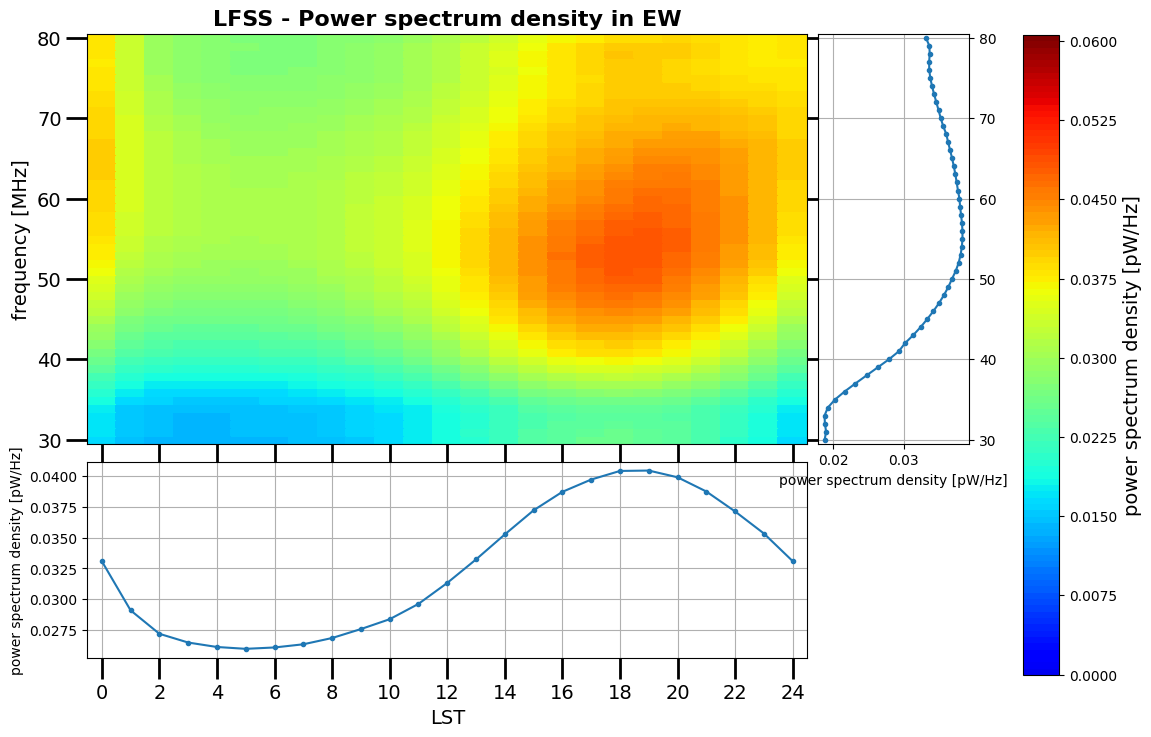

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]
Creation of the directory failed (already exists?)


/home/tomas/myPyModules/myPlots.py:1378: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto')#,edgecolor='k',facecolor='none') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Figure has been saved to:  /home/tomas/results/skySimulation/powerSpectrumDensityDF_LFmap_EW


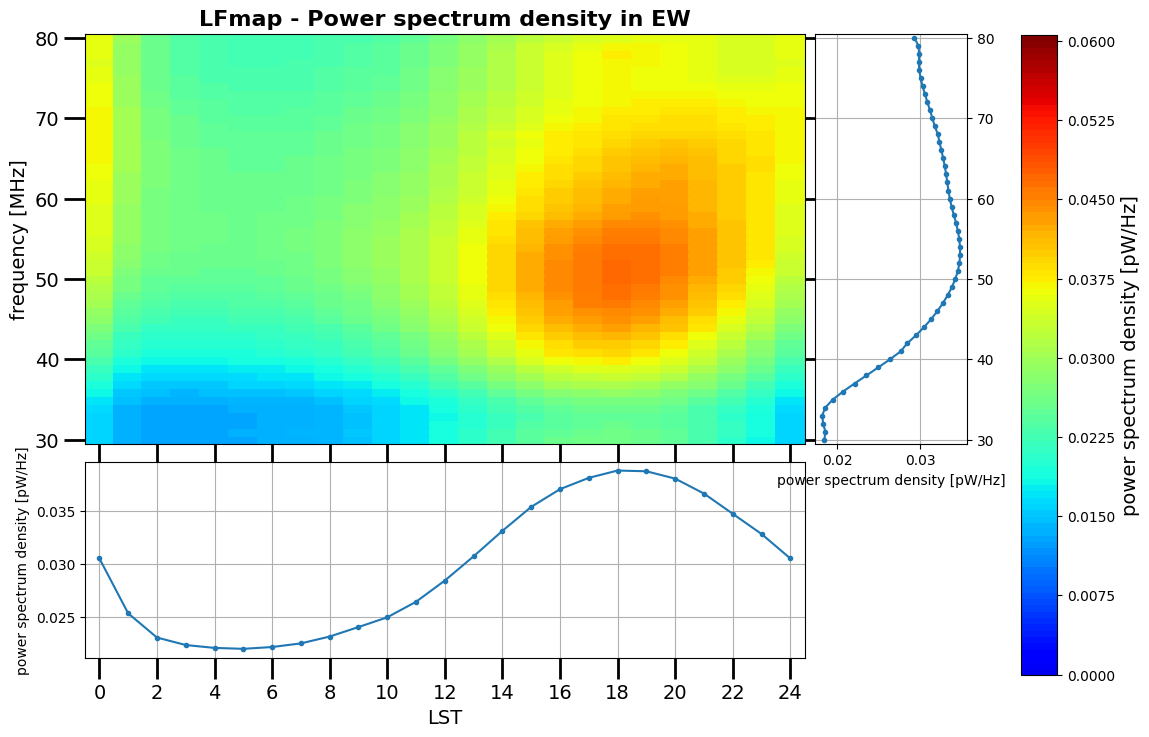

cmap.T:  256
tmins:  0.9  tmax:  1.25  Tstep:  9
cbarTicks:  [0.9     0.94375 0.9875  1.03125 1.075   1.11875 1.1625  1.20625 1.25   ]


/home/tomas/myPyModules/myPlots.py:1378: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto')#,edgecolor='k',facecolor='none') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Creation of the directory failed (already exists?)
Figure has been saved to:  /home/tomas/results/skySimulation/Ratio_PowerSpectrumDensity_EW


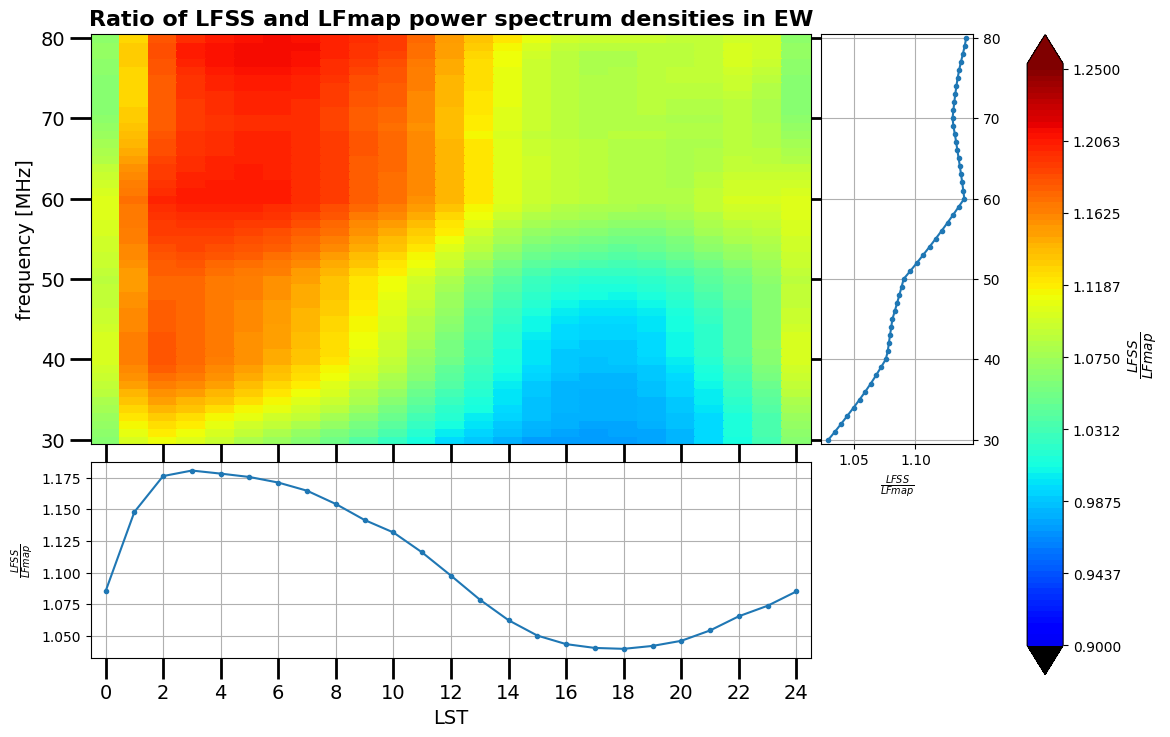

In [63]:
orientation = 'EW'
#save=saveFolder
close=False
save=False

save1 = saveFolder+'powerSpectrumDensityDF_LFSS_'+orientation
save2 = saveFolder+'powerSpectrumDensityDF_LFmap_'+orientation
save3 = saveFolder+'Ratio_PowerSpectrumDensity_'+orientation

LST_grid, freq_grid = np.meshgrid(powerSpectrumDensityDF_LFSS_EW.index.values.astype(float),powerSpectrumDensityDF_LFSS_EW.columns.values.astype(float))

myPlots.plot3dnewV3(LST_grid, freq_grid, powerSpectrumDensityDF_LFSS_EW.values.T*1e+18,slices=True,figureWidth=12,figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel='power spectrum density [pW/Hz]',xMajorLocator=2,yMajorLocator=10,
                    mainTitle="LFSS - Power spectrum density in "+orientation, Cmin=0, Cmax=0.06,ymin=29.5,ymax=80.5,
                    save=save1,close=close)

myPlots.plot3dnewV3(LST_grid, freq_grid, powerSpectrumDensityDF_LFmap_EW.values.T*1e+18,slices=True,figureWidth=12,figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel='power spectrum density [pW/Hz]',xMajorLocator=2,yMajorLocator=10,
                    mainTitle="LFmap - Power spectrum density in "+orientation, Cmin=0, Cmax=0.06,ymin=29.5,ymax=80.5,
                    save=save2,close=close)

ratio = powerSpectrumDensityDF_LFSS_EW.values/powerSpectrumDensityDF_LFmap_EW.values
myPlots.plot3dnewV3(LST_grid, freq_grid, ratio.T,slices=True,figureWidth=12,figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel=r'$\frac{LFSS}{LFmap}$',xMajorLocator=2,yMajorLocator=10,
                    mainTitle="Ratio of LFSS and LFmap power spectrum densities in "+orientation, Cmin=0.9, Cmax=1.25,ymin=29.5,ymax=80.5,extend='both',
                    save=save3,close=close)

***
***


## NS orientation; Power spectrum density

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]


/home/tomas/myPyModules/myPlots.py:1378: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto')#,edgecolor='k',facecolor='none') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Creation of the directory failed (already exists?)
Figure has been saved to:  /home/tomas/results/skySimulation/powerSpectrumDensityDF_LFSS_NS


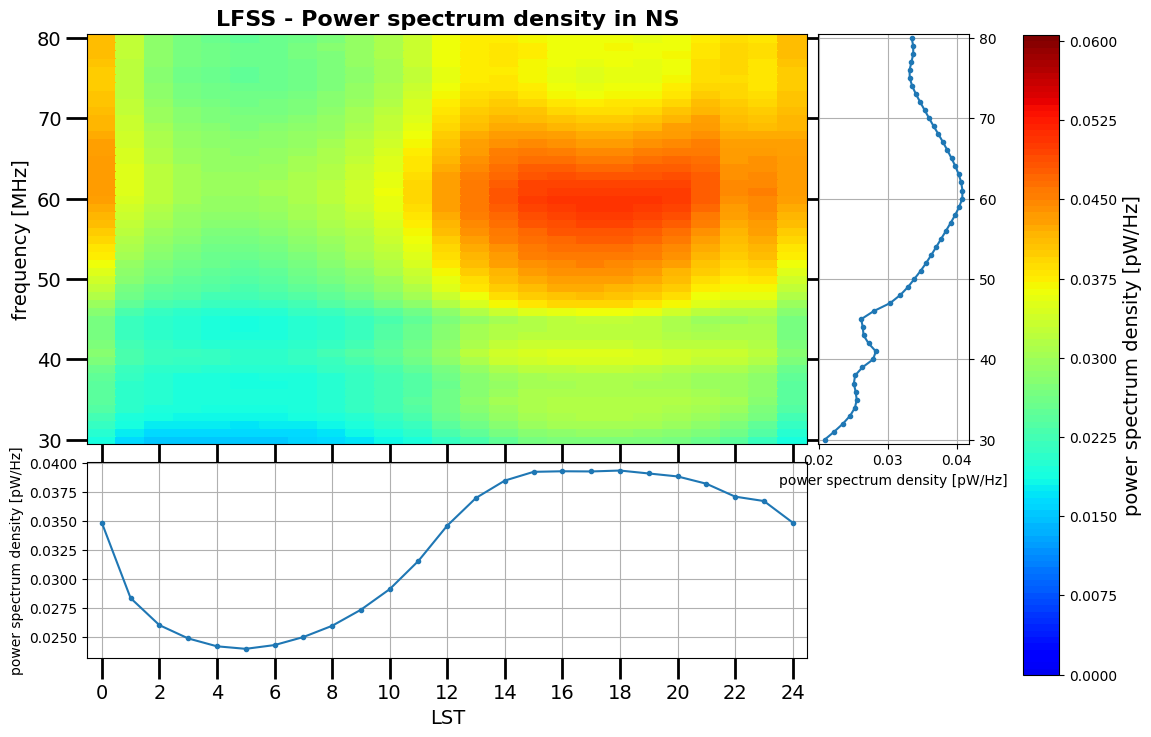

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]


/home/tomas/myPyModules/myPlots.py:1378: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto')#,edgecolor='k',facecolor='none') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Creation of the directory failed (already exists?)
Figure has been saved to:  /home/tomas/results/skySimulation/powerSpectrumDensityDF_LFmap_NS


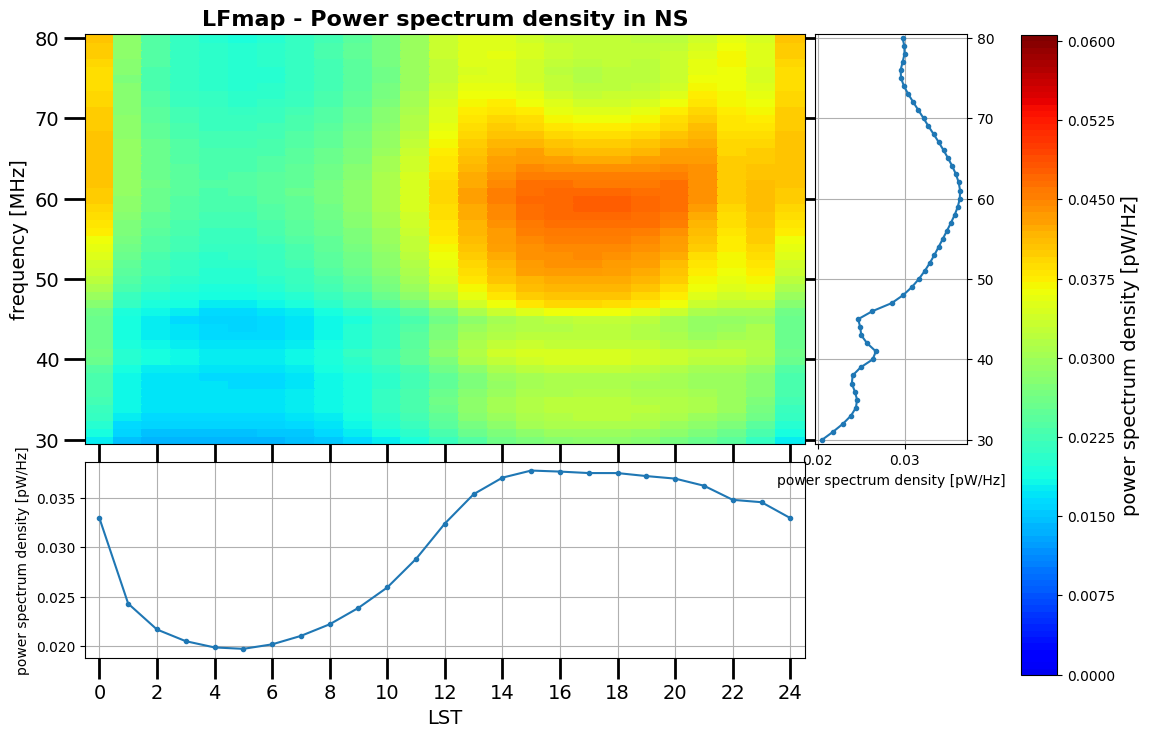

cmap.T:  256
tmins:  0.9  tmax:  1.25  Tstep:  9
cbarTicks:  [0.9     0.94375 0.9875  1.03125 1.075   1.11875 1.1625  1.20625 1.25   ]


/home/tomas/myPyModules/myPlots.py:1378: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto')#,edgecolor='k',facecolor='none') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Creation of the directory failed (already exists?)
Figure has been saved to:  /home/tomas/results/skySimulation/Ratio_PowerSpectrumDensity_NS


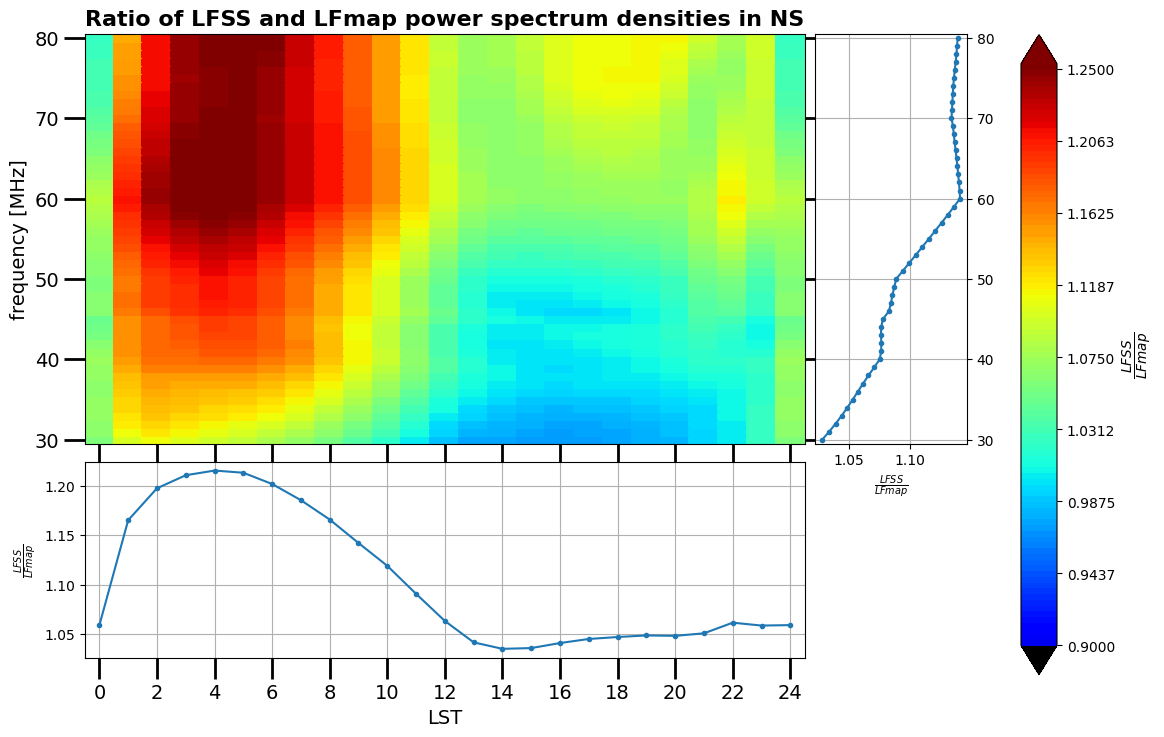

In [64]:
orientation = 'NS'
#save=saveFolder
close=False
save=False

save1 = saveFolder+'powerSpectrumDensityDF_LFSS_NS'
save2 = saveFolder+'powerSpectrumDensityDF_LFmap_NS'
save3 = saveFolder+'Ratio_PowerSpectrumDensity_NS'

LST_grid, freq_grid = np.meshgrid(powerSpectrumDensityDF_LFSS_NS.index.values.astype(float),powerSpectrumDensityDF_LFSS_NS.columns.values.astype(float))
myPlots.plot3dnewV3(LST_grid, freq_grid, powerSpectrumDensityDF_LFSS_NS.values.T*1e+18,slices=True,figureWidth=12,figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel='power spectrum density [pW/Hz]',xMajorLocator=2,yMajorLocator=10,
                    mainTitle="LFSS - Power spectrum density in "+orientation, Cmin=0, Cmax=0.06,ymin=29.5,ymax=80.5,
                    save=save1,close=close)

myPlots.plot3dnewV3(LST_grid, freq_grid, powerSpectrumDensityDF_LFmap_NS.values.T*1e+18,slices=True,figureWidth=12,figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel='power spectrum density [pW/Hz]',xMajorLocator=2,yMajorLocator=10,
                    mainTitle="LFmap - Power spectrum density in "+orientation, Cmin=0, Cmax=0.06,ymin=29.5,ymax=80.5,
                    save=save2,close=close)

ratio = powerSpectrumDensityDF_LFSS_NS.values/powerSpectrumDensityDF_LFmap_NS.values
myPlots.plot3dnewV3(LST_grid, freq_grid, ratio.T,slices=True,figureWidth=12,figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel=r'$\frac{LFSS}{LFmap}$',xMajorLocator=2,yMajorLocator=10,
                    mainTitle="Ratio of LFSS and LFmap power spectrum densities in "+orientation, Cmin=0.9, Cmax=1.25,ymin=29.5,ymax=80.5,extend='both',
                    save=save3,close=close)

## Integrate the power spectrum density to have Power spectrum
$ P_{sky}(t,f) = \int_{f} \mathscr{P}_{sky}(t,f) df$ <br>
For 1 Mhz bins in power you need to calculate at power spectrum density in at least 1 MHz spacing. Ideally to the same frequency spacing as are the measured data and integrate that. This is then done precisely what you are doing with the data.

In [158]:
def integratePowerSpectrumDensityDF2PowerSpectrum(powerSpectrumDensityDF,fbinWidth=1):
    powerSpectrum=[]
    newFrequencies=[]
    _, colNumber = powerSpectrumDensityDF.shape
    fstart=float(powerSpectrumDensityDF.columns.values[0])
    fstep=float(powerSpectrumDensityDF.columns.values[1])-float(powerSpectrumDensityDF.columns.values[0])
    fwidth = int(fbinWidth/fstep + 1) # how many cols have to be integrated to have the wanted frequency binning, the +1 is because the last  element is excluded
    totalNumberOfNewFreqColumns=int((colNumber-1)/(fwidth-1))
    for i in range(0,totalNumberOfNewFreqColumns,1):
        newFrequencies.append(fstart+i*fbinWidth)
        #print(powerSpectrumDensityDF_LFSS.iloc[i:i+fwidth,:].index.values)
        powerSpectrum.append(simps(powerSpectrumDensityDF.iloc[:,i:i+fwidth].values, 
                                   powerSpectrumDensityDF.iloc[:,i:i+fwidth].columns.values.astype(float)*1e+6))
    powerSpectrum = np.asarray(powerSpectrum)
    newFrequencies=np.asarray(newFrequencies)
    powerSpectrumDF = DFtemplateCreator(newFrequencies,powerSpectrumDensityDF.index.values.astype(float))
    powerSpectrumDF.iloc[:,:] = np.asarray(powerSpectrum.T)
    return powerSpectrumDF

In [108]:
powerDF_LFmap_EW=integratePowerSpectrumDensityDF2PowerSpectrum(powerSpectrumDensityDF_LFmap_EW)
powerDF_LFmap_NS=integratePowerSpectrumDensityDF2PowerSpectrum(powerSpectrumDensityDF_LFmap_NS)
powerDF_LFSS_EW=integratePowerSpectrumDensityDF2PowerSpectrum(powerSpectrumDensityDF_LFSS_EW)
powerDF_LFSS_NS=integratePowerSpectrumDensityDF2PowerSpectrum(powerSpectrumDensityDF_LFSS_NS)

In [109]:
# for saving
powerDF_LFmap_EW.to_csv(saveFolder+'powerDF_LFmap_EW.csv')
# for saving
powerDF_LFmap_NS.to_csv(saveFolder+'powerDF_LFmap_NS.csv')
# for saving
powerDF_LFSS_EW.to_csv(saveFolder+'powerDF_LFSS_EW.csv')
# for saving
powerDF_LFSS_NS.to_csv(saveFolder+'powerDF_LFSS_NS.csv')

In [110]:
# for reading
powerDF_LFmap_EW = pd.read_csv(saveFolder+'powerDF_LFmap_EW.csv',index_col=0)
# for reading
powerDF_LFmap_NS = pd.read_csv(saveFolder+'powerDF_LFmap_NS.csv',index_col=0)
# for reading
powerDF_LFSS_EW = pd.read_csv(saveFolder+'powerDF_LFSS_EW.csv',index_col=0)
# for reading
powerDF_LFSS_NS = pd.read_csv(saveFolder+'powerDF_LFSS_NS.csv',index_col=0)

## EW orientation; Power

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]
Creation of the directory failed (already exists?)


/home/tomas/myPyModules/myPlots.py:1378: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto')#,edgecolor='k',facecolor='none') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Figure has been saved to:  /home/tomas/results/skySimulation/powerDF_LFSS_EW


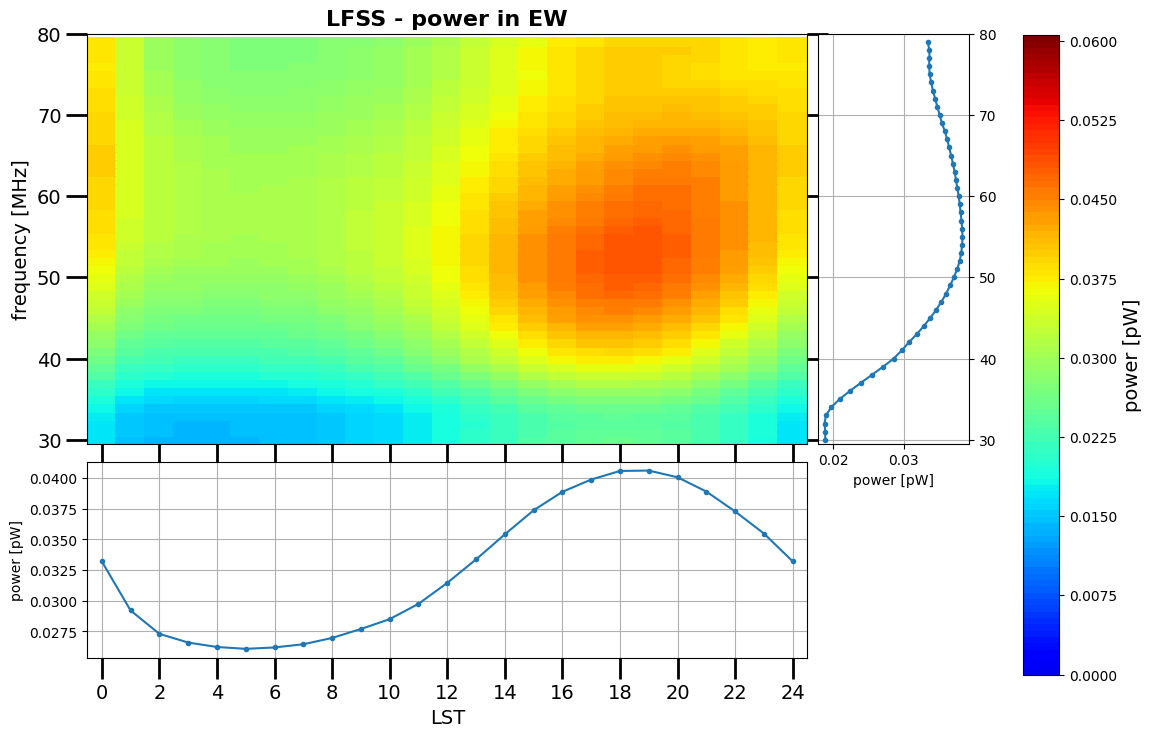

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]
Creation of the directory failed (already exists?)


/home/tomas/myPyModules/myPlots.py:1378: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto')#,edgecolor='k',facecolor='none') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Figure has been saved to:  /home/tomas/results/skySimulation/powerDF_LFmap_EW


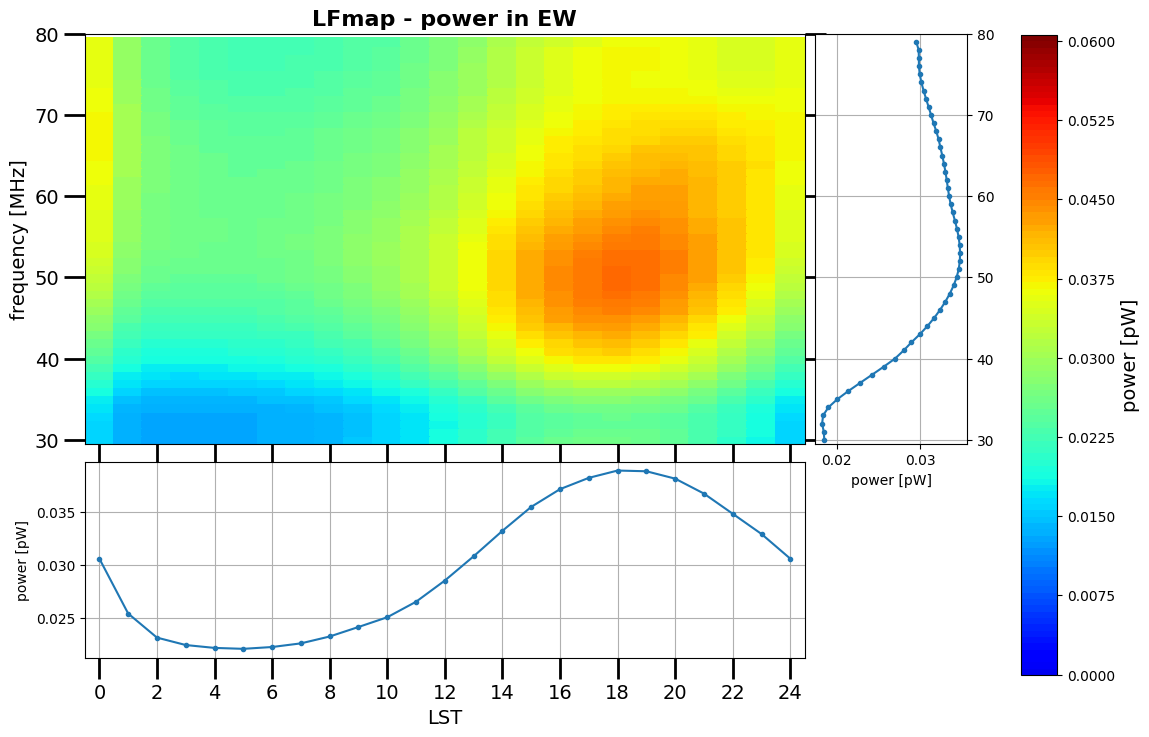

cmap.T:  256
tmins:  0.9  tmax:  1.25  Tstep:  9
cbarTicks:  [0.9     0.94375 0.9875  1.03125 1.075   1.11875 1.1625  1.20625 1.25   ]
Creation of the directory failed (already exists?)


/home/tomas/myPyModules/myPlots.py:1378: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto')#,edgecolor='k',facecolor='none') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Figure has been saved to:  /home/tomas/results/skySimulation/Ratio_Power_EW


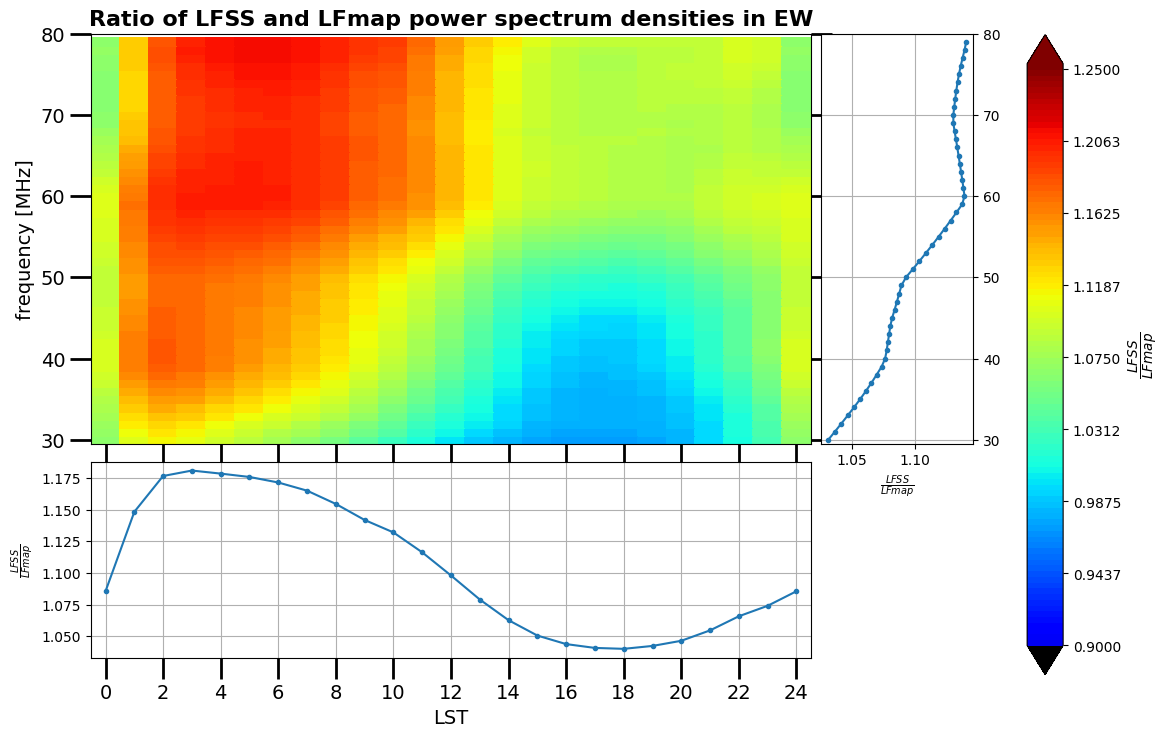

In [111]:
orientation = 'EW'
#save=saveFolder
close=False
save=False

save1 = saveFolder+'powerDF_LFSS_EW'
save2 = saveFolder+'powerDF_LFmap_EW'
save3 = saveFolder+'Ratio_Power_EW'

LST_grid, freq_grid = np.meshgrid(powerDF_LFSS_EW.index.values.astype(float),powerDF_LFSS_EW.columns.values.astype(float))
myPlots.plot3dnewV3(LST_grid, freq_grid, powerDF_LFSS_EW.values.T*1e+12,slices=True,figureWidth=12,figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel='power [pW]',xMajorLocator=2,yMajorLocator=10,
                    mainTitle="LFSS - power in "+orientation, Cmin=0, Cmax=0.06,ymin=29.5,ymax=80,
                    save=save1,close=close)

myPlots.plot3dnewV3(LST_grid, freq_grid, powerDF_LFmap_EW.values.T*1e+12,slices=True,figureWidth=12,figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel='power [pW]',xMajorLocator=2,yMajorLocator=10,
                    mainTitle="LFmap - power in "+orientation, Cmin=0, Cmax=0.06,ymin=29.5,ymax=80,
                    save=save2,close=close)

ratio = powerDF_LFSS_EW.values/powerDF_LFmap_EW.values
myPlots.plot3dnewV3(LST_grid, freq_grid, ratio.T,slices=True,figureWidth=12,figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel=r'$\frac{LFSS}{LFmap}$',xMajorLocator=2,yMajorLocator=10,
                    mainTitle="Ratio of LFSS and LFmap power spectrum densities in "+orientation, Cmin=0.9, Cmax=1.25,ymin=29.5,ymax=80,extend='both',
                    save=save3,close=close)

## NS orientation; Power

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]
Creation of the directory failed (already exists?)


/home/tomas/myPyModules/myPlots.py:1378: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto')#,edgecolor='k',facecolor='none') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Figure has been saved to:  /home/tomas/results/skySimulation/powerDF_LFSS_NS


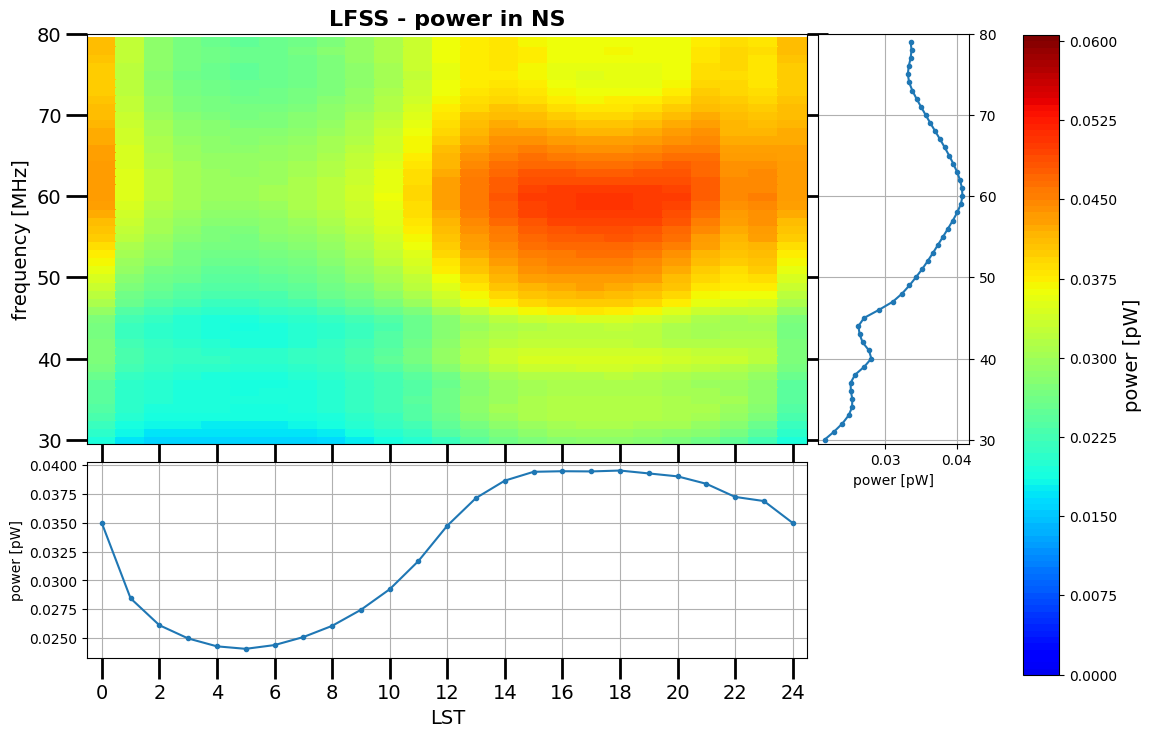

cmap.T:  256
tmins:  0  tmax:  0.06  Tstep:  9
cbarTicks:  [0.     0.0075 0.015  0.0225 0.03   0.0375 0.045  0.0525 0.06  ]
Creation of the directory failed (already exists?)


/home/tomas/myPyModules/myPlots.py:1378: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto')#,edgecolor='k',facecolor='none') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Figure has been saved to:  /home/tomas/results/skySimulation/powerDF_LFmap_NS


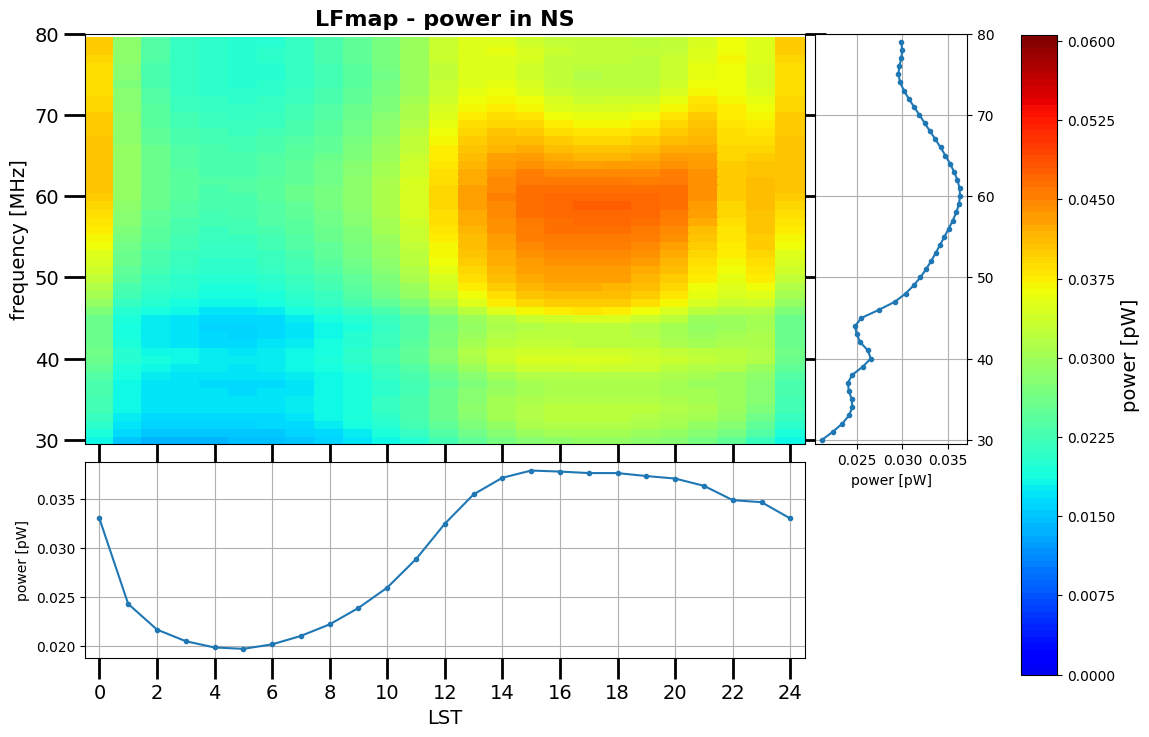

cmap.T:  256
tmins:  0.9  tmax:  1.25  Tstep:  9
cbarTicks:  [0.9     0.94375 0.9875  1.03125 1.075   1.11875 1.1625  1.20625 1.25   ]


/home/tomas/myPyModules/myPlots.py:1378: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = aZ.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, vmin = Cmin ,vmax = Cmax, shading='auto')#,edgecolor='k',facecolor='none') # by python default Cmin is Zmin, Cmax is Zmax, values < or > are subject of se_under, set_over


Creation of the directory failed (already exists?)
Figure has been saved to:  /home/tomas/results/skySimulation/Ratio_Power_NS


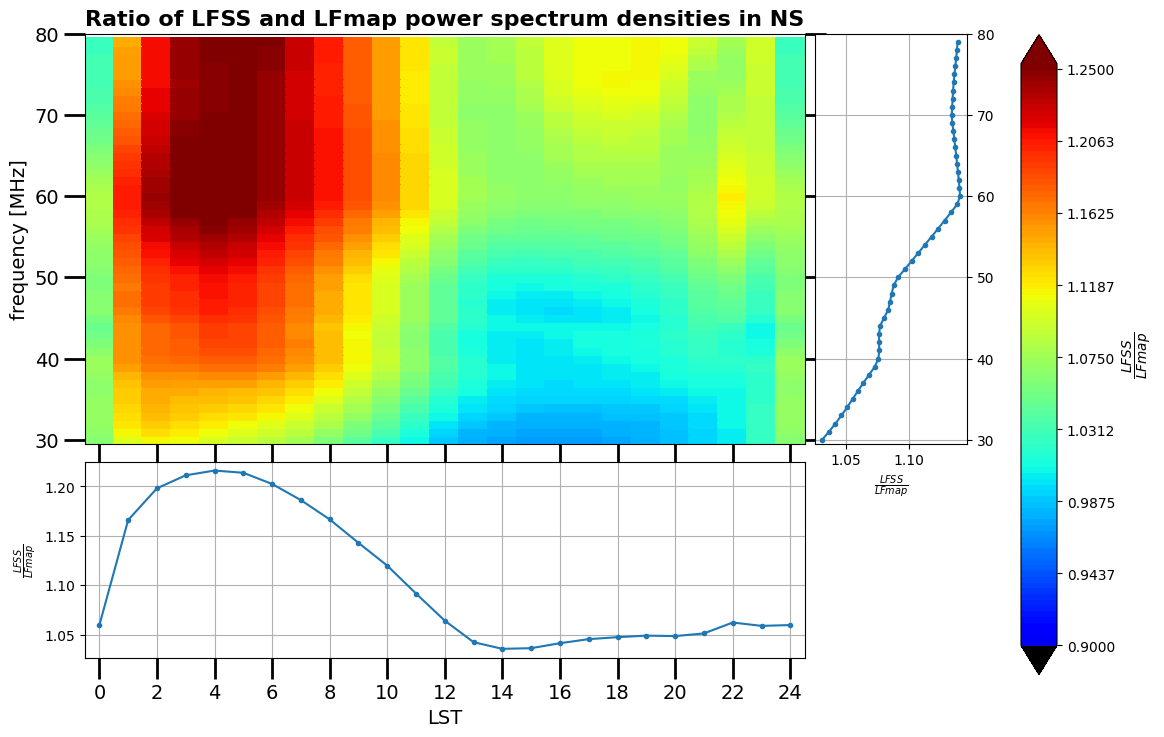

In [112]:
orientation = 'NS'
#save=saveFolder
close=False
save=False

save1 = saveFolder+'powerDF_LFSS_NS'
save2 = saveFolder+'powerDF_LFmap_NS'
save3 = saveFolder+'Ratio_Power_NS'

LST_grid, freq_grid = np.meshgrid(powerDF_LFSS_NS.index.values.astype(float),powerDF_LFSS_NS.columns.values.astype(float))
myPlots.plot3dnewV3(LST_grid, freq_grid, powerDF_LFSS_NS.values.T*1e+12,slices=True,figureWidth=12,figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel='power [pW]',xMajorLocator=2,yMajorLocator=10,
                    mainTitle="LFSS - power in "+orientation, Cmin=0, Cmax=0.06,ymin=29.5,ymax=80,
                    save=save1,close=close)

myPlots.plot3dnewV3(LST_grid, freq_grid, powerDF_LFmap_NS.values.T*1e+12,slices=True,figureWidth=12,figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel='power [pW]',xMajorLocator=2,yMajorLocator=10,
                    mainTitle="LFmap - power in "+orientation, Cmin=0, Cmax=0.06,ymin=29.5,ymax=80,
                    save=save2,close=close)

ratio = powerDF_LFSS_NS.values/powerDF_LFmap_NS.values
myPlots.plot3dnewV3(LST_grid, freq_grid, ratio.T,slices=True,figureWidth=12,figureHeight=8,
                    xlabel='LST',ylabel='frequency [MHz]',cbarLabel=r'$\frac{LFSS}{LFmap}$',xMajorLocator=2,yMajorLocator=10,
                    mainTitle="Ratio of LFSS and LFmap power spectrum densities in "+orientation, Cmin=0.9, Cmax=1.25,ymin=29.5,ymax=80,extend='both',
                    save=save3,close=close)